TensorFlow version: 2.19.0
 GPU is available! Found 1 GPU(s):
   → PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')

 Memory growth enabled — GPU is ready for training.

--- Running a quick GPU test ---
Matrix multiplication result shape: (1000, 1000)  ✅
 All libraries imported successfully.

LOADING DATASET 1: CIFAR-10 (Artificially Imbalanced)
170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Original training set: (50000, 32, 32, 3)  |  Classes: 10

Samples per class after imbalancing:
  Class  0 (airplane    ):  5000 samples
  Class  1 (automobile  ):  2997 samples
  Class  2 (bird        ):  1796 samples
  Class  3 (cat         ):  1077 samples
  Class  4 (deer        ):   645 samples
  Class  5 (dog         ):   387 samples
  Class  6 (frog        ):   232 samples
  Class  7 (horse       ):   139 samples
  Class  8 (ship        ):    83 samples
  Class  9 (truck       ):    50 samples

Final imbalanced training set shape: (12406, 32, 32, 3)
Imbalance ratio: 100

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/tf_flowers/incomplete.M39KP6_3.0.1/tf_flowers-train.tfrecord*...:   0%|   …

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.
Flower classes: ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']
Total flower images: 3670
Loading flower images (this may take ~1 minute)...
Loaded: (3670, 64, 64, 3)

Samples per class after imbalancing:
  Class 0 (dandelion   ):  100 samples
  Class 1 (daisy       ):  500 samples
  Class 2 (tulips      ):  200 samples
  Class 3 (sunflowers  ):   50 samples
  Class 4 (roses       ):  150 samples

Flower train: (800, 64, 64, 3) | test: (200, 64, 64, 3)
Imbalance ratio: 10.0:1


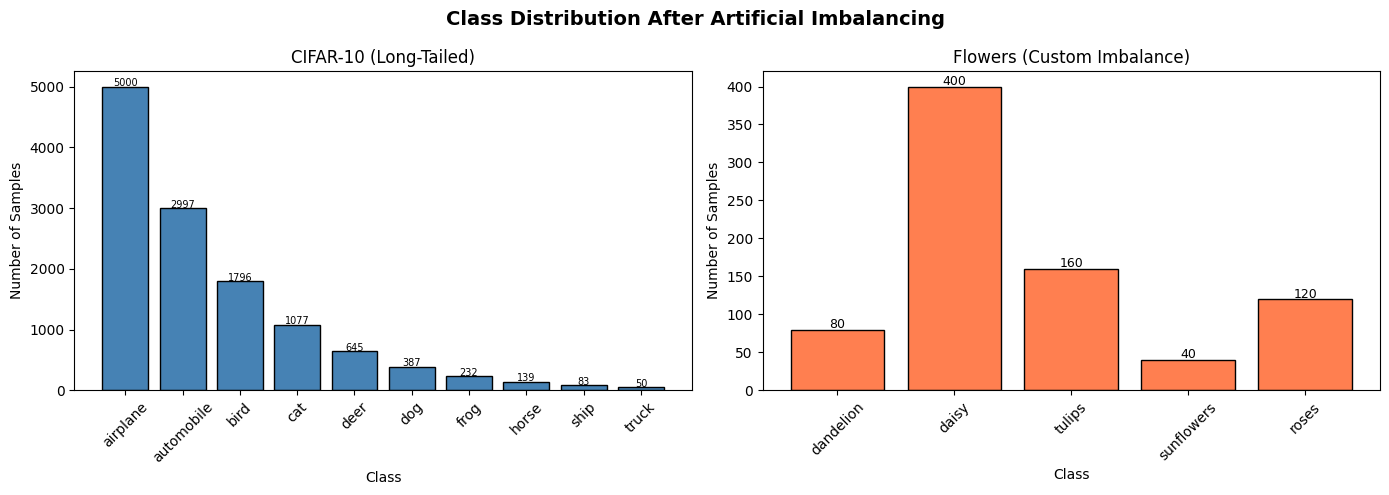


 Class distribution plot saved as 'class_distributions.png'

Class weights for CIFAR-10:
  Class 0 (airplane    ): 0.248
  Class 1 (automobile  ): 0.414
  Class 2 (bird        ): 0.691
  Class 3 (cat         ): 1.152
  Class 4 (deer        ): 1.923
  Class 5 (dog         ): 3.206
  Class 6 (frog        ): 5.347
  Class 7 (horse       ): 8.925
  Class 8 (ship        ): 14.947
  Class 9 (truck       ): 24.812

Class weights for Flowers:
  Class 0 (dandelion   ): 2.000
  Class 1 (daisy       ): 0.400
  Class 2 (tulips      ): 1.000
  Class 3 (sunflowers  ): 4.000
  Class 4 (roses       ): 1.333

  Data saved!
   cifar10_imbalanced.npz
   flowers_imbalanced.npz

 Setup complete! You are ready to run Problems 1–7.
   Load saved data in any notebook with:
   data = np.load('cifar10_imbalanced.npz')
   x_train, y_train = data['x_train'], data['y_train']


In [1]:
# STEP 0 — CHECK IF COLAB GPU IS WORKING
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

print("=" * 60)
print("TensorFlow version:", tf.__version__)
print("=" * 60)

# List all available GPUs
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    print(f" GPU is available! Found {len(gpus)} GPU(s):")
    for gpu in gpus:
        print(f"   → {gpu}")
    # Allow memory growth so TF doesn't grab ALL GPU memory at once
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print("\n Memory growth enabled — GPU is ready for training.")
else:
    print("   No GPU found. You are running on CPU.")
    print("   Go to: Runtime → Change Runtime Type → GPU  (in Google Colab)")

# Quick sanity check: run a small matrix op on GPU
print("\n--- Running a quick GPU test ---")
with tf.device('/GPU:0' if gpus else '/CPU:0'):
    a = tf.random.normal([1000, 1000])
    b = tf.random.normal([1000, 1000])
    c = tf.matmul(a, b)
print(f"Matrix multiplication result shape: {c.shape}  ✅")
print("=" * 60)



# STEP 1 — INSTALL & IMPORT ALL LIBRARIES
# Run this once at the top of your Colab session.

# In Colab, run this shell command first:
# !pip install tensorflow-datasets imbalanced-learn scikit-learn umap-learn -q

import tensorflow_datasets as tfds
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.applications import ResNet50, EfficientNetB0
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import os

print(" All libraries imported successfully.")



# STEP 2 — LOAD & PREPARE DATASET 1: CIFAR-10 WITH ARTIFICIAL IMBALANCE
# CIFAR-10 has 10 classes, originally balanced (~6000 images per class).
# We artificially create a long-tailed distribution (imbalance ratio ~100:1)
# so some classes have very few samples — simulating real-world imbalance.

print("\n" + "=" * 60)
print("LOADING DATASET 1: CIFAR-10 (Artificially Imbalanced)")
print("=" * 60)

# Load original balanced CIFAR-10
(x_train_full, y_train_full), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Class names for reference
CIFAR10_CLASSES = ['airplane','automobile','bird','cat','deer',
                   'dog','frog','horse','ship','truck']

# Normalize pixel values to [0, 1]
x_train_full = x_train_full.astype('float32') / 255.0
x_test       = x_test.astype('float32') / 255.0
y_train_full = y_train_full.flatten()
y_test       = y_test.flatten()

print(f"Original training set: {x_train_full.shape}  |  Classes: {len(CIFAR10_CLASSES)}")

# --- Create Long-Tailed Imbalance ---
# We keep a different number of samples per class.
# Class 0 (airplane) gets the most, Class 9 (truck) gets the fewest.
# This follows a geometric progression for a "long tail" effect.

def make_imbalanced_cifar(x, y, max_samples=5000, imbalance_ratio=100):
    """
    Subsample CIFAR-10 to create a long-tailed distribution.
    Class 0 gets max_samples, each subsequent class gets fewer,
    down to max_samples // imbalance_ratio for the last class.
    """
    np.random.seed(42)
    num_classes = 10
    # Geometric spacing: class i gets max_samples * (1/ratio)^(i/9)
    samples_per_class = [
        max(int(max_samples * (1 / imbalance_ratio) ** (i / (num_classes - 1))), 10)
        for i in range(num_classes)
    ]

    x_imb, y_imb = [], []
    for cls in range(num_classes):
        idx = np.where(y == cls)[0]
        n   = min(samples_per_class[cls], len(idx))
        chosen = np.random.choice(idx, n, replace=False)
        x_imb.append(x[chosen])
        y_imb.append(y[chosen])
        print(f"  Class {cls:2d} ({CIFAR10_CLASSES[cls]:12s}): {n:5d} samples")

    return np.concatenate(x_imb), np.concatenate(y_imb)

print("\nSamples per class after imbalancing:")
x_train_c10, y_train_c10 = make_imbalanced_cifar(
    x_train_full, y_train_full, max_samples=5000, imbalance_ratio=100
)

print(f"\nFinal imbalanced training set shape: {x_train_c10.shape}")
print(f"Imbalance ratio: {max(np.bincount(y_train_c10)) / min(np.bincount(y_train_c10)):.1f}:1")


# STEP 3 — LOAD & PREPARE DATASET 2: FLOWERS (tf_flowers) WITH IMBALANCE
# tf_flowers has 5 classes: daisy, dandelion, roses, sunflowers, tulips.
# We create custom sampling ratios: ~100:500:200:50:150
# (as suggested in the assignment)

print("\n" + "=" * 60)
print("LOADING DATASET 2: Flower Recognition (tf_flowers, Imbalanced)")
print("=" * 60)

IMG_SIZE = 64  # Resize all flower images to 64x64 for speed

# Load the full dataset (all splits combined, then we split manually)
ds_full, info = tfds.load(
    'tf_flowers',
    split='train',          # tf_flowers only has a 'train' split
    as_supervised=True,     # returns (image, label) tuples
    with_info=True
)

FLOWER_CLASSES = info.features['label'].names
print(f"Flower classes: {FLOWER_CLASSES}")
print(f"Total flower images: {info.splits['train'].num_examples}")

# Collect all images and labels into numpy arrays
def load_flower_dataset(dataset, img_size=64):
    """Convert tf.data.Dataset to numpy arrays with resizing."""
    images, labels = [], []
    for img, lbl in dataset:
        img = tf.image.resize(img, [img_size, img_size])
        img = tf.cast(img, tf.float32) / 255.0
        images.append(img.numpy())
        labels.append(lbl.numpy())
    return np.array(images), np.array(labels)

print("Loading flower images (this may take ~1 minute)...")
x_flowers_all, y_flowers_all = load_flower_dataset(ds_full, IMG_SIZE)
print(f"Loaded: {x_flowers_all.shape}")

# --- Create Imbalance with custom per-class sample counts ---
FLOWER_SAMPLES = {
    0: 100,   # daisy       → minority
    1: 500,   # dandelion   → majority
    2: 200,   # roses       → moderate
    3: 50,    # sunflowers  → very minority
    4: 150,   # tulips      → moderate-low
}

def make_imbalanced_flowers(x, y, samples_dict):
    np.random.seed(42)
    x_imb, y_imb = [], []
    for cls, n in samples_dict.items():
        idx     = np.where(y == cls)[0]
        n       = min(n, len(idx))
        chosen  = np.random.choice(idx, n, replace=False)
        x_imb.append(x[chosen])
        y_imb.append(y[chosen])
        print(f"  Class {cls} ({FLOWER_CLASSES[cls]:12s}): {n:4d} samples")
    return np.concatenate(x_imb), np.concatenate(y_imb)

print("\nSamples per class after imbalancing:")
x_flowers, y_flowers = make_imbalanced_flowers(x_flowers_all, y_flowers_all, FLOWER_SAMPLES)

# Train/test split (80/20)
from sklearn.model_selection import train_test_split
x_train_fl, x_test_fl, y_train_fl, y_test_fl = train_test_split(
    x_flowers, y_flowers, test_size=0.2, random_state=42, stratify=y_flowers
)
print(f"\nFlower train: {x_train_fl.shape} | test: {x_test_fl.shape}")
print(f"Imbalance ratio: {max(np.bincount(y_flowers)) / min(np.bincount(y_flowers)):.1f}:1")


# STEP 4 — VISUALIZE CLASS DISTRIBUTIONS (Bar Charts)
# Always visualize your data first. This confirms imbalance is working.

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle("Class Distribution After Artificial Imbalancing", fontsize=14, fontweight='bold')

# CIFAR-10 distribution
counts_c10 = np.bincount(y_train_c10)
axes[0].bar(CIFAR10_CLASSES, counts_c10, color='steelblue', edgecolor='black')
axes[0].set_title("CIFAR-10 (Long-Tailed)")
axes[0].set_xlabel("Class")
axes[0].set_ylabel("Number of Samples")
axes[0].tick_params(axis='x', rotation=45)
for i, v in enumerate(counts_c10):
    axes[0].text(i, v + 10, str(v), ha='center', fontsize=7)

# Flowers distribution
counts_fl = np.bincount(y_train_fl)
axes[1].bar(FLOWER_CLASSES, counts_fl, color='coral', edgecolor='black')
axes[1].set_title("Flowers (Custom Imbalance)")
axes[1].set_xlabel("Class")
axes[1].set_ylabel("Number of Samples")
axes[1].tick_params(axis='x', rotation=45)
for i, v in enumerate(counts_fl):
    axes[1].text(i, v + 2, str(v), ha='center', fontsize=9)

plt.tight_layout()
plt.savefig("class_distributions.png", dpi=150, bbox_inches='tight')
plt.show()
print("\n Class distribution plot saved as 'class_distributions.png'")


# STEP 5 — HELPER: COMPUTE CLASS WEIGHTS (used in later problems)
# Class weights tell the loss function to penalize mistakes on minority
# classes more heavily. We precompute them here for reuse.

def get_class_weights(y_labels):
    """Returns a dict {class_index: weight} for use in model.fit()"""
    classes = np.unique(y_labels)
    weights = compute_class_weight('balanced', classes=classes, y=y_labels)
    return dict(zip(classes, weights))

cw_cifar10 = get_class_weights(y_train_c10)
cw_flowers  = get_class_weights(y_train_fl)

print("\nClass weights for CIFAR-10:")
for cls, w in cw_cifar10.items():
    print(f"  Class {cls} ({CIFAR10_CLASSES[cls]:12s}): {w:.3f}")

print("\nClass weights for Flowers:")
for cls, w in cw_flowers.items():
    print(f"  Class {cls} ({FLOWER_CLASSES[cls]:12s}): {w:.3f}")


# STEP 6 — EXPORT PREPARED DATA (Save as .npz for reuse in all problems)
# Saving preprocessed data means you don't re-run steps 2-3 in every notebook.

np.savez_compressed('cifar10_imbalanced.npz',
    x_train=x_train_c10, y_train=y_train_c10,
    x_test=x_test,        y_test=y_test)

np.savez_compressed('flowers_imbalanced.npz',
    x_train=x_train_fl, y_train=y_train_fl,
    x_test=x_test_fl,   y_test=y_test_fl)

print("\n  Data saved!")
print("   cifar10_imbalanced.npz")
print("   flowers_imbalanced.npz")
print("\n Setup complete! You are ready to run Problems 1–7.")
print("   Load saved data in any notebook with:")
print("   data = np.load('cifar10_imbalanced.npz')")
print("   x_train, y_train = data['x_train'], data['y_train']")

CIFAR-10  → train: (12406, 32, 32, 3), test: (10000, 32, 32, 3)
Flowers   → train: (800, 64, 64, 3),  test: (200, 64, 64, 3)

TRAINING: Custom CNN on Imbalanced CIFAR-10


Model: "CustomCNN_CIFAR10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 8, 8, 128)      │             

 Total params: 325,418 (1.24 MB)

 Trainable params: 324,010 (1.24 MB)

 Non-trainable params: 1,408 (5.50 KB)

Epoch 1/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 22s 62ms/step - accuracy: 0.6382 - loss: 1.0762 - val_accuracy: 0.0000e+00 - val_loss: 7.9507 - learning_rate: 0.0010
Epoch 2/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7688 - loss: 0.6246 - val_accuracy: 0.0048 - val_loss: 9.3551 - learning_rate: 0.0010
Epoch 3/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8066 - loss: 0.5368 - val_accuracy: 0.0365 - val_loss: 9.3836 - learning_rate: 0.0010
Epoch 4/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8167 - loss: 0.4941
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8167 - loss: 0.4940 - val_accuracy: 0.0382 - val_loss: 13.0519 - learning_rate: 0.0010
Epoch 5/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8530 - loss: 0.4028 - val_accuracy: 0.0548 - val_loss: 10.0363 - learning_rate: 5.0000e-04
Epoch 6/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8658 -

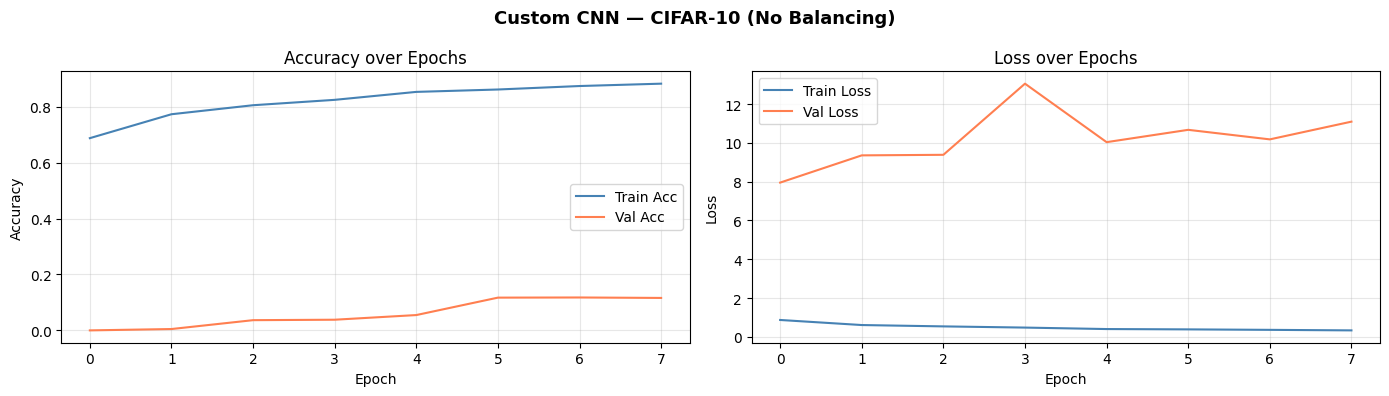


EVALUATION: Custom CNN CIFAR-10
Test Loss:     6.6086
Test Accuracy: 0.1000 (10.00%)

Classification Report (class-wise precision, recall, F1):
              precision    recall  f1-score   support

    airplane       0.10      1.00      0.18      1000
  automobile       0.00      0.00      0.00      1000
        bird       0.00      0.00      0.00      1000
         cat       0.00      0.00      0.00      1000
        deer       0.00      0.00      0.00      1000
         dog       0.00      0.00      0.00      1000
        frog       0.00      0.00      0.00      1000
       horse       0.00      0.00      0.00      1000
        ship       0.00      0.00      0.00      1000
       truck       0.00      0.00      0.00      1000

    accuracy                           0.10     10000
   macro avg       0.01      0.10      0.02     10000
weighted avg       0.01      0.10      0.02     10000



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


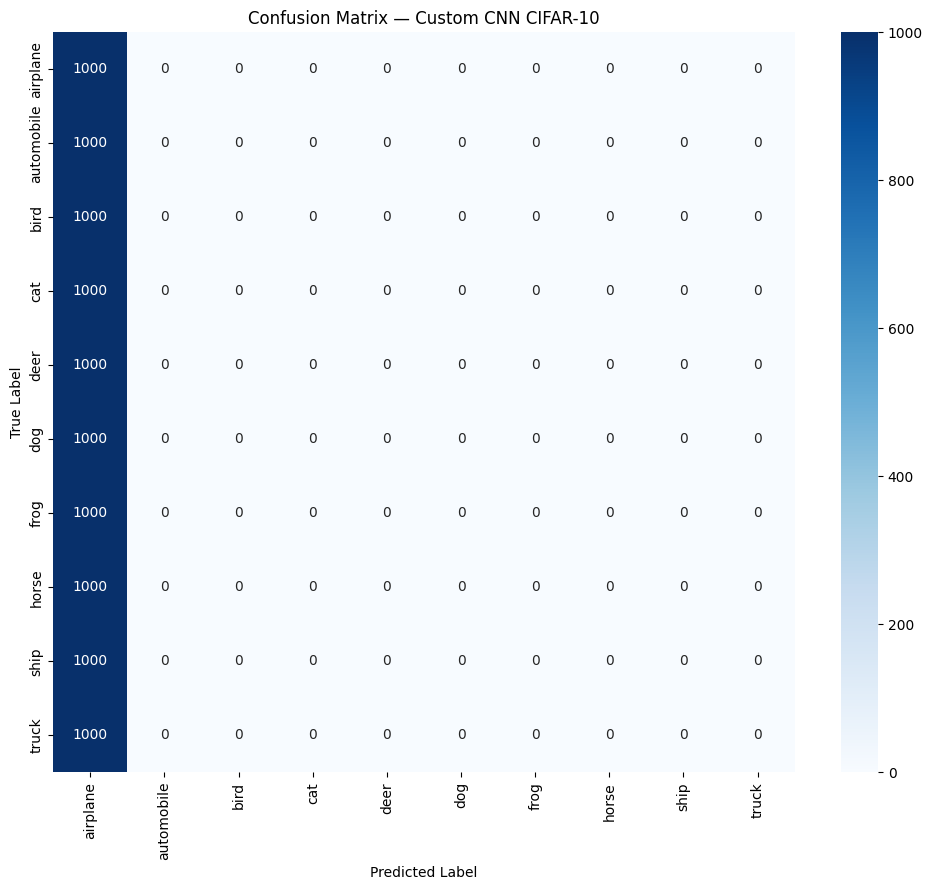


TRAINING: Custom CNN on Imbalanced Flowers


Model: "CustomCNN_Flowers"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 64, 64, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 16, 16, 128)    │             

 Total params: 324,133 (1.24 MB)

 Trainable params: 322,725 (1.23 MB)

 Non-trainable params: 1,408 (5.50 KB)

Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 22s 455ms/step - accuracy: 0.3924 - loss: 1.9104 - val_accuracy: 0.4667 - val_loss: 1.5112 - learning_rate: 0.0010
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.5917 - loss: 1.1788 - val_accuracy: 0.4667 - val_loss: 1.4924 - learning_rate: 0.0010
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6597 - loss: 1.0520 - val_accuracy: 0.4667 - val_loss: 1.5905 - learning_rate: 0.0010
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6238 - loss: 1.0115 - val_accuracy: 0.4667 - val_loss: 1.5631 - learning_rate: 0.0010
Epoch 5/50
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6831 - loss: 0.9356
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6833 - loss: 0.9372 - val_accuracy: 0.0917 - val_loss: 1.7981 - learning_rate: 0.0010
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6807 - loss: 0.8649 - val_ac

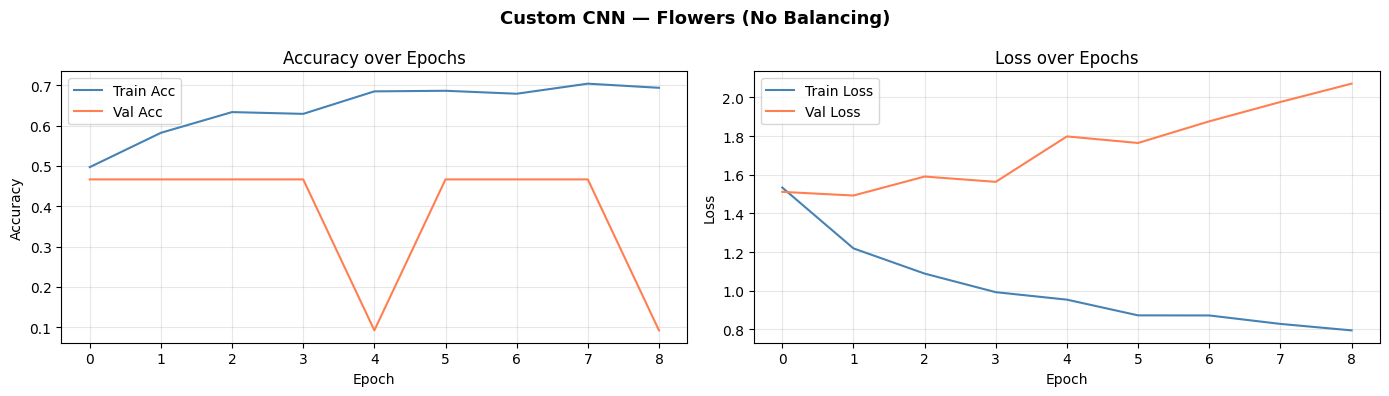


EVALUATION: Custom CNN Flowers
Test Loss:     1.4427
Test Accuracy: 0.5000 (50.00%)

Classification Report (class-wise precision, recall, F1):
              precision    recall  f1-score   support

       daisy       0.00      0.00      0.00        20
   dandelion       0.50      1.00      0.67       100
       roses       0.00      0.00      0.00        40
  sunflowers       0.00      0.00      0.00        10
      tulips       0.00      0.00      0.00        30

    accuracy                           0.50       200
   macro avg       0.10      0.20      0.13       200
weighted avg       0.25      0.50      0.33       200



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


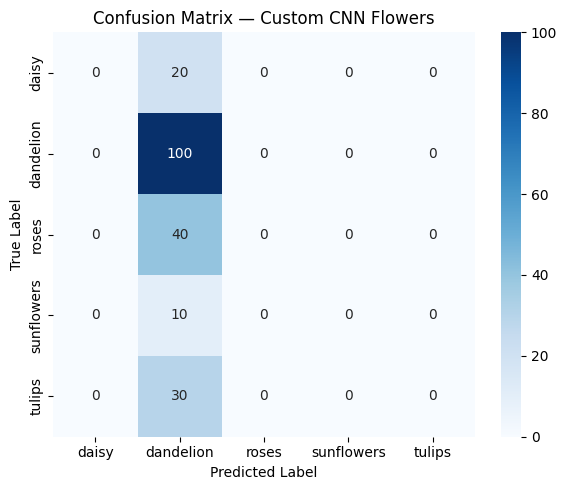


TRAINING: ResNet50 Transfer Learning on Flowers
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "ResNet50_Flowers"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resizing (Resizing) │ (None, 224, 224,  │          0 │ input_layer_2[0]… │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 224, 224,  │          0 │ resizing[0][0]    │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 224, 224)  │          0 │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 224, 224)  │          0 │ multiply[0][0]    │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 224, 224)  │          0 │ multiply[0][0]    │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 224, 224,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 224, 224,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ add[0][0]         │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b

 Total params: 24,113,541 (91.99 MB)

 Trainable params: 525,829 (2.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 34s 975ms/step - accuracy: 0.5599 - loss: 1.5385 - val_accuracy: 0.7917 - val_loss: 0.6947 - learning_rate: 0.0010
Epoch 2/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 0.8287 - loss: 0.4527 - val_accuracy: 0.7667 - val_loss: 0.6872 - learning_rate: 0.0010
Epoch 3/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - accuracy: 0.8907 - loss: 0.3276 - val_accuracy: 0.7667 - val_loss: 0.6395 - learning_rate: 0.0010
Epoch 4/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 0.9399 - loss: 0.2307 - val_accuracy: 0.7500 - val_loss: 0.6791 - learning_rate: 0.0010
Epoch 5/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 168ms/step - accuracy: 0.9423 - loss: 0.1935 - val_accuracy: 0.8167 - val_loss: 0.6114 - learning_rate: 0.0010
Epoch 6/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 0.9659 - loss: 0.1436 - val_accuracy: 0.8083 - val_loss: 0.6032 - learning_rate: 0.0010
Epoch 7/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 0.9840 - loss: 0.1039 -

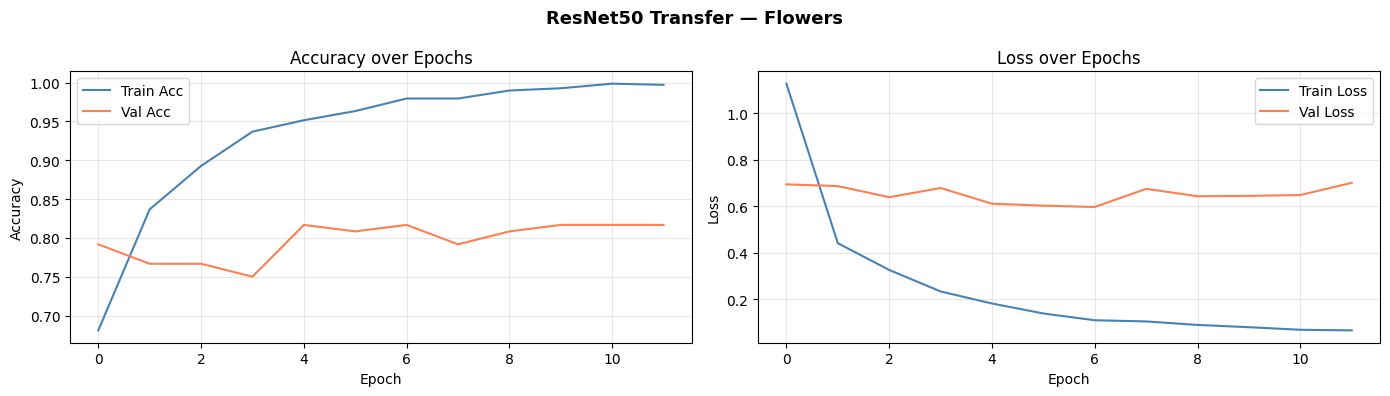


EVALUATION: ResNet50 Flowers


Test Loss:     0.5953
Test Accuracy: 0.8150 (81.50%)

Classification Report (class-wise precision, recall, F1):
              precision    recall  f1-score   support

       daisy       0.83      0.95      0.88        20
   dandelion       0.92      0.92      0.92       100
       roses       0.75      0.68      0.71        40
  sunflowers       1.00      0.50      0.67        10
      tulips       0.56      0.67      0.61        30

    accuracy                           0.81       200
   macro avg       0.81      0.74      0.76       200
weighted avg       0.83      0.81      0.81       200



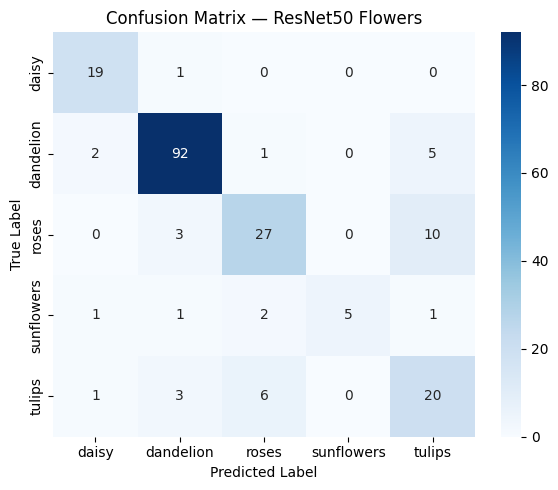


IMBALANCE IMPACT ANALYSIS — CIFAR-10 Custom CNN

KEY OBSERVATIONS:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
1. ACCURACY IS MISLEADING with imbalanced data.
   A model that always predicts the majority class can achieve
   high accuracy while completely ignoring minority classes.

2. LOOK AT RECALL for minority classes:
   - Classes with few samples (e.g., truck with ~50 images) 
     will have low recall — the model rarely correctly identifies them.
   - Classes with many samples (e.g., airplane with 5000 images)
     will dominate predictions.

3. MACRO F1-SCORE is the metric to watch:
   - It averages F1 across ALL classes equally (not weighted by count)
   - Low macro F1 = model is biased toward majority classes.
   
4. CONFUSION MATRIX patterns:
   - Minority class rows will show predictions scattered to majority classes.
   - Most confusions happen WITHIN similar-looking class pairs.
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
→ Problem 2 will FIX the

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<Figure size 1200x400 with 0 Axes>

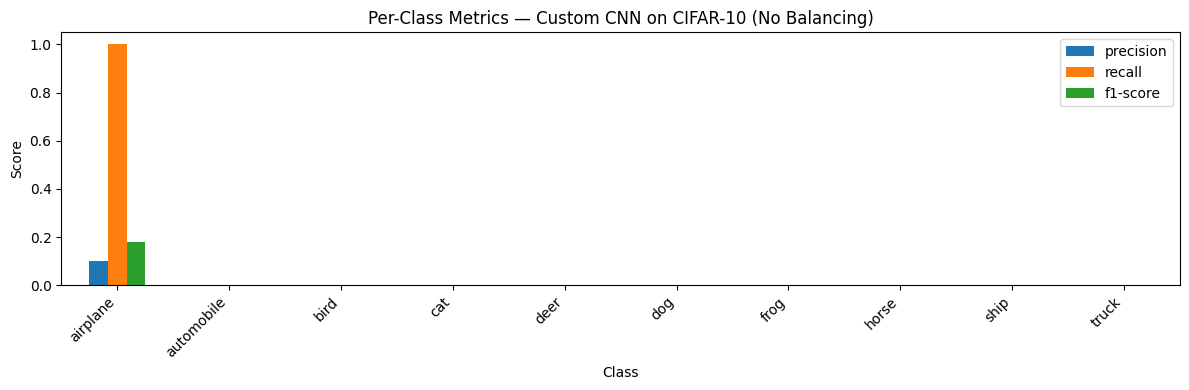

   Problem 1 complete!
   Models saved: best_custom_cnn_cifar10.keras, best_custom_cnn_flowers.keras, best_resnet50_flowers.keras
   Plots saved: *_history.png, confusion_*.png, per_class_metrics_cifar10.png


In [2]:
# PROBLEM 1 — CNN ARCHITECTURE DESIGN
# Custom CNN + Modified ResNet50 for Imbalanced Classification
# Datasets: CIFAR-10 (imbalanced) + Flowers (imbalanced)
#   Custom CNN built from scratch with justified design choices
#   Modified ResNet50 (pretrained) with custom head
#   Batch Normalization, Dropout, L2 regularization
#   Training on both imbalanced datasets
#   Performance analysis showing imbalance impact

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, callbacks
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# --- Load preprocessed data (run P0 first!) ---
c10   = np.load('cifar10_imbalanced.npz')
fl    = np.load('flowers_imbalanced.npz')

x_train_c10, y_train_c10 = c10['x_train'], c10['y_train']
x_test_c10,  y_test_c10  = c10['x_test'],  c10['y_test']

x_train_fl, y_train_fl   = fl['x_train'],  fl['y_train']
x_test_fl,  y_test_fl    = fl['x_test'],   fl['y_test']

CIFAR10_CLASSES = ['airplane','automobile','bird','cat','deer',
                   'dog','frog','horse','ship','truck']
FLOWER_CLASSES  = ['daisy','dandelion','roses','sunflowers','tulips']

print(f"CIFAR-10  → train: {x_train_c10.shape}, test: {x_test_c10.shape}")
print(f"Flowers   → train: {x_train_fl.shape},  test: {x_test_fl.shape}")


# =============================================================================
# ARCHITECTURE 1: CUSTOM CNN (Designed from scratch)
# =============================================================================
# Design Justification:
# ─────────────────────
# • 3 conv blocks with increasing filters (32→64→128):
#     - Small images (32x32 CIFAR, 64x64 flowers) don't need deep networks
#     - Doubling filters captures increasingly complex features per block
# • 3×3 kernels: Best balance of receptive field size vs parameter count
# • BatchNormalization after each conv: Stabilizes training, acts as regularizer,
#     allows higher learning rates — especially helpful with imbalanced data
#     where gradients can become unstable
# • MaxPooling: Progressively reduces spatial size, adds translation invariance
# • Dropout(0.4): Prevents overfitting to majority class patterns
# • L2 on Dense layer: Further penalizes large weights that overfit majority
# • ReLU activation: Standard, avoids vanishing gradient problem

def build_custom_cnn(input_shape, num_classes, name="CustomCNN"):
    """
    A compact 3-block CNN suitable for small/medium image classification.

    Args:
        input_shape: tuple like (32, 32, 3)
        num_classes: int — number of output classes
        name: string name for the model

    Returns:
        Compiled Keras model
    """
    model = models.Sequential(name=name)

    # ── Block 1: Learn low-level features (edges, textures) ──────────────────
    # 32 filters × 3×3 kernel → detect basic patterns
    model.add(layers.Input(shape=input_shape))

    model.add(layers.Conv2D(32, (3, 3), padding='same'))
    model.add(layers.BatchNormalization())   # normalize activations
    model.add(layers.Activation('relu'))

    model.add(layers.Conv2D(32, (3, 3), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))

    model.add(layers.MaxPooling2D((2, 2)))   # halve spatial dimensions
    model.add(layers.Dropout(0.25))          # light dropout in early layers

    # ── Block 2: Learn mid-level features (shapes, parts) ────────────────────
    model.add(layers.Conv2D(64, (3, 3), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))

    model.add(layers.Conv2D(64, (3, 3), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))

    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.30))

    # ── Block 3: Learn high-level features (class-specific patterns) ──────────
    model.add(layers.Conv2D(128, (3, 3), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))

    model.add(layers.Conv2D(128, (3, 3), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))

    model.add(layers.GlobalAveragePooling2D())  # Better than Flatten for small images;
                                                 # reduces parameters and overfitting

    # ── Classifier Head ───────────────────────────────────────────────────────
    model.add(layers.Dense(256,
                           kernel_regularizer=regularizers.l2(1e-4)))  # L2 penalty
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Dropout(0.4))              # strong dropout before output

    # Output layer: softmax gives probability per class
    model.add(layers.Dense(num_classes, activation='softmax'))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


# ARCHITECTURE 2: MODIFIED ResNet50 (Transfer Learning)
# Design Justification:
# ─────────────────────
# • ResNet50 pretrained on ImageNet gives us powerful feature extractors
#     without training from scratch
# • We FREEZE the base (feature extractor) and only train the top layers
#     This is called "feature extraction" — fast and works well when
#     target domain is similar to ImageNet (natural images = flowers, CIFAR)
# • Custom head: GlobalAveragePooling → Dense(256) → Dropout → Output
# • Input is upsampled to 224×224 (ResNet's expected input size)

def build_resnet50_transfer(input_shape_original, num_classes, name="ResNet50_Transfer"):
    """
    ResNet50 with frozen base for feature extraction.
    Images are resized internally to 224×224.
    """
    # Input at original resolution
    inputs = tf.keras.Input(shape=input_shape_original)

    # Upsample small images to 224x224 (ResNet50 requirement)
    x = layers.Resizing(224, 224)(inputs)

    # Preprocess for ResNet (scales pixels to [-1, 1])
    x = tf.keras.applications.resnet50.preprocess_input(x * 255.0)

    # Load ResNet50 WITHOUT the top classification layer
    base_model = tf.keras.applications.ResNet50(
        include_top=False,        # remove ImageNet classifier
        weights='imagenet',       # use pretrained weights
        input_tensor=x
    )
    base_model.trainable = False  # FREEZE: don't update pretrained weights

    # Custom classifier head
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu',
                     kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs, name=name)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


# TRAINING UTILITY FUNCTIONS
def get_callbacks(model_name, patience=7):
    """
    Standard callbacks for stable training:
    - EarlyStopping: stop when val_loss stops improving (prevents overfitting)
    - ReduceLROnPlateau: reduce LR when stuck (helps with imbalanced data)
    - ModelCheckpoint: save the best model weights
    """
    return [
        callbacks.EarlyStopping(
            monitor='val_loss',
            patience=patience,
            restore_best_weights=True,   # revert to best epoch at the end
            verbose=1
        ),
        callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,                  # halve LR when plateauing
            patience=3,
            min_lr=1e-6,
            verbose=1
        ),
        callbacks.ModelCheckpoint(
            filepath=f'best_{model_name}.keras',
            monitor='val_accuracy',
            save_best_only=True,
            verbose=0
        )
    ]


def plot_training_history(history, title):
    """Plot accuracy and loss curves side by side."""
    fig, axes = plt.subplots(1, 2, figsize=(14, 4))
    fig.suptitle(title, fontsize=13, fontweight='bold')

    # Accuracy
    axes[0].plot(history.history['accuracy'],     label='Train Acc', color='steelblue')
    axes[0].plot(history.history['val_accuracy'], label='Val Acc',   color='coral')
    axes[0].set_title('Accuracy over Epochs')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Loss
    axes[1].plot(history.history['loss'],     label='Train Loss', color='steelblue')
    axes[1].plot(history.history['val_loss'], label='Val Loss',   color='coral')
    axes[1].set_title('Loss over Epochs')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f"{title.replace(' ', '_')}_history.png", dpi=150, bbox_inches='tight')
    plt.show()


def evaluate_model(model, x_test, y_test, class_names, title):
    """Full evaluation: accuracy, classification report, confusion matrix."""
    print(f"\n{'='*60}")
    print(f"EVALUATION: {title}")
    print('='*60)

    # Predict
    y_pred_probs = model.predict(x_test, verbose=0)
    y_pred       = np.argmax(y_pred_probs, axis=1)

    # Overall accuracy
    loss, acc = model.evaluate(x_test, y_test, verbose=0)
    print(f"Test Loss:     {loss:.4f}")
    print(f"Test Accuracy: {acc:.4f} ({acc*100:.2f}%)")

    # Class-wise report (important for imbalanced datasets!)
    print("\nClassification Report (class-wise precision, recall, F1):")
    print(classification_report(y_test, y_pred, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(max(6, len(class_names)), max(5, len(class_names)-1)))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix — {title}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig(f"confusion_{title.replace(' ', '_')}.png", dpi=150)
    plt.show()

    return y_pred, y_pred_probs


# TRAIN MODEL A: Custom CNN on CIFAR-10
print("\n" + "="*60)
print("TRAINING: Custom CNN on Imbalanced CIFAR-10")
print("="*60)

# NOTE: We use class_weight here to show BASELINE (without balancing strategy).
# Problem 2 will compare multiple strategies properly.

custom_cnn_c10 = build_custom_cnn(
    input_shape=(32, 32, 3),
    num_classes=10,
    name="CustomCNN_CIFAR10"
)
custom_cnn_c10.summary()

history_c10_custom = custom_cnn_c10.fit(
    x_train_c10, y_train_c10,
    epochs=50,
    batch_size=64,
    validation_split=0.15,          # 15% of training data used for validation
    callbacks=get_callbacks('custom_cnn_cifar10'),
    verbose=1
)

plot_training_history(history_c10_custom, "Custom CNN — CIFAR-10 (No Balancing)")
y_pred_c10, _ = evaluate_model(
    custom_cnn_c10, x_test_c10, y_test_c10, CIFAR10_CLASSES, "Custom CNN CIFAR-10"
)


# TRAIN MODEL B: Custom CNN on Flowers
print("\n" + "="*60)
print("TRAINING: Custom CNN on Imbalanced Flowers")
print("="*60)

custom_cnn_fl = build_custom_cnn(
    input_shape=(64, 64, 3),
    num_classes=5,
    name="CustomCNN_Flowers"
)
custom_cnn_fl.summary()

history_fl_custom = custom_cnn_fl.fit(
    x_train_fl, y_train_fl,
    epochs=50,
    batch_size=32,
    validation_split=0.15,
    callbacks=get_callbacks('custom_cnn_flowers'),
    verbose=1
)

plot_training_history(history_fl_custom, "Custom CNN — Flowers (No Balancing)")
y_pred_fl, _ = evaluate_model(
    custom_cnn_fl, x_test_fl, y_test_fl, FLOWER_CLASSES, "Custom CNN Flowers"
)


# TRAIN MODEL C: ResNet50 Transfer on Flowers
print("\n" + "="*60)
print("TRAINING: ResNet50 Transfer Learning on Flowers")
print("="*60)
# We use Flowers for ResNet because 64×64 color images are closer to ImageNet
# domain (natural images), making transfer learning more effective.

resnet_fl = build_resnet50_transfer(
    input_shape_original=(64, 64, 3),
    num_classes=5,
    name="ResNet50_Flowers"
)
resnet_fl.summary()

history_fl_resnet = resnet_fl.fit(
    x_train_fl, y_train_fl,
    epochs=30,            # Fewer epochs needed — pretrained weights are already good
    batch_size=32,
    validation_split=0.15,
    callbacks=get_callbacks('resnet50_flowers', patience=5),
    verbose=1
)

plot_training_history(history_fl_resnet, "ResNet50 Transfer — Flowers")
y_pred_fl_resnet, _ = evaluate_model(
    resnet_fl, x_test_fl, y_test_fl, FLOWER_CLASSES, "ResNet50 Flowers"
)


# IMBALANCE IMPACT ANALYSIS
# This section answers: "How does imbalance hurt performance?"
# Key insight: Accuracy can be high but minority class recall is very low.

print("\n" + "="*60)
print("IMBALANCE IMPACT ANALYSIS — CIFAR-10 Custom CNN")
print("="*60)
print("""
KEY OBSERVATIONS:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
1. ACCURACY IS MISLEADING with imbalanced data.
   A model that always predicts the majority class can achieve
   high accuracy while completely ignoring minority classes.

2. LOOK AT RECALL for minority classes:
   - Classes with few samples (e.g., truck with ~50 images)
     will have low recall — the model rarely correctly identifies them.
   - Classes with many samples (e.g., airplane with 5000 images)
     will dominate predictions.

3. MACRO F1-SCORE is the metric to watch:
   - It averages F1 across ALL classes equally (not weighted by count)
   - Low macro F1 = model is biased toward majority classes.

4. CONFUSION MATRIX patterns:
   - Minority class rows will show predictions scattered to majority classes.
   - Most confusions happen WITHIN similar-looking class pairs.
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
→ Problem 2 will FIX these issues with balancing strategies.
""")

# Per-class accuracy visualization
from sklearn.metrics import classification_report
import pandas as pd

report = classification_report(y_test_c10, y_pred_c10,
                               target_names=CIFAR10_CLASSES, output_dict=True)
df_report = pd.DataFrame(report).T.iloc[:10]  # only class rows

plt.figure(figsize=(12, 4))
df_report[['precision', 'recall', 'f1-score']].plot(kind='bar', figsize=(12, 4))
plt.title("Per-Class Metrics — Custom CNN on CIFAR-10 (No Balancing)")
plt.xlabel("Class")
plt.ylabel("Score")
plt.xticks(rotation=45, ha='right')
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig("per_class_metrics_cifar10.png", dpi=150, bbox_inches='tight')
plt.show()

print("   Problem 1 complete!")
print("   Models saved: best_custom_cnn_cifar10.keras, best_custom_cnn_flowers.keras, best_resnet50_flowers.keras")
print("   Plots saved: *_history.png, confusion_*.png, per_class_metrics_cifar10.png")

Training samples: 12406 | Test samples: 10000
Class distribution: [5000 2997 1796 1077  645  387  232  139   83   50]

STRATEGY 0: BASELINE (No balancing)
Epoch 1/40
165/165 ━━━━━━━━━━━━━━━━━━━━ 16s 47ms/step - accuracy: 0.6126 - loss: 1.1879 - val_accuracy: 0.0000e+00 - val_loss: 5.1786 - learning_rate: 0.0010
Epoch 2/40
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7487 - loss: 0.6774 - val_accuracy: 0.0188 - val_loss: 6.9310 - learning_rate: 0.0010
Epoch 3/40
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8050 - loss: 0.5367 - val_accuracy: 0.0758 - val_loss: 9.2043 - learning_rate: 0.0010
Epoch 4/40
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8185 - loss: 0.5056 - val_accuracy: 0.0032 - val_loss: 10.5221 - learning_rate: 0.0010
Epoch 5/40
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8339 - loss: 0.4469 - val_accuracy: 0.0876 - val_loss: 8.9278 - learning_rate: 5.0000e-04
Epoch 6/40
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8420 - 

Macro F1: 0.0356 | Balanced Acc: 0.1184

STRATEGY 1: CLASS WEIGHTING
Class weights: {'airplane': np.float64(0.25), 'automobile': np.float64(0.41), 'bird': np.float64(0.69), 'cat': np.float64(1.15), 'deer': np.float64(1.92), 'dog': np.float64(3.21), 'frog': np.float64(5.35), 'horse': np.float64(8.93), 'ship': np.float64(14.95), 'truck': np.float64(24.81)}
Epoch 1/40
165/165 ━━━━━━━━━━━━━━━━━━━━ 17s 51ms/step - accuracy: 0.5373 - loss: 0.6224 - val_accuracy: 0.0000e+00 - val_loss: 5.8083 - learning_rate: 0.0010
Epoch 2/40
165/165 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.7089 - loss: 0.3608 - val_accuracy: 0.0516 - val_loss: 8.5986 - learning_rate: 0.0010
Epoch 3/40
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7519 - loss: 0.3154 - val_accuracy: 0.0435 - val_loss: 10.9545 - learning_rate: 0.0010
Epoch 4/40
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7690 - loss: 0.2885 - val_accuracy: 0.1526 - val_loss: 11.0271 - learning_rate: 0.0010
Epoch 5/40
165/165 ━━━━━━━

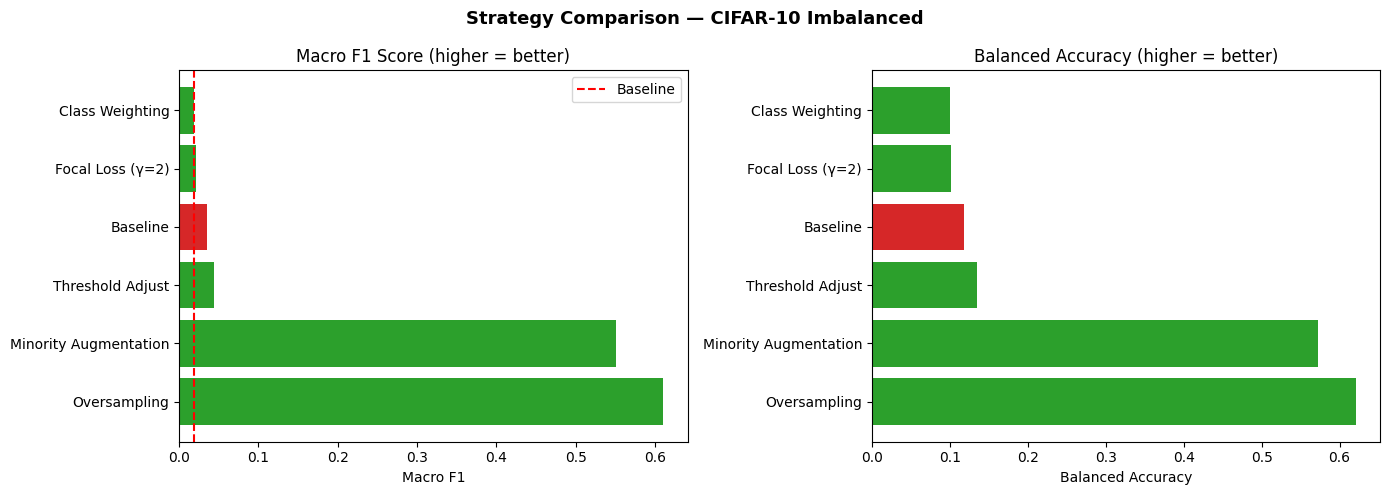

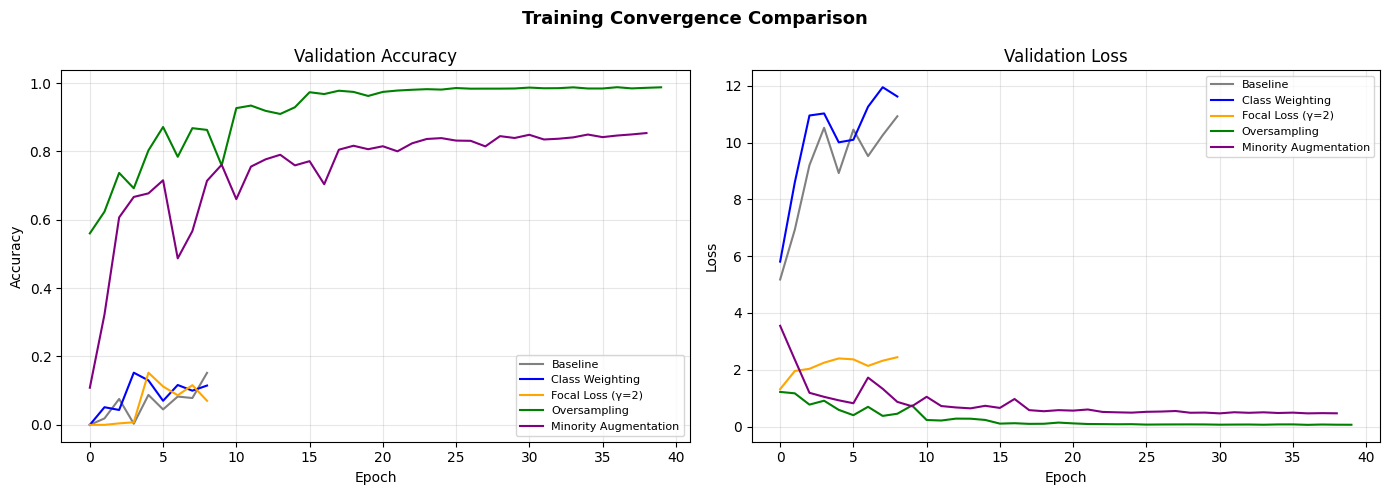


 Problem 2 complete!
   strategy_comparison.png   — Bar chart of all strategies
   convergence_comparison.png — Training curves overlay


In [3]:
# PROBLEM 2 — IMBALANCED DATASET HANDLING
# Compare multiple strategies to fix class imbalance
# Strategies covered:
#   DATA-LEVEL:
#     Random Oversampling (minority classes duplicated)
#     Random Undersampling (majority classes trimmed)
#     Data Augmentation for minority classes only
#   ALGORITHM-LEVEL:
#     Class weighting in loss function
#     Focal Loss (custom implementation)
#     Threshold adjustment at inference
#   EVALUATION:
#     Training convergence plots per strategy
#     Class-wise accuracy for minority classes
#     Macro F1 score comparison table

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, callbacks
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, f1_score, balanced_accuracy_score
from sklearn.utils.class_weight import compute_class_weight
import pandas as pd
import seaborn as sns

# Load data
c10 = np.load('cifar10_imbalanced.npz')
x_train, y_train = c10['x_train'], c10['y_train']
x_test,  y_test  = c10['x_test'],  c10['y_test']

CLASSES    = ['airplane','automobile','bird','cat','deer',
              'dog','frog','horse','ship','truck']
NUM_CLASSES = 10
INPUT_SHAPE = (32, 32, 3)

print(f"Training samples: {len(x_train)} | Test samples: {len(x_test)}")
print(f"Class distribution: {np.bincount(y_train)}")


# BASE MODEL FACTORY
# We use the same architecture for ALL strategies so comparison is fair.
# Only the training DATA or LOSS FUNCTION changes between experiments.

def build_base_model(num_classes=10, input_shape=(32, 32, 3), name="BaseCNN"):
    model = models.Sequential([
        layers.Input(shape=input_shape),

        layers.Conv2D(32, 3, padding='same'), layers.BatchNormalization(), layers.Activation('relu'),
        layers.Conv2D(32, 3, padding='same'), layers.BatchNormalization(), layers.Activation('relu'),
        layers.MaxPooling2D(), layers.Dropout(0.25),

        layers.Conv2D(64, 3, padding='same'), layers.BatchNormalization(), layers.Activation('relu'),
        layers.Conv2D(64, 3, padding='same'), layers.BatchNormalization(), layers.Activation('relu'),
        layers.MaxPooling2D(), layers.Dropout(0.30),

        layers.Conv2D(128, 3, padding='same'), layers.BatchNormalization(), layers.Activation('relu'),
        layers.GlobalAveragePooling2D(),

        layers.Dense(256, kernel_regularizer=regularizers.l2(1e-4)),
        layers.BatchNormalization(), layers.Activation('relu'), layers.Dropout(0.4),

        layers.Dense(num_classes, activation='softmax')
    ], name=name)
    return model


def compile_model(model, loss='sparse_categorical_crossentropy', lr=1e-3):
    model.compile(
        optimizer=tf.keras.optimizers.Adam(lr),
        loss=loss,
        metrics=['accuracy']
    )
    return model


CALLBACKS = [
    callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
]

EPOCHS     = 40
BATCH_SIZE = 64
VAL_SPLIT  = 0.15

# Store results from each strategy for final comparison
results = {}  # {strategy_name: {'history': ..., 'macro_f1': ..., 'bal_acc': ...}}

# STRATEGY 0: BASELINE (No balancing — for comparison)
print("\n" + "="*60)
print("STRATEGY 0: BASELINE (No balancing)")
print("="*60)

model_base = compile_model(build_base_model(name="Baseline"))
hist_base  = model_base.fit(
    x_train, y_train,
    epochs=EPOCHS, batch_size=BATCH_SIZE,
    validation_split=VAL_SPLIT, callbacks=CALLBACKS, verbose=1
)
y_pred_base = np.argmax(model_base.predict(x_test, verbose=0), axis=1)
results['Baseline'] = {
    'history':  hist_base,
    'macro_f1': f1_score(y_test, y_pred_base, average='macro'),
    'bal_acc':  balanced_accuracy_score(y_test, y_pred_base)
}
print(f"Macro F1: {results['Baseline']['macro_f1']:.4f} | Balanced Acc: {results['Baseline']['bal_acc']:.4f}")


# STRATEGY 1: CLASS WEIGHTING IN LOSS FUNCTION
# How it works:
#   sklearn computes weights inversely proportional to class frequency.
#   A class with 50 samples gets ~10x the weight of a class with 500 samples.
#   This means the loss for misclassifying a rare sample is penalized more.
# Pros: Simple, no data duplication, works with any loss function.
# Cons: Doesn't add new information, can slow convergence.

print("\n" + "="*60)
print("STRATEGY 1: CLASS WEIGHTING")
print("="*60)

classes  = np.unique(y_train)
weights  = compute_class_weight('balanced', classes=classes, y=y_train)
cw_dict  = dict(zip(classes, weights))
print("Class weights:", {CLASSES[k]: round(v, 2) for k, v in cw_dict.items()})

model_cw = compile_model(build_base_model(name="ClassWeighted"))
hist_cw  = model_cw.fit(
    x_train, y_train,
    epochs=EPOCHS, batch_size=BATCH_SIZE,
    validation_split=VAL_SPLIT, callbacks=CALLBACKS,
    class_weight=cw_dict,      # ← THE KEY CHANGE
    verbose=1
)
y_pred_cw = np.argmax(model_cw.predict(x_test, verbose=0), axis=1)
results['Class Weighting'] = {
    'history':  hist_cw,
    'macro_f1': f1_score(y_test, y_pred_cw, average='macro'),
    'bal_acc':  balanced_accuracy_score(y_test, y_pred_cw)
}
print(f"Macro F1: {results['Class Weighting']['macro_f1']:.4f} | Balanced Acc: {results['Class Weighting']['bal_acc']:.4f}")


# STRATEGY 2: FOCAL LOSS
# How it works:
#   Standard cross-entropy treats all samples equally.
#   Focal loss adds a modulating factor (1 - p_t)^gamma that:
#     → Downweights easy/correctly-classified examples (mostly majority class)
#     → Focuses learning on hard/misclassified examples (mostly minority class)
#   gamma=2 is the standard; higher gamma = more focus on hard examples.
# Originally proposed for object detection (RetinaNet, 2017).

class FocalLoss(tf.keras.losses.Loss):
    """
    Focal Loss for multi-class classification.
    FL(p_t) = -alpha_t * (1 - p_t)^gamma * log(p_t)
    """
    def __init__(self, gamma=2.0, alpha=0.25, name='focal_loss'):
        super().__init__(name=name)
        self.gamma = gamma
        self.alpha = alpha

    def call(self, y_true, y_pred):
        # y_true: integer class labels [batch]
        # y_pred: softmax probabilities [batch, num_classes]

        # One-hot encode
        y_true_oh = tf.one_hot(tf.cast(y_true, tf.int32), depth=y_pred.shape[-1])
        y_true_oh = tf.cast(y_true_oh, tf.float32)

        # Clip predictions for numerical stability
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0 - 1e-7)

        # Cross entropy: -log(p_t)
        cross_entropy = -tf.reduce_sum(y_true_oh * tf.math.log(y_pred), axis=-1)

        # p_t (probability of the TRUE class)
        p_t = tf.reduce_sum(y_true_oh * y_pred, axis=-1)

        # Modulating factor: (1 - p_t)^gamma
        focal_weight = tf.pow(1.0 - p_t, self.gamma)

        # Focal loss
        focal_loss = self.alpha * focal_weight * cross_entropy
        return tf.reduce_mean(focal_loss)


print("\n" + "="*60)
print("STRATEGY 2: FOCAL LOSS (gamma=2)")
print("="*60)

model_fl = compile_model(
    build_base_model(name="FocalLoss"),
    loss=FocalLoss(gamma=2.0)    # ← Replace standard CE with Focal Loss
)
hist_fl = model_fl.fit(
    x_train, y_train,
    epochs=EPOCHS, batch_size=BATCH_SIZE,
    validation_split=VAL_SPLIT, callbacks=CALLBACKS, verbose=1
)
y_pred_fl = np.argmax(model_fl.predict(x_test, verbose=0), axis=1)
results['Focal Loss (γ=2)'] = {
    'history':  hist_fl,
    'macro_f1': f1_score(y_test, y_pred_fl, average='macro'),
    'bal_acc':  balanced_accuracy_score(y_test, y_pred_fl)
}
print(f"Macro F1: {results['Focal Loss (γ=2)']['macro_f1']:.4f} | Balanced Acc: {results['Focal Loss (γ=2)']['bal_acc']:.4f}")


# STRATEGY 3: RANDOM OVERSAMPLING (Data-Level)
# How it works:
#   Duplicate minority class samples randomly until all classes have equal count.
#   Simple but can lead to overfitting on duplicated minority samples.
# Better alternatives exist (SMOTE) but this is the simplest baseline.

def random_oversample(x, y):
    """
    Oversample minority classes by random duplication.
    All classes are brought up to the count of the majority class.
    """
    max_count = max(np.bincount(y))
    x_new, y_new = [x], [y]

    for cls in np.unique(y):
        idx = np.where(y == cls)[0]
        n_needed = max_count - len(idx)
        if n_needed > 0:
            # Sample WITH replacement (duplication)
            extra_idx = np.random.choice(idx, size=n_needed, replace=True)
            x_new.append(x[extra_idx])
            y_new.append(y[extra_idx])

    x_out = np.concatenate(x_new)
    y_out = np.concatenate(y_new)

    # Shuffle so duplicates aren't all together
    perm  = np.random.permutation(len(y_out))
    return x_out[perm], y_out[perm]


print("\n" + "="*60)
print("STRATEGY 3: RANDOM OVERSAMPLING")
print("="*60)

np.random.seed(42)
x_over, y_over = random_oversample(x_train, y_train)
print(f"Before: {np.bincount(y_train)}")
print(f"After:  {np.bincount(y_over)}")
print(f"Dataset size: {len(y_train)} → {len(y_over)}")

model_over = compile_model(build_base_model(name="Oversample"))
hist_over  = model_over.fit(
    x_over, y_over,
    epochs=EPOCHS, batch_size=BATCH_SIZE,
    validation_split=VAL_SPLIT, callbacks=CALLBACKS, verbose=1
)
y_pred_over = np.argmax(model_over.predict(x_test, verbose=0), axis=1)
results['Oversampling'] = {
    'history':  hist_over,
    'macro_f1': f1_score(y_test, y_pred_over, average='macro'),
    'bal_acc':  balanced_accuracy_score(y_test, y_pred_over)
}
print(f"Macro F1: {results['Oversampling']['macro_f1']:.4f} | Balanced Acc: {results['Oversampling']['bal_acc']:.4f}")



# STRATEGY 4: DATA AUGMENTATION FOR MINORITY CLASSES ONLY
# How it works:
#   Instead of duplicating exact images, we generate augmented versions.
#   This is smarter than random oversampling: it adds variability.
#   We ONLY augment minority classes (those below the mean sample count).
# Common augmentations: rotation, flip, zoom, color jitter.

def augment_minority_classes(x, y, target_per_class=None):
    """
    Augment only classes below target_per_class count.
    Default target = mean class count (so we bring all up to average).
    """
    counts = np.bincount(y)
    if target_per_class is None:
        target_per_class = int(np.mean(counts))

    print(f"Target samples per class: {target_per_class}")

    # Define augmentation pipeline
    augmenter = tf.keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.15),          # up to ±15 degrees
        layers.RandomZoom(0.15),              # up to ±15% zoom
        layers.RandomContrast(0.2),           # color jitter
        layers.RandomTranslation(0.1, 0.1),  # small shifts
    ])

    x_aug, y_aug = [x], [y]

    for cls in np.unique(y):
        n_existing = counts[cls]
        if n_existing < target_per_class:
            n_needed = target_per_class - n_existing
            idx      = np.where(y == cls)[0]

            extra_x, extra_y = [], []
            generated = 0
            while generated < n_needed:
                # Pick a random existing sample and augment it
                pick = np.random.choice(idx)
                img  = x[pick:pick+1]            # shape (1, H, W, 3)
                aug  = augmenter(img, training=True).numpy()
                aug  = np.clip(aug, 0, 1)
                extra_x.append(aug[0])
                extra_y.append(cls)
                generated += 1

            x_aug.append(np.array(extra_x))
            y_aug.append(np.array(extra_y))
            print(f"  Class {cls} ({CLASSES[cls]:12s}): {n_existing} → {n_existing + n_needed}")

    x_out = np.concatenate(x_aug)
    y_out = np.concatenate(y_aug)
    perm  = np.random.permutation(len(y_out))
    return x_out[perm], y_out[perm]


print("\n" + "="*60)
print("STRATEGY 4: MINORITY CLASS AUGMENTATION")
print("="*60)
print("Augmenting minority classes...")

np.random.seed(42)
x_aug, y_aug = augment_minority_classes(x_train, y_train)
print(f"Dataset size: {len(y_train)} → {len(y_aug)}")
print(f"After: {np.bincount(y_aug)}")

model_aug = compile_model(build_base_model(name="Augmented"))
hist_aug  = model_aug.fit(
    x_aug, y_aug,
    epochs=EPOCHS, batch_size=BATCH_SIZE,
    validation_split=VAL_SPLIT, callbacks=CALLBACKS, verbose=1
)
y_pred_aug = np.argmax(model_aug.predict(x_test, verbose=0), axis=1)
results['Minority Augmentation'] = {
    'history':  hist_aug,
    'macro_f1': f1_score(y_test, y_pred_aug, average='macro'),
    'bal_acc':  balanced_accuracy_score(y_test, y_pred_aug)
}
print(f"Macro F1: {results['Minority Augmentation']['macro_f1']:.4f} | Balanced Acc: {results['Minority Augmentation']['bal_acc']:.4f}")


# STRATEGY 5: THRESHOLD ADJUSTMENT (Post-hoc, Algorithm-Level)
# How it works:
#   Standard classification uses 0.5 as decision threshold for each class.
#   For minority classes, we LOWER the threshold so the model is more
#   willing to predict them (increasing recall at cost of precision).
#   The threshold for each class is set inversely proportional to its frequency.
# This is applied AFTER training — no retraining needed.

def adjust_thresholds(y_probs, class_counts, scale=0.5):
    """
    Adjust per-class decision thresholds based on class frequencies.
    Minority classes get lower thresholds (model is more willing to predict them).

    Args:
        y_probs: softmax probabilities [N, num_classes]
        class_counts: array of sample counts per class
        scale: how aggressively to adjust (0=no change, 1=max adjustment)

    Returns:
        adjusted predictions [N]
    """
    # Compute threshold per class: rare class → lower threshold
    freq        = class_counts / class_counts.sum()
    thresholds  = 0.5 * (1 - scale * (1 - freq / freq.max()))
    print("Adjusted thresholds per class:")
    for i, (cls, t) in enumerate(zip(CLASSES, thresholds)):
        print(f"  {cls:12s}: {t:.3f}  (count={class_counts[i]})")

    # For each sample, find the class with highest probability ABOVE its threshold
    # If none exceed threshold, pick argmax
    predictions = []
    for prob in y_probs:
        above  = prob - thresholds     # positive = above threshold
        if above.max() > 0:
            predictions.append(np.argmax(above))
        else:
            predictions.append(np.argmax(prob))

    return np.array(predictions)


print("\n" + "="*60)
print("STRATEGY 5: THRESHOLD ADJUSTMENT (using Baseline model)")
print("="*60)
# We reuse the BASELINE model — only post-processing changes

y_probs_base = model_base.predict(x_test, verbose=0)
class_counts = np.bincount(y_train)
y_pred_thresh = adjust_thresholds(y_probs_base, class_counts, scale=0.5)

results['Threshold Adjust'] = {
    'history':  None,  # no retraining
    'macro_f1': f1_score(y_test, y_pred_thresh, average='macro'),
    'bal_acc':  balanced_accuracy_score(y_test, y_pred_thresh)
}
print(f"Macro F1: {results['Threshold Adjust']['macro_f1']:.4f} | Balanced Acc: {results['Threshold Adjust']['bal_acc']:.4f}")


# FINAL COMPARISON: All Strategies Side by Side

print("\n" + "="*60)
print("FINAL COMPARISON — ALL STRATEGIES")
print("="*60)

comparison_df = pd.DataFrame([
    {'Strategy': name, 'Macro F1': v['macro_f1'], 'Balanced Accuracy': v['bal_acc']}
    for name, v in results.items()
]).sort_values('Macro F1', ascending=False)

print(comparison_df.to_string(index=False))

# Bar chart comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle("Strategy Comparison — CIFAR-10 Imbalanced", fontsize=13, fontweight='bold')

strategies = comparison_df['Strategy'].tolist()
macro_f1s  = comparison_df['Macro F1'].tolist()
bal_accs   = comparison_df['Balanced Accuracy'].tolist()

colors = ['#d62728' if s == 'Baseline' else '#2ca02c' for s in strategies]

axes[0].barh(strategies, macro_f1s, color=colors)
axes[0].set_title("Macro F1 Score (higher = better)")
axes[0].set_xlabel("Macro F1")
axes[0].axvline(macro_f1s[-1], color='red', linestyle='--', label='Baseline')
axes[0].legend()

axes[1].barh(strategies, bal_accs, color=colors)
axes[1].set_title("Balanced Accuracy (higher = better)")
axes[1].set_xlabel("Balanced Accuracy")

plt.tight_layout()
plt.savefig("strategy_comparison.png", dpi=150, bbox_inches='tight')
plt.show()

# Training convergence comparison (only for models with history)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle("Training Convergence Comparison", fontsize=13, fontweight='bold')

colors_map = {
    'Baseline': 'gray', 'Class Weighting': 'blue',
    'Focal Loss (γ=2)': 'orange', 'Oversampling': 'green',
    'Minority Augmentation': 'purple'
}

for name, v in results.items():
    if v['history'] is None:
        continue
    h = v['history'].history
    axes[0].plot(h['val_accuracy'], label=name, color=colors_map.get(name, 'black'))
    axes[1].plot(h['val_loss'],     label=name, color=colors_map.get(name, 'black'))

axes[0].set_title("Validation Accuracy")
axes[0].set_xlabel("Epoch"); axes[0].set_ylabel("Accuracy")
axes[0].legend(fontsize=8); axes[0].grid(True, alpha=0.3)

axes[1].set_title("Validation Loss")
axes[1].set_xlabel("Epoch"); axes[1].set_ylabel("Loss")
axes[1].legend(fontsize=8); axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("convergence_comparison.png", dpi=150, bbox_inches='tight')
plt.show()

print("\n Problem 2 complete!")
print("   strategy_comparison.png   — Bar chart of all strategies")
print("   convergence_comparison.png — Training curves overlay")


EXPERIMENT A: Flowers Dataset — ResNet50 vs EfficientNetB0

Training ResNet50 on Flowers...
Epoch 1/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 25s 653ms/step - accuracy: 0.5676 - loss: 1.7251 - top2_acc: 0.7604 - val_accuracy: 0.7167 - val_loss: 0.8654 - val_top2_acc: 0.8833 - learning_rate: 0.0010
Epoch 2/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 0.8213 - loss: 0.5812 - top2_acc: 0.9412 - val_accuracy: 0.7750 - val_loss: 0.6537 - val_top2_acc: 0.9333 - learning_rate: 0.0010
Epoch 3/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.9095 - loss: 0.3155 - top2_acc: 0.9915 - val_accuracy: 0.8000 - val_loss: 0.5785 - val_top2_acc: 0.9250 - learning_rate: 0.0010
Epoch 4/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 0.9436 - loss: 0.2307 - top2_acc: 0.9937 - val_accuracy: 0.7917 - val_loss: 0.6148 - val_top2_acc: 0.9417 - learning_rate: 0.0010
Epoch 5/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.9757 - loss: 0.1687 - top2_acc: 0.9973 - val_accuracy: 0.8167 - 

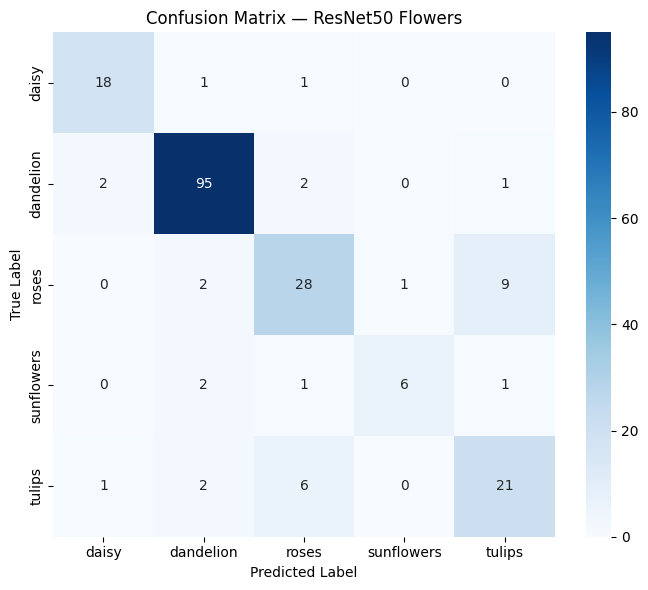

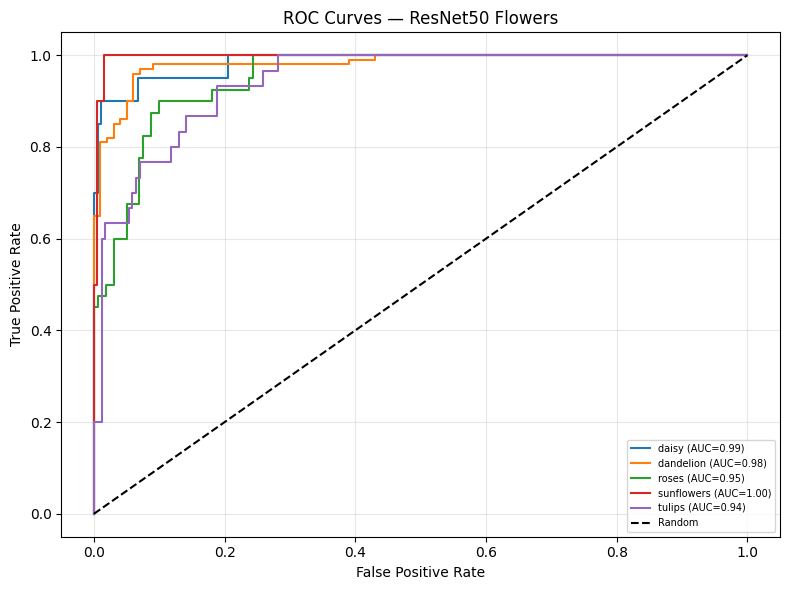


──────────────────────────────────────────────────
Model: EfficientNetB0 Flowers
──────────────────────────────────────────────────
  Accuracy:         0.8050
  Top-2 Accuracy:   0.9750
  Macro F1:         0.7440
  Micro F1:         0.8050
  Balanced Accuracy:0.7057
  G-Mean:           0.6801
  ROC-AUC (macro):  0.9675
  PR-AUC (macro):   0.8726
  Parameters:       4,708,008
  Inference Speed:  107.06 ms/image

              precision    recall  f1-score   support

       daisy       0.95      0.90      0.92        20
   dandelion       0.86      0.97      0.91       100
       roses       0.69      0.62      0.66        40
  sunflowers       1.00      0.50      0.67        10
      tulips       0.59      0.53      0.56        30

    accuracy                           0.81       200
   macro avg       0.82      0.71      0.74       200
weighted avg       0.80      0.81      0.80       200



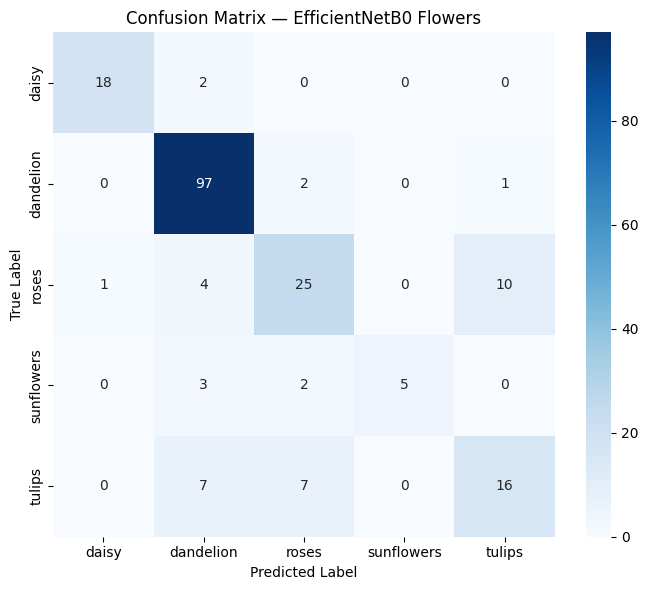

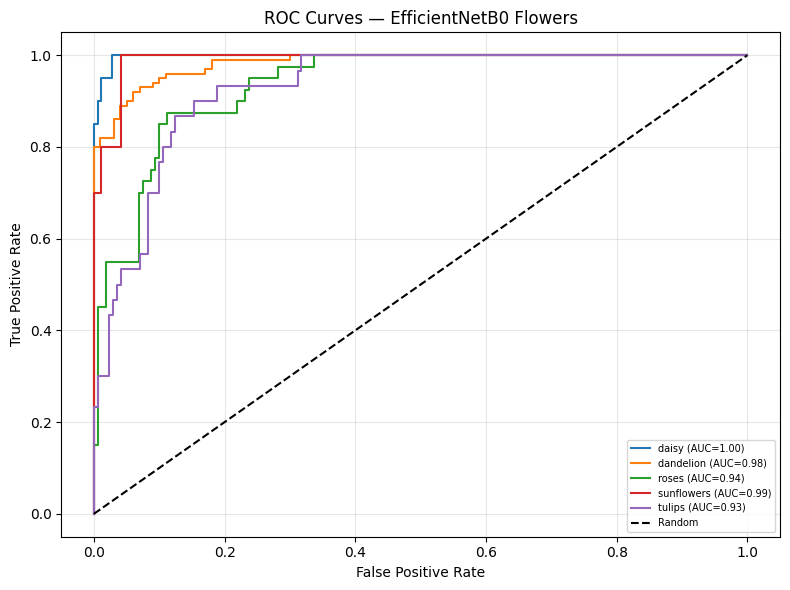


EXPERIMENT B: CIFAR-10 — ResNet50 vs EfficientNetB0

Training ResNet50 on CIFAR-10...
Epoch 1/30
330/330 ━━━━━━━━━━━━━━━━━━━━ 66s 168ms/step - accuracy: 0.9021 - loss: 0.4458 - top2_acc: 0.9650 - val_accuracy: 0.1365 - val_loss: 11.2569 - val_top2_acc: 0.1666 - learning_rate: 0.0010
Epoch 2/30
330/330 ━━━━━━━━━━━━━━━━━━━━ 41s 123ms/step - accuracy: 0.9653 - loss: 0.1742 - top2_acc: 0.9954 - val_accuracy: 0.1478 - val_loss: 13.6676 - val_top2_acc: 0.1687 - learning_rate: 0.0010
Epoch 3/30
330/330 ━━━━━━━━━━━━━━━━━━━━ 40s 120ms/step - accuracy: 0.9718 - loss: 0.1423 - top2_acc: 0.9969 - val_accuracy: 0.1585 - val_loss: 13.8145 - val_top2_acc: 0.1720 - learning_rate: 0.0010
Epoch 4/30
330/330 ━━━━━━━━━━━━━━━━━━━━ 39s 120ms/step - accuracy: 0.9752 - loss: 0.1283 - top2_acc: 0.9981 - val_accuracy: 0.1521 - val_loss: 13.1687 - val_top2_acc: 0.1693 - learning_rate: 0.0010
Epoch 5/30
330/330 ━━━━━━━━━━━━━━━━━━━━ 39s 119ms/step - accuracy: 0.9832 - loss: 0.0995 - top2_acc: 0.9991 - val_accurac

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


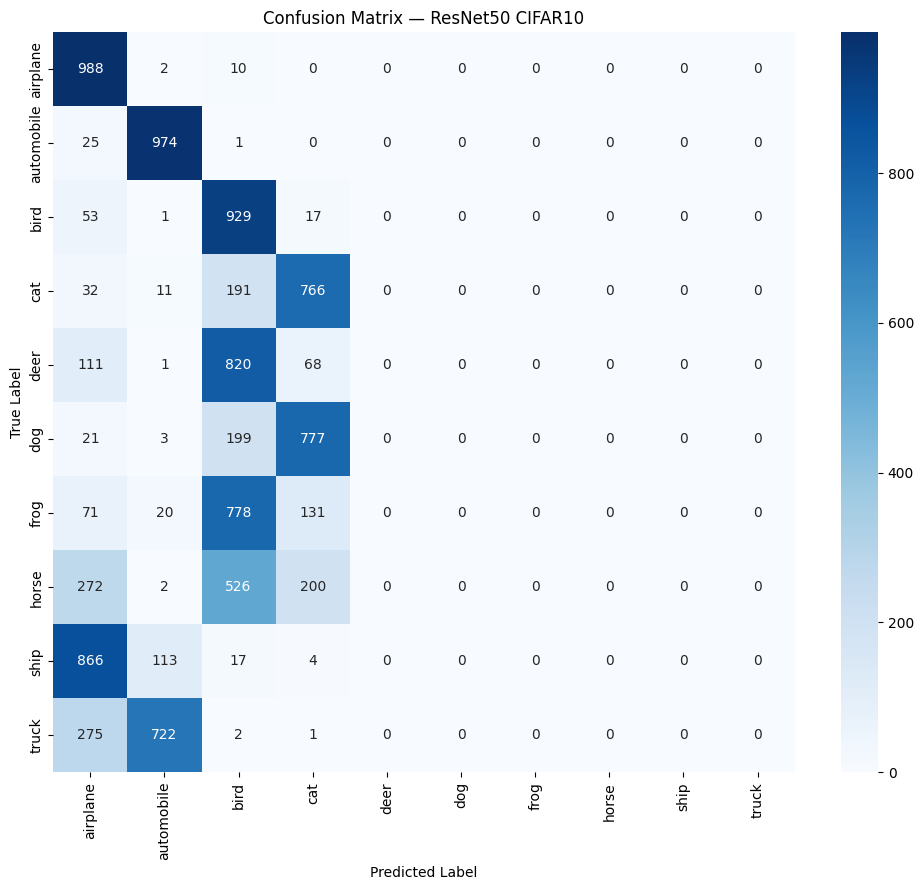

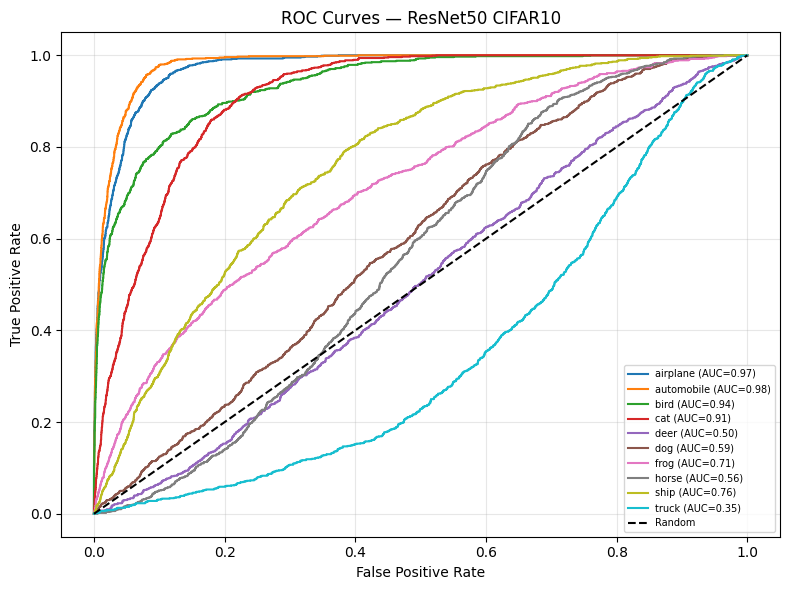


──────────────────────────────────────────────────
Model: EfficientNetB0 CIFAR10
──────────────────────────────────────────────────
  Accuracy:         0.3688
  Top-2 Accuracy:   0.3954
  Macro F1:         0.2205
  Micro F1:         0.3688
  Balanced Accuracy:0.3688
  G-Mean:           0.0000
  ROC-AUC (macro):  0.7582
  PR-AUC (macro):   0.3913
  Parameters:       4,710,573
  Inference Speed:  2.96 ms/image

              precision    recall  f1-score   support

    airplane       0.38      0.98      0.55      1000
  automobile       0.55      0.95      0.70      1000
        bird       0.24      0.93      0.39      1000
         cat       0.44      0.82      0.57      1000
        deer       0.00      0.00      0.00      1000
         dog       0.00      0.00      0.00      1000
        frog       0.00      0.00      0.00      1000
       horse       0.00      0.00      0.00      1000
        ship       0.00      0.00      0.00      1000
       truck       0.00      0.00      0.00  

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


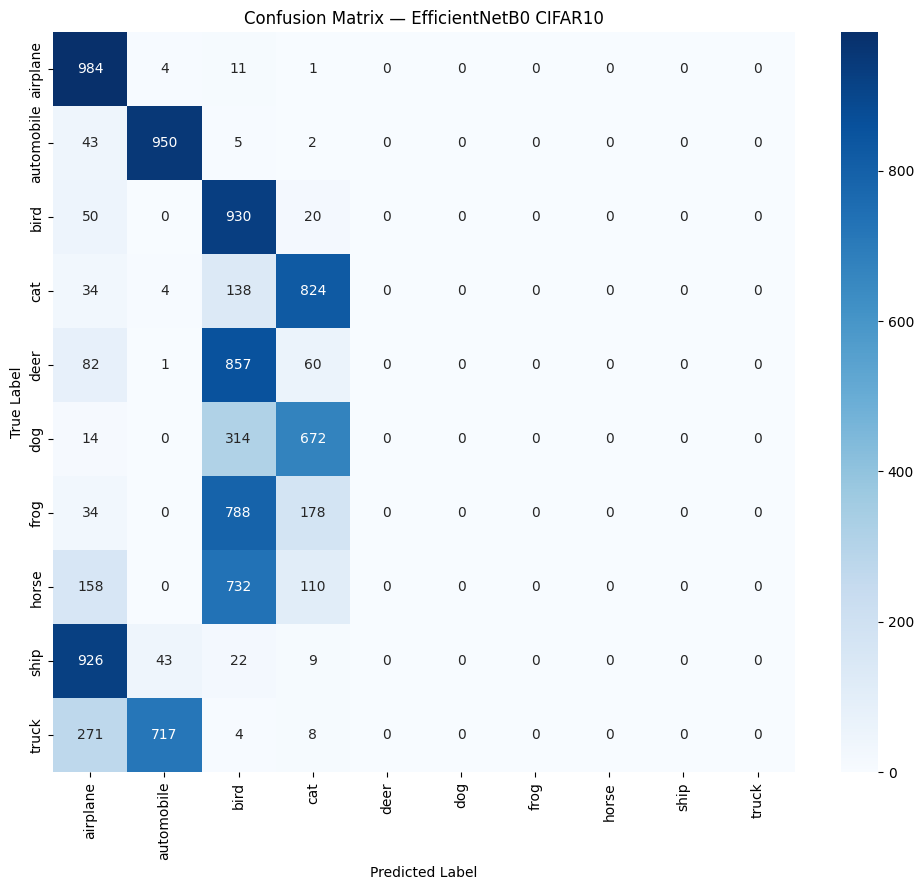

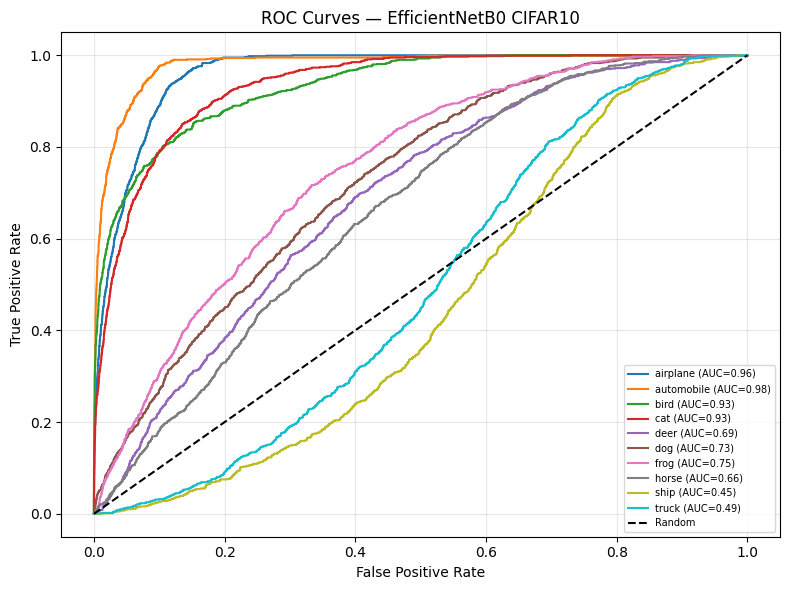


MASTER COMPARISON TABLE
                   Model    acc   top2  macro_f1  bal_acc  gmean  roc_auc  n_params   inf_ms
      ResNet50 (Flowers) 0.8400 0.9550    0.7840   0.7700 0.7587   0.9716  24639365  96.6580
EfficientNetB0 (Flowers) 0.8050 0.9750    0.7440   0.7057 0.6801   0.9675   4708008 107.0564
     ResNet50 (CIFAR-10) 0.3657 0.3958    0.2148   0.3657 0.0000   0.7275  24641930   4.1325
EfficientNetB0 (CIFAR10) 0.3688 0.3954    0.2205   0.3688 0.0000   0.7582   4710573   2.9648


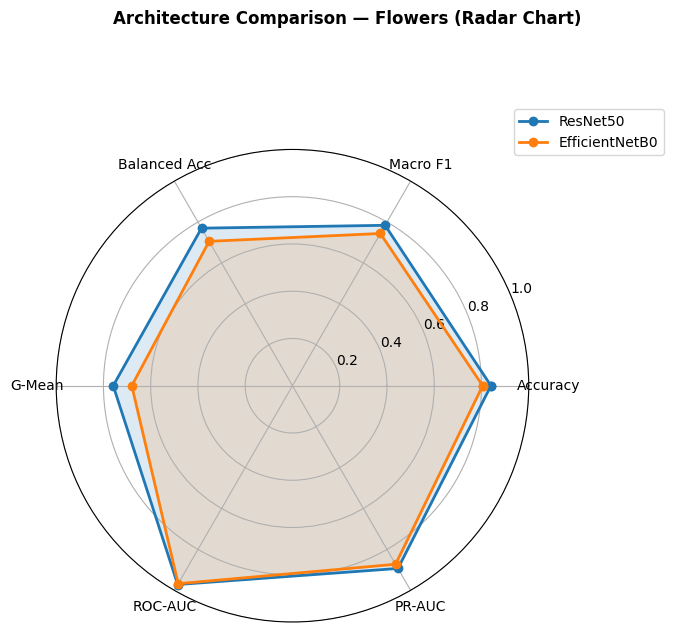

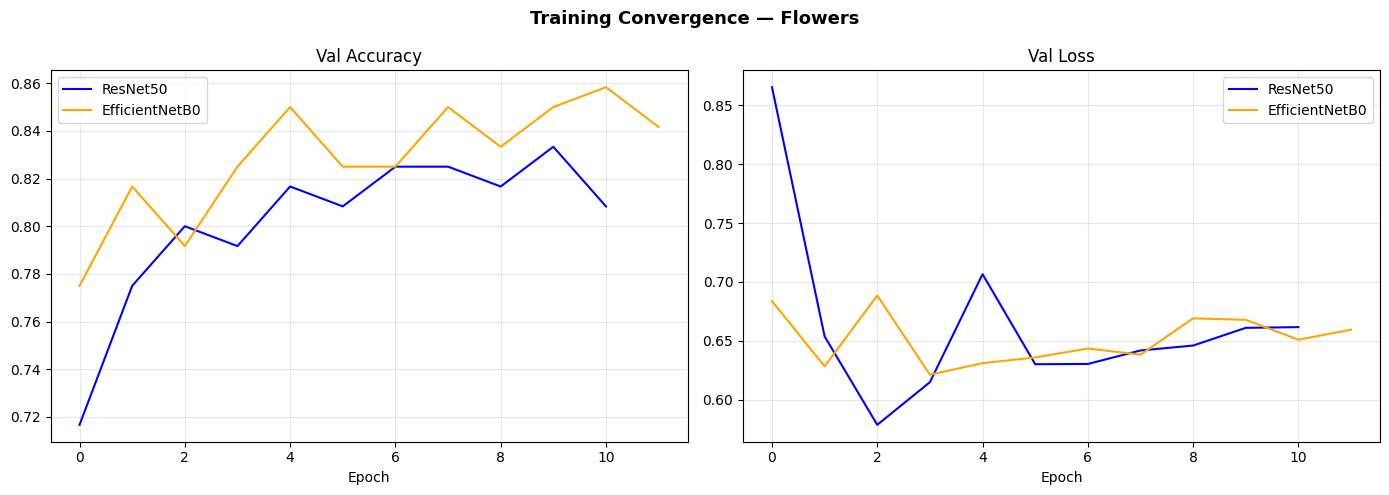


 Problem 3 complete!
   📊 Confusion matrices, ROC curves, radar chart, convergence plots saved.


In [4]:
# PROBLEM 3 — COMPARATIVE ARCHITECTURE ANALYSIS
# ResNet50 vs EfficientNetB0 on both datasets
# What this file covers:
#   ResNet50 (transfer learning) implementation
#   EfficientNetB0 (transfer learning) implementation
#   Overall accuracy, Top-2 accuracy
#   Precision, Recall, F1 (class-wise and macro)
#   Confusion matrices for both models
#   Parameter count and inference time (FLOPs proxy)
#   ROC-AUC and PR-AUC curves (OvR)
#   G-Mean and Balanced Accuracy

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, regularizers
import matplotlib.pyplot as plt
from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_auc_score, average_precision_score,
                             balanced_accuracy_score, f1_score)
from sklearn.preprocessing import label_binarize
import pandas as pd
import seaborn as sns
import time

# Load datasets
c10 = np.load('cifar10_imbalanced.npz')
fl  = np.load('flowers_imbalanced.npz')

x_train_c10, y_train_c10 = c10['x_train'], c10['y_train']
x_test_c10,  y_test_c10  = c10['x_test'],  c10['y_test']

x_train_fl,  y_train_fl  = fl['x_train'],  fl['y_train']
x_test_fl,   y_test_fl   = fl['x_test'],   fl['y_test']

CIFAR10_CLASSES = ['airplane','automobile','bird','cat','deer',
                   'dog','frog','horse','ship','truck']
FLOWER_CLASSES  = ['daisy','dandelion','roses','sunflowers','tulips']


# ARCHITECTURE BUILDERS

def build_resnet50(input_shape, num_classes, name="ResNet50"):
    """ResNet50 with ImageNet weights, frozen base, custom head."""
    inputs = tf.keras.Input(shape=input_shape)
    x      = layers.Resizing(224, 224)(inputs)
    x      = tf.keras.applications.resnet50.preprocess_input(x * 255.0)

    base   = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_tensor=x)
    base.trainable = False

    x = base.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=x, name=name)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy', tf.keras.metrics.SparseTopKCategoricalAccuracy(k=2, name='top2_acc')]
    )
    return model


def build_efficientnetb0(input_shape, num_classes, name="EfficientNetB0"):
    """EfficientNetB0 with ImageNet weights, frozen base, custom head."""
    inputs = tf.keras.Input(shape=input_shape)
    x      = layers.Resizing(224, 224)(inputs)
    x      = tf.keras.applications.efficientnet.preprocess_input(x * 255.0)

    base   = tf.keras.applications.EfficientNetB0(include_top=False, weights='imagenet', input_tensor=x)
    base.trainable = False

    x = base.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=x, name=name)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy', tf.keras.metrics.SparseTopKCategoricalAccuracy(k=2, name='top2_acc')]
    )
    return model


CALLBACKS = [
    callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
]
EPOCHS     = 30
BATCH_SIZE = 32


# UTILITY: FULL EVALUATION SUITE

def full_evaluation(model, x_test, y_test, class_names, model_name):
    """
    Comprehensive evaluation returning all metrics for comparison.
    Returns dict with all scores + plots confusion matrix + ROC curves.
    """
    num_classes = len(class_names)

    # Time inference speed
    start = time.time()
    y_probs = model.predict(x_test, batch_size=64, verbose=0)
    elapsed = time.time() - start
    inf_time_ms = (elapsed / len(x_test)) * 1000  # ms per image

    y_pred = np.argmax(y_probs, axis=1)

    # Basic metrics
    loss, acc, top2 = model.evaluate(x_test, y_test, verbose=0)
    macro_f1  = f1_score(y_test, y_pred, average='macro')
    micro_f1  = f1_score(y_test, y_pred, average='micro')
    bal_acc   = balanced_accuracy_score(y_test, y_pred)

    # G-Mean (geometric mean of per-class recall)
    from sklearn.metrics import recall_score
    per_class_recall = recall_score(y_test, y_pred, average=None)
    gmean = np.exp(np.mean(np.log(np.clip(per_class_recall, 1e-10, None))))

    # ROC-AUC (One vs Rest)
    y_bin    = label_binarize(y_test, classes=list(range(num_classes)))
    roc_auc  = roc_auc_score(y_bin, y_probs, average='macro', multi_class='ovr')
    pr_auc   = np.mean([average_precision_score(y_bin[:, i], y_probs[:, i])
                        for i in range(num_classes)])

    # Parameter count
    n_params = model.count_params()

    print(f"\n{'─'*50}")
    print(f"Model: {model_name}")
    print(f"{'─'*50}")
    print(f"  Accuracy:         {acc:.4f}")
    print(f"  Top-2 Accuracy:   {top2:.4f}")
    print(f"  Macro F1:         {macro_f1:.4f}")
    print(f"  Micro F1:         {micro_f1:.4f}")
    print(f"  Balanced Accuracy:{bal_acc:.4f}")
    print(f"  G-Mean:           {gmean:.4f}")
    print(f"  ROC-AUC (macro):  {roc_auc:.4f}")
    print(f"  PR-AUC (macro):   {pr_auc:.4f}")
    print(f"  Parameters:       {n_params:,}")
    print(f"  Inference Speed:  {inf_time_ms:.2f} ms/image")

    print("\n" + classification_report(y_test, y_pred, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(max(7, num_classes), max(6, num_classes-1)))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix — {model_name}')
    plt.ylabel('True Label'); plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig(f"cm_{model_name.replace(' ', '_')}.png", dpi=150)
    plt.show()

    # ROC Curves (all classes in one plot)
    from sklearn.metrics import roc_curve
    plt.figure(figsize=(8, 6))
    for i, cls in enumerate(class_names):
        fpr, tpr, _ = roc_curve(y_bin[:, i], y_probs[:, i])
        auc_i       = roc_auc_score(y_bin[:, i], y_probs[:, i])
        plt.plot(fpr, tpr, label=f'{cls} (AUC={auc_i:.2f})')
    plt.plot([0,1],[0,1], 'k--', label='Random')
    plt.title(f'ROC Curves — {model_name}')
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
    plt.legend(fontsize=7, loc='lower right'); plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f"roc_{model_name.replace(' ', '_')}.png", dpi=150)
    plt.show()

    return {
        'acc': acc, 'top2': top2, 'macro_f1': macro_f1, 'micro_f1': micro_f1,
        'bal_acc': bal_acc, 'gmean': gmean, 'roc_auc': roc_auc, 'pr_auc': pr_auc,
        'n_params': n_params, 'inf_ms': inf_time_ms
    }


# EXPERIMENT A: ResNet50 vs EfficientNetB0 on FLOWERS
print("\n" + "="*60)
print("EXPERIMENT A: Flowers Dataset — ResNet50 vs EfficientNetB0")
print("="*60)

# --- ResNet50 on Flowers ---
print("\nTraining ResNet50 on Flowers...")
resnet_fl = build_resnet50((64, 64, 3), 5, name="ResNet50_Flowers")
hist_res_fl = resnet_fl.fit(
    x_train_fl, y_train_fl, epochs=EPOCHS, batch_size=BATCH_SIZE,
    validation_split=0.15, callbacks=CALLBACKS, verbose=1
)

# --- EfficientNetB0 on Flowers ---
print("\nTraining EfficientNetB0 on Flowers...")
effnet_fl = build_efficientnetb0((64, 64, 3), 5, name="EfficientNetB0_Flowers")
hist_eff_fl = effnet_fl.fit(
    x_train_fl, y_train_fl, epochs=EPOCHS, batch_size=BATCH_SIZE,
    validation_split=0.15, callbacks=CALLBACKS, verbose=1
)

# Evaluate both
print("\n" + "="*60)
print("EVALUATION — FLOWERS")
metrics_res_fl  = full_evaluation(resnet_fl,  x_test_fl, y_test_fl, FLOWER_CLASSES, "ResNet50 Flowers")
metrics_eff_fl  = full_evaluation(effnet_fl,  x_test_fl, y_test_fl, FLOWER_CLASSES, "EfficientNetB0 Flowers")


# EXPERIMENT B: ResNet50 vs EfficientNetB0 on CIFAR-10
print("\n" + "="*60)
print("EXPERIMENT B: CIFAR-10 — ResNet50 vs EfficientNetB0")
print("="*60)

print("\nTraining ResNet50 on CIFAR-10...")
resnet_c10 = build_resnet50((32, 32, 3), 10, name="ResNet50_CIFAR10")
hist_res_c10 = resnet_c10.fit(
    x_train_c10, y_train_c10, epochs=EPOCHS, batch_size=BATCH_SIZE,
    validation_split=0.15, callbacks=CALLBACKS, verbose=1
)

print("\nTraining EfficientNetB0 on CIFAR-10...")
effnet_c10 = build_efficientnetb0((32, 32, 3), 10, name="EfficientNetB0_CIFAR10")
hist_eff_c10 = effnet_c10.fit(
    x_train_c10, y_train_c10, epochs=EPOCHS, batch_size=BATCH_SIZE,
    validation_split=0.15, callbacks=CALLBACKS, verbose=1
)

print("\n" + "="*60)
print("EVALUATION — CIFAR-10")
metrics_res_c10 = full_evaluation(resnet_c10,  x_test_c10, y_test_c10, CIFAR10_CLASSES, "ResNet50 CIFAR10")
metrics_eff_c10 = full_evaluation(effnet_c10,  x_test_c10, y_test_c10, CIFAR10_CLASSES, "EfficientNetB0 CIFAR10")



# MASTER COMPARISON TABLE
print("\n" + "="*70)
print("MASTER COMPARISON TABLE")
print("="*70)

comparison = pd.DataFrame([
    {'Model': 'ResNet50 (Flowers)',      **metrics_res_fl},
    {'Model': 'EfficientNetB0 (Flowers)',**metrics_eff_fl},
    {'Model': 'ResNet50 (CIFAR-10)',     **metrics_res_c10},
    {'Model': 'EfficientNetB0 (CIFAR10)',**metrics_eff_c10},
])

cols_show = ['Model','acc','top2','macro_f1','bal_acc','gmean','roc_auc','n_params','inf_ms']
print(comparison[cols_show].to_string(index=False, float_format='{:.4f}'.format))


# Radar chart — compare architectures across metrics (Flowers only)
import matplotlib.patches as mpatches
from matplotlib.patches import FancyArrowPatch

metrics_list = ['acc','macro_f1','bal_acc','gmean','roc_auc','pr_auc']
labels       = ['Accuracy','Macro F1','Balanced Acc','G-Mean','ROC-AUC','PR-AUC']
N = len(metrics_list)

angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
angles += angles[:1]

fig, ax = plt.subplots(figsize=(7, 7), subplot_kw=dict(polar=True))
fig.suptitle("Architecture Comparison — Flowers (Radar Chart)", fontsize=12, fontweight='bold')

for model_name, metrics in [("ResNet50", metrics_res_fl), ("EfficientNetB0", metrics_eff_fl)]:
    vals   = [metrics[m] for m in metrics_list]
    vals  += vals[:1]
    ax.plot(angles, vals, 'o-', linewidth=2, label=model_name)
    ax.fill(angles, vals, alpha=0.15)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels, fontsize=10)
ax.set_ylim(0, 1)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.tight_layout()
plt.savefig("radar_comparison_flowers.png", dpi=150, bbox_inches='tight')
plt.show()

# Training curves overlay
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle("Training Convergence — Flowers", fontsize=13, fontweight='bold')

for hist, label, color in [(hist_res_fl, 'ResNet50', 'blue'), (hist_eff_fl, 'EfficientNetB0', 'orange')]:
    axes[0].plot(hist.history['val_accuracy'], label=label, color=color)
    axes[1].plot(hist.history['val_loss'],     label=label, color=color)

axes[0].set_title('Val Accuracy'); axes[0].set_xlabel('Epoch'); axes[0].legend(); axes[0].grid(True, alpha=0.3)
axes[1].set_title('Val Loss');     axes[1].set_xlabel('Epoch'); axes[1].legend(); axes[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("convergence_arch_comparison.png", dpi=150)
plt.show()

print("\n Problem 3 complete!")
print("   📊 Confusion matrices, ROC curves, radar chart, convergence plots saved.")

Train: (12406, 32, 32, 3) | Class counts: [5000 2997 1796 1077  645  387  232  139   83   50]
Class weights (min=0.25, max=24.81)

SECTION A: LOSS FUNCTION EXPERIMENTS

──────────────────────────────────────────────────
Experiment: CE (Baseline)
──────────────────────────────────────────────────
  Best val_acc:      0.1381  (epoch 8)
  Macro F1:          0.0210
  Balanced Accuracy: 0.1012
  Minority Recall:   0.0000

──────────────────────────────────────────────────
Experiment: Weighted CE
──────────────────────────────────────────────────
  Best val_acc:      0.1510  (epoch 8)
  Macro F1:          0.0521
  Balanced Accuracy: 0.1521
  Minority Recall:   0.0000

──────────────────────────────────────────────────
Experiment: Focal Loss (γ=0.5)
──────────────────────────────────────────────────
  Best val_acc:      0.1376  (epoch 7)
  Macro F1:          0.0321
  Balanced Accuracy: 0.1082
  Minority Recall:   0.0000

──────────────────────────────────────────────────
Experiment: Focal Los

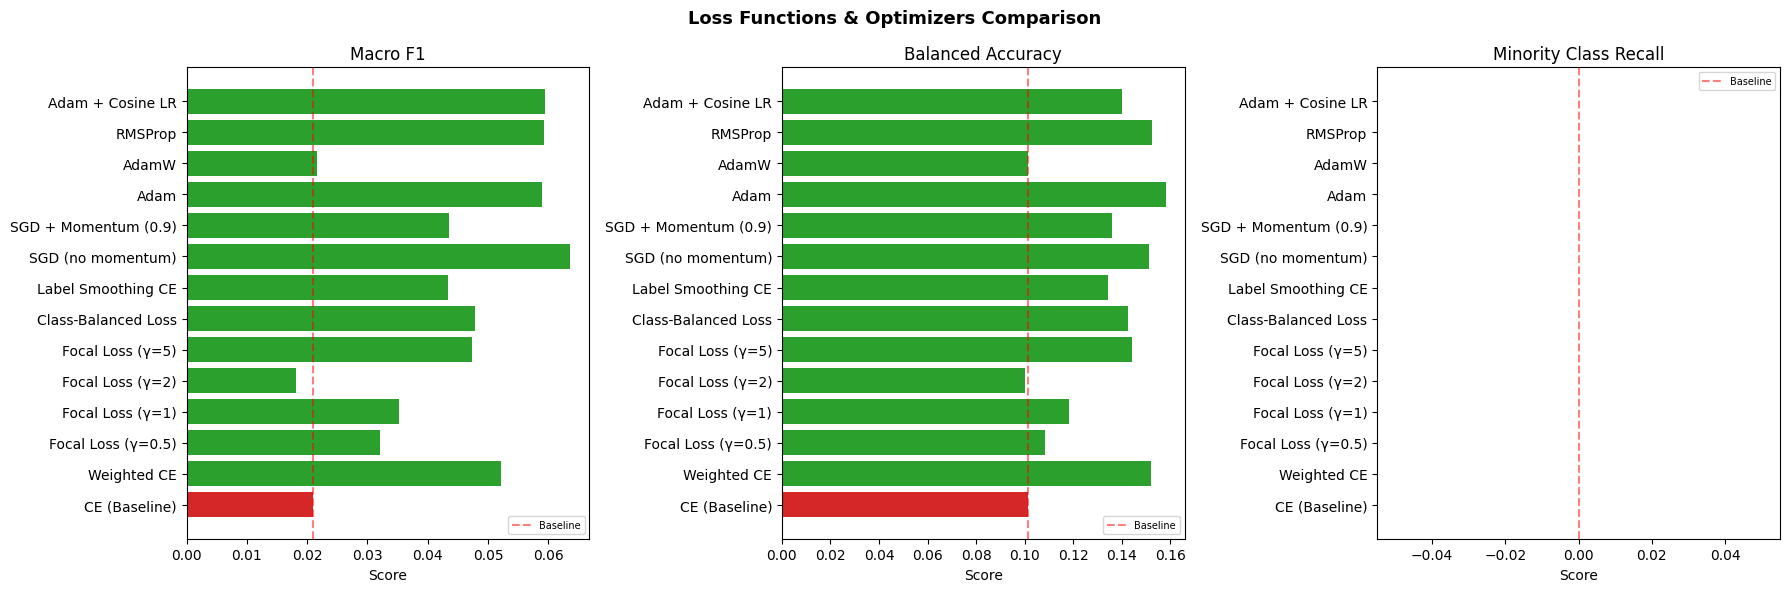

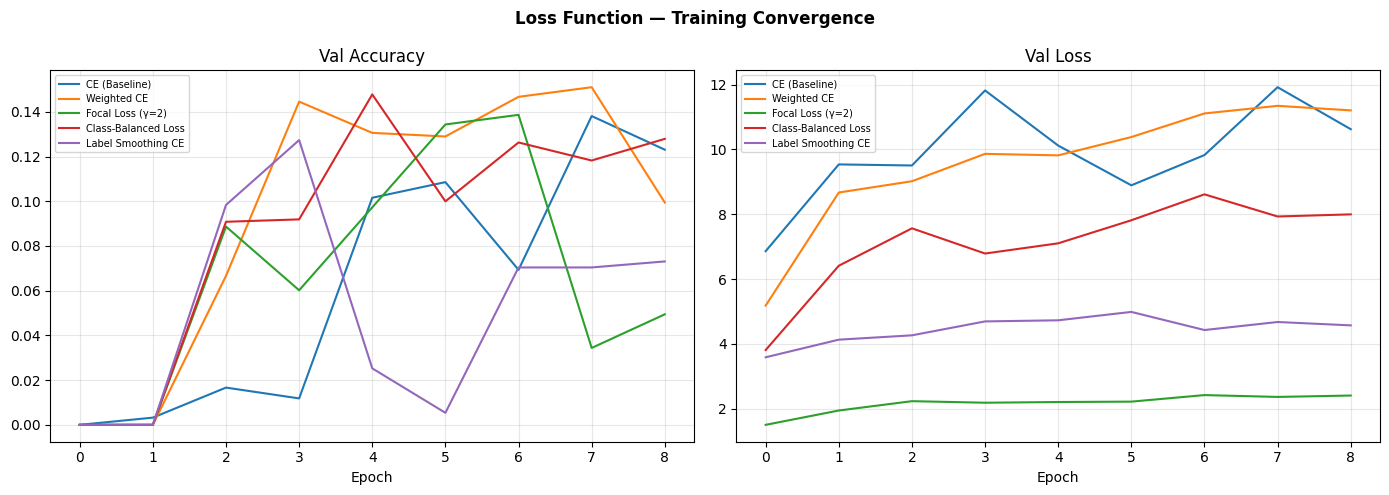

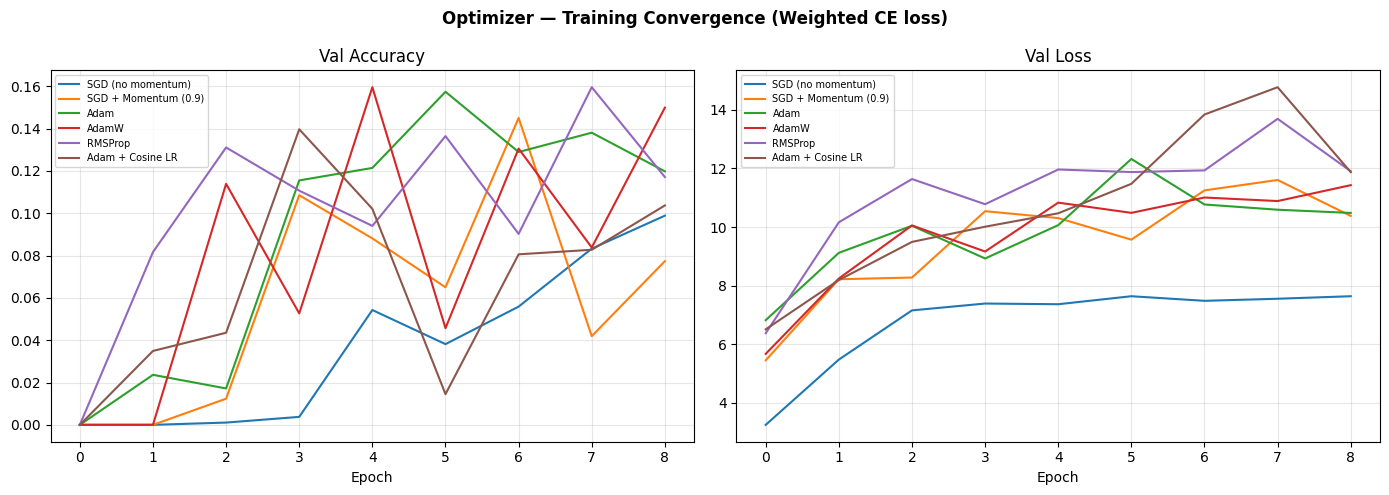


 Problem 4 complete!
   p4_results.csv — full results table
   p4_metric_comparison.png
   p4_loss_convergence.png
   p4_optimizer_convergence.png


In [1]:
# PROBLEM 4 — LOSS FUNCTION & OPTIMIZATION CHALLENGE
# Compare loss functions and optimizers on imbalanced CIFAR-10
# Loss Functions:
#   Cross-Entropy (baseline)
#   Weighted Cross-Entropy
#   Focal Loss (gamma = 0.5, 1, 2, 5)
#   Class-Balanced Loss
#   Label Smoothing Cross-Entropy
# Optimizers:
#   SGD (no momentum), SGD (with momentum)
#   Adam, AdamW, RMSProp
# Analysis:
#   Convergence speed
#   Minority class recall
#   Overfitting behavior
#   Learning rate scheduling impact

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, regularizers
from sklearn.metrics import f1_score, balanced_accuracy_score, recall_score
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import pandas as pd

# Load CIFAR-10 imbalanced
data = np.load('cifar10_imbalanced.npz')
x_train, y_train = data['x_train'], data['y_train']
x_test,  y_test  = data['x_test'],  data['y_test']

CLASSES     = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
NUM_CLASSES = 10

print(f"Train: {x_train.shape} | Class counts: {np.bincount(y_train)}")

# PRECOMPUTE WEIGHTS (used by multiple loss functions)
class_counts = np.bincount(y_train)
classes_arr  = np.unique(y_train)
weights_arr  = compute_class_weight('balanced', classes=classes_arr, y=y_train)
cw_dict      = dict(zip(classes_arr, weights_arr))
print(f"Class weights (min={weights_arr.min():.2f}, max={weights_arr.max():.2f})")


# CUSTOM LOSS FUNCTIONS

class FocalLoss(tf.keras.losses.Loss):
    """
    Focal Loss: FL = -alpha * (1-p_t)^gamma * log(p_t)
    gamma=0: reduces to cross-entropy
    gamma>0: focuses on hard/misclassified examples
    """
    def __init__(self, gamma=2.0, alpha=0.25, name='focal_loss'):
        super().__init__(name=f'{name}_gamma{gamma}')
        self.gamma = gamma
        self.alpha = alpha

    def call(self, y_true, y_pred):
        y_true    = tf.cast(tf.reshape(y_true, [-1]), tf.int32)
        y_true_oh = tf.one_hot(y_true, depth=NUM_CLASSES)
        y_pred    = tf.clip_by_value(y_pred, 1e-7, 1.0 - 1e-7)

        ce        = -tf.reduce_sum(y_true_oh * tf.math.log(y_pred), axis=-1)
        p_t       =  tf.reduce_sum(y_true_oh * y_pred, axis=-1)
        focal_w   = tf.pow(1.0 - p_t, self.gamma)
        return tf.reduce_mean(self.alpha * focal_w * ce)


class ClassBalancedLoss(tf.keras.losses.Loss):
    """
    Class-Balanced Loss (Cui et al., 2019).
    Weights each class by effective number of samples:
      E_n = (1 - beta^n) / (1 - beta), where beta = (N-1)/N
    This gives diminishing returns to adding more majority samples.
    """
    def __init__(self, samples_per_cls, beta=0.9999, name='cb_loss'):
        super().__init__(name=name)
        effective = (1 - beta ** samples_per_cls) / (1 - beta)
        cb_weights = 1.0 / effective
        self.weights = tf.constant(
            cb_weights / cb_weights.sum() * len(samples_per_cls),
            dtype=tf.float32
        )

    def call(self, y_true, y_pred):
        y_true    = tf.cast(tf.reshape(y_true, [-1]), tf.int32)
        y_true_oh = tf.one_hot(y_true, depth=NUM_CLASSES)
        y_pred    = tf.clip_by_value(y_pred, 1e-7, 1.0 - 1e-7)

        # Per-sample weight = weight of true class
        sample_w  = tf.reduce_sum(y_true_oh * self.weights, axis=-1)
        ce        = -tf.reduce_sum(y_true_oh * tf.math.log(y_pred), axis=-1)
        return tf.reduce_mean(sample_w * ce)


class LabelSmoothingCE(tf.keras.losses.Loss):
    """
    Label Smoothing Cross-Entropy.
    Instead of hard 0/1 targets, use smoothed targets:
      y_smooth = (1 - eps) * y_hard + eps / K
    This prevents overconfident predictions and acts as regularizer.
    """
    def __init__(self, smoothing=0.1, name='label_smooth_ce'):
        super().__init__(name=name)
        self.smoothing  = smoothing
        self.num_cls    = NUM_CLASSES

    def call(self, y_true, y_pred):
        y_true    = tf.cast(tf.reshape(y_true, [-1]), tf.int32)
        y_true_oh = tf.one_hot(y_true, depth=self.num_cls)

        # Smooth the labels
        y_smooth  = (1 - self.smoothing) * y_true_oh + self.smoothing / self.num_cls
        y_pred    = tf.clip_by_value(y_pred, 1e-7, 1.0 - 1e-7)

        ce        = -tf.reduce_sum(y_smooth * tf.math.log(y_pred), axis=-1)
        return tf.reduce_mean(ce)


# BASE MODEL & TRAINING INFRASTRUCTURE

def build_base_model():
    """Same compact CNN for all experiments."""
    model = models.Sequential([
        layers.Input(shape=(32, 32, 3)),
        layers.Conv2D(32, 3, padding='same'), layers.BatchNormalization(), layers.Activation('relu'),
        layers.Conv2D(32, 3, padding='same'), layers.BatchNormalization(), layers.Activation('relu'),
        layers.MaxPooling2D(), layers.Dropout(0.25),

        layers.Conv2D(64, 3, padding='same'), layers.BatchNormalization(), layers.Activation('relu'),
        layers.Conv2D(64, 3, padding='same'), layers.BatchNormalization(), layers.Activation('relu'),
        layers.MaxPooling2D(), layers.Dropout(0.30),

        layers.Conv2D(128, 3, padding='same'), layers.BatchNormalization(), layers.Activation('relu'),
        layers.GlobalAveragePooling2D(),

        layers.Dense(256, kernel_regularizer=regularizers.l2(1e-4)),
        layers.BatchNormalization(), layers.Activation('relu'), layers.Dropout(0.4),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    return model


def run_experiment(name, loss_fn, optimizer, x_train, y_train, x_test, y_test,
                   class_weight=None, lr_schedule=None, epochs=30, batch_size=64):
    """
    Train and evaluate one experiment configuration.
    Returns dict of metrics.
    """
    print(f"\n{'─'*50}")
    print(f"Experiment: {name}")
    print(f"{'─'*50}")

    model = build_base_model()
    model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

    cbs = [callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
           callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)]
    if lr_schedule:
        cbs.append(lr_schedule)

    history = model.fit(
        x_train, y_train,
        epochs=epochs, batch_size=batch_size,
        validation_split=0.15,
        class_weight=class_weight,
        callbacks=cbs,
        verbose=0   # quiet — we print summary at end
    )

    y_probs = model.predict(x_test, verbose=0)
    y_pred  = np.argmax(y_probs, axis=1)

    per_class_recall = recall_score(y_test, y_pred, average=None, zero_division=0)
    macro_f1         = f1_score(y_test, y_pred, average='macro', zero_division=0)
    bal_acc          = balanced_accuracy_score(y_test, y_pred)

    # Minority recall = recall of the 3 rarest classes
    minority_idx     = np.argsort(np.bincount(y_train))[:3]
    minority_recall  = per_class_recall[minority_idx].mean()

    val_accs = history.history['val_accuracy']

    print(f"  Best val_acc:      {max(val_accs):.4f}  (epoch {np.argmax(val_accs)+1})")
    print(f"  Macro F1:          {macro_f1:.4f}")
    print(f"  Balanced Accuracy: {bal_acc:.4f}")
    print(f"  Minority Recall:   {minority_recall:.4f}")

    return {
        'name': name, 'history': history,
        'macro_f1': macro_f1, 'bal_acc': bal_acc,
        'minority_recall': minority_recall,
        'best_val_acc': max(val_accs),
        'epochs_run': len(val_accs)
    }


# Store all results
all_results = []


# SECTION A: LOSS FUNCTION EXPERIMENTS (fixed optimizer = Adam)
print("\n" + "="*60)
print("SECTION A: LOSS FUNCTION EXPERIMENTS")
print("="*60)

adam_opt = tf.keras.optimizers.Adam(1e-3)

# 1. Cross-Entropy (baseline)
all_results.append(run_experiment(
    name="CE (Baseline)",
    loss_fn='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(1e-3),
    x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test
))

# 2. Weighted Cross-Entropy
all_results.append(run_experiment(
    name="Weighted CE",
    loss_fn='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(1e-3),
    x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test,
    class_weight=cw_dict   # ← only difference
))

# 3. Focal Loss — gamma = 0.5
all_results.append(run_experiment(
    name="Focal Loss (γ=0.5)",
    loss_fn=FocalLoss(gamma=0.5),
    optimizer=tf.keras.optimizers.Adam(1e-3),
    x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test
))

# 4. Focal Loss — gamma = 1
all_results.append(run_experiment(
    name="Focal Loss (γ=1)",
    loss_fn=FocalLoss(gamma=1.0),
    optimizer=tf.keras.optimizers.Adam(1e-3),
    x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test
))

# 5. Focal Loss — gamma = 2 (standard)
all_results.append(run_experiment(
    name="Focal Loss (γ=2)",
    loss_fn=FocalLoss(gamma=2.0),
    optimizer=tf.keras.optimizers.Adam(1e-3),
    x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test
))

# 6. Focal Loss — gamma = 5
all_results.append(run_experiment(
    name="Focal Loss (γ=5)",
    loss_fn=FocalLoss(gamma=5.0),
    optimizer=tf.keras.optimizers.Adam(1e-3),
    x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test
))

# 7. Class-Balanced Loss
all_results.append(run_experiment(
    name="Class-Balanced Loss",
    loss_fn=ClassBalancedLoss(samples_per_cls=class_counts.astype(np.float32)),
    optimizer=tf.keras.optimizers.Adam(1e-3),
    x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test
))

# 8. Label Smoothing CE
all_results.append(run_experiment(
    name="Label Smoothing CE",
    loss_fn=LabelSmoothingCE(smoothing=0.1),
    optimizer=tf.keras.optimizers.Adam(1e-3),
    x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test
))


# SECTION B: OPTIMIZER EXPERIMENTS (fixed loss = Weighted CE)
print("\n" + "="*60)
print("SECTION B: OPTIMIZER EXPERIMENTS (Weighted CE loss)")
print("="*60)

SHARED_LOSS = 'sparse_categorical_crossentropy'

# SGD — no momentum
all_results.append(run_experiment(
    name="SGD (no momentum)",
    loss_fn=SHARED_LOSS,
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test,
    class_weight=cw_dict
))

# SGD — with momentum
all_results.append(run_experiment(
    name="SGD + Momentum (0.9)",
    loss_fn=SHARED_LOSS,
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
    x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test,
    class_weight=cw_dict
))

# Adam
all_results.append(run_experiment(
    name="Adam",
    loss_fn=SHARED_LOSS,
    optimizer=tf.keras.optimizers.Adam(1e-3),
    x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test,
    class_weight=cw_dict
))

# AdamW (Adam + weight decay)
all_results.append(run_experiment(
    name="AdamW",
    loss_fn=SHARED_LOSS,
    optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-4),
    x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test,
    class_weight=cw_dict
))

# RMSProp
all_results.append(run_experiment(
    name="RMSProp",
    loss_fn=SHARED_LOSS,
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-3),
    x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test,
    class_weight=cw_dict
))

# Adam + Cosine LR Decay schedule
cosine_schedule = callbacks.LearningRateScheduler(
    lambda epoch, lr: 1e-3 * 0.5 * (1 + np.cos(np.pi * epoch / 30)),
    verbose=0
)
all_results.append(run_experiment(
    name="Adam + Cosine LR",
    loss_fn=SHARED_LOSS,
    optimizer=tf.keras.optimizers.Adam(1e-3),
    x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test,
    class_weight=cw_dict,
    lr_schedule=cosine_schedule
))

# FINAL SUMMARY TABLES & PLOTS
print("\n" + "="*70)
print("FINAL RESULTS TABLE")
print("="*70)

df = pd.DataFrame([{
    'Experiment': r['name'],
    'Macro F1':   round(r['macro_f1'], 4),
    'Bal. Acc':   round(r['bal_acc'], 4),
    'Minority Recall': round(r['minority_recall'], 4),
    'Best Val Acc': round(r['best_val_acc'], 4),
    'Epochs': r['epochs_run']
} for r in all_results])

print(df.sort_values('Macro F1', ascending=False).to_string(index=False))
df.to_csv("p4_results.csv", index=False)

# Plot 1: Metric comparison bar charts
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle("Loss Functions & Optimizers Comparison", fontsize=13, fontweight='bold')

for ax, metric, title in zip(axes,
    ['macro_f1', 'bal_acc', 'minority_recall'],
    ['Macro F1', 'Balanced Accuracy', 'Minority Class Recall']):

    vals   = [r[metric] for r in all_results]
    names  = [r['name'] for r in all_results]
    colors = ['#d62728' if i == 0 else '#2ca02c' for i in range(len(names))]

    ax.barh(names, vals, color=colors)
    ax.set_title(title)
    ax.set_xlabel("Score")
    ax.axvline(vals[0], color='red', linestyle='--', alpha=0.5, label='Baseline')
    ax.legend(fontsize=7)

plt.tight_layout()
plt.savefig("p4_metric_comparison.png", dpi=150, bbox_inches='tight')
plt.show()

# Plot 2: Convergence curves for loss function experiments
loss_exp_names = ["CE (Baseline)", "Weighted CE", "Focal Loss (γ=2)",
                  "Class-Balanced Loss", "Label Smoothing CE"]
loss_results   = [r for r in all_results if r['name'] in loss_exp_names]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle("Loss Function — Training Convergence", fontsize=12, fontweight='bold')

for r in loss_results:
    h = r['history'].history
    axes[0].plot(h['val_accuracy'], label=r['name'])
    axes[1].plot(h['val_loss'],     label=r['name'])

axes[0].set_title('Val Accuracy'); axes[0].set_xlabel('Epoch')
axes[0].legend(fontsize=7); axes[0].grid(True, alpha=0.3)

axes[1].set_title('Val Loss'); axes[1].set_xlabel('Epoch')
axes[1].legend(fontsize=7); axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("p4_loss_convergence.png", dpi=150)
plt.show()

# Plot 3: Convergence for optimizer experiments
opt_exp_names = ["SGD (no momentum)", "SGD + Momentum (0.9)",
                 "Adam", "AdamW", "RMSProp", "Adam + Cosine LR"]
opt_results   = [r for r in all_results if r['name'] in opt_exp_names]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle("Optimizer — Training Convergence (Weighted CE loss)", fontsize=12, fontweight='bold')

for r in opt_results:
    h = r['history'].history
    axes[0].plot(h['val_accuracy'], label=r['name'])
    axes[1].plot(h['val_loss'],     label=r['name'])

axes[0].set_title('Val Accuracy'); axes[0].set_xlabel('Epoch')
axes[0].legend(fontsize=7); axes[0].grid(True, alpha=0.3)

axes[1].set_title('Val Loss'); axes[1].set_xlabel('Epoch')
axes[1].legend(fontsize=7); axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("p4_optimizer_convergence.png", dpi=150)
plt.show()

print("\n Problem 4 complete!")
print("   p4_results.csv — full results table")
print("   p4_metric_comparison.png")
print("   p4_loss_convergence.png")
print("   p4_optimizer_convergence.png")

cifar10_imbalanced.npz already exists
flowers_imbalanced.npz already exists
 UMAP available
Training CNN on CIFAR-10 (P1 model not found)...
Epoch 1/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 21s 56ms/step - accuracy: 0.6125 - loss: 1.1424 - val_accuracy: 0.0000e+00 - val_loss: 7.1176 - learning_rate: 0.0010
Epoch 2/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7458 - loss: 0.6832 - val_accuracy: 0.0000e+00 - val_loss: 10.3037 - learning_rate: 0.0010
Epoch 3/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7876 - loss: 0.5625 - val_accuracy: 0.0365 - val_loss: 10.1861 - learning_rate: 0.0010
Epoch 4/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8174 - loss: 0.5039 - val_accuracy: 0.0580 - val_loss: 10.9623 - learning_rate: 0.0010
Epoch 5/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8389 - loss: 0.4443 - val_accuracy: 0.0661 - val_loss: 11.9335 - learning_rate: 5.0000e-04
Epoch 6/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8589 - loss: 0

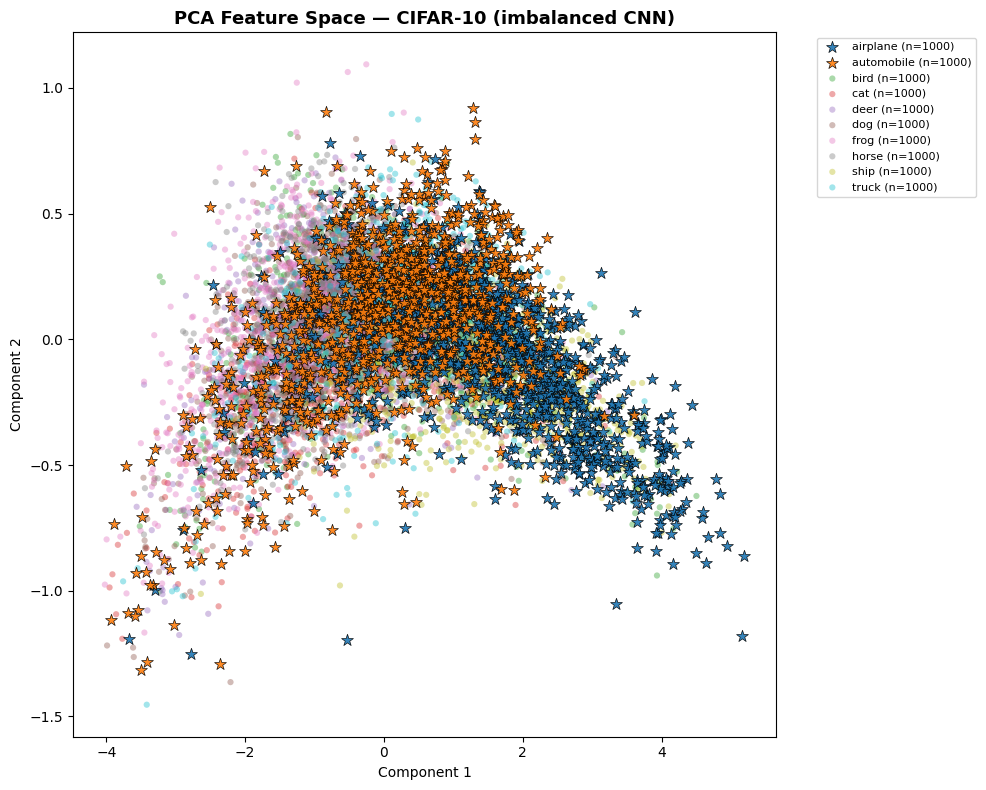

  Silhouette score: -0.1715  (range: -1 to 1, higher = better clustering)
Running PCA on Flowers features...
  Explained variance: 86.5%


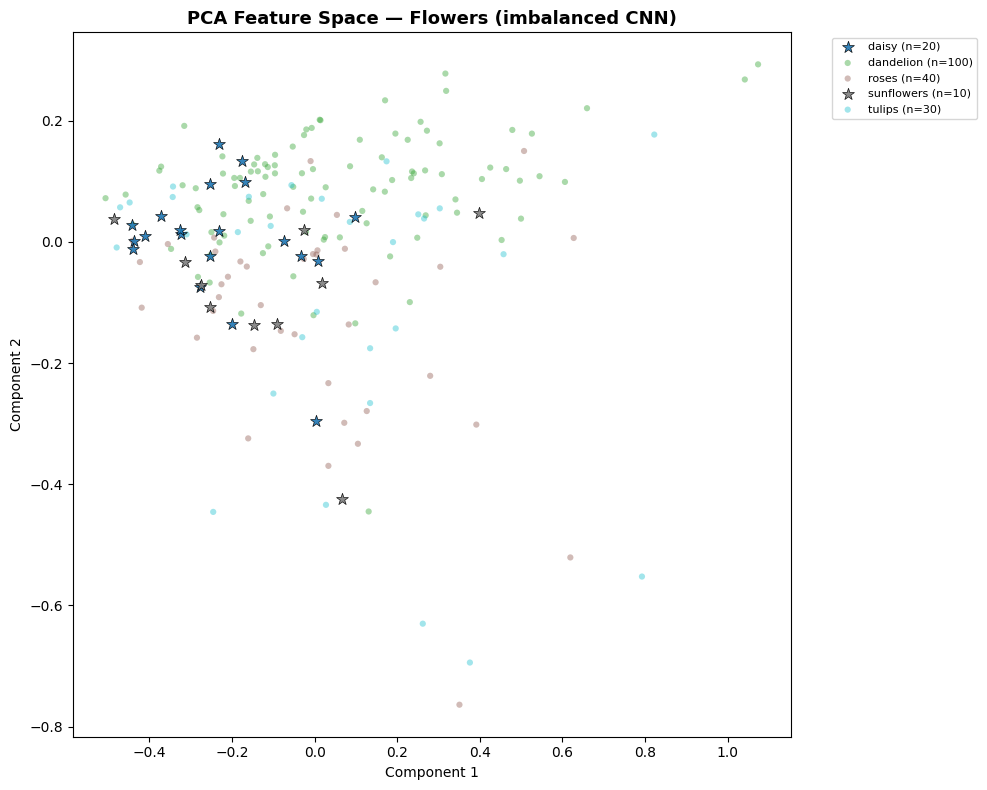

  Silhouette score: -0.1143  (range: -1 to 1, higher = better clustering)

3B. t-SNE — Non-linear Embedding
Running t-SNE on 3000 CIFAR-10 samples...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3000 samples in 0.001s...


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computed neighbors for 3000 samples in 0.184s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3000
[t-SNE] Computed conditional probabilities for sample 2000 / 3000
[t-SNE] Computed conditional probabilities for sample 3000 / 3000
[t-SNE] Mean sigma: 0.148958
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.478981
[t-SNE] KL divergence after 1000 iterations: 1.184488


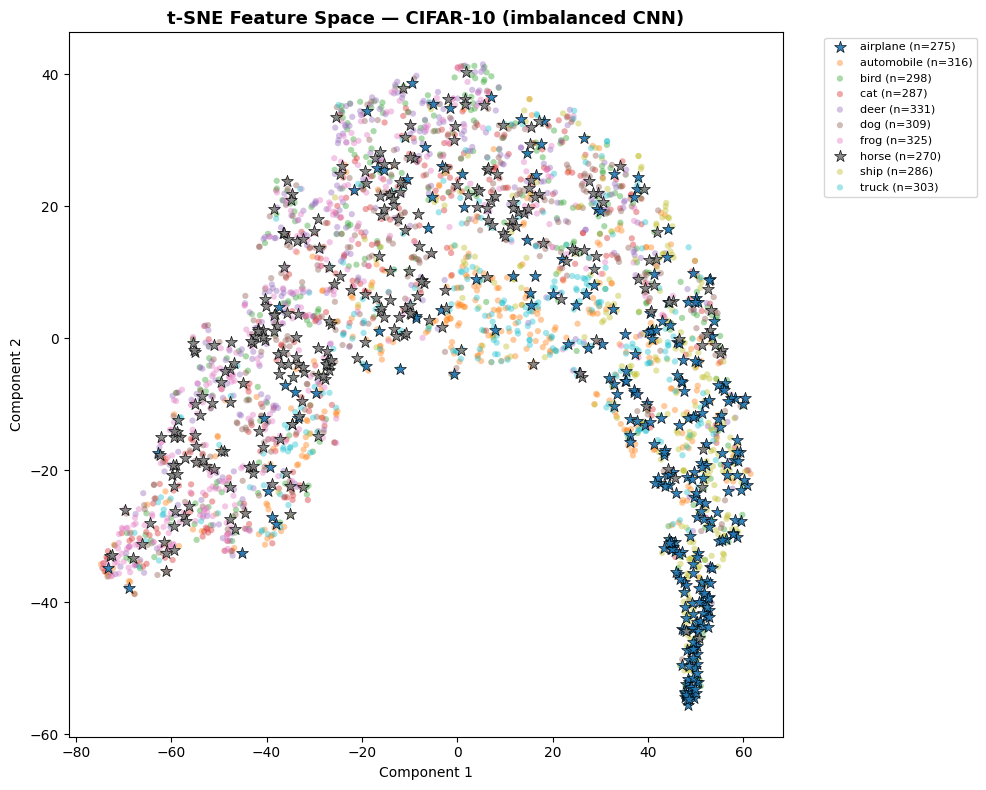

  Silhouette score: -0.1492  (range: -1 to 1, higher = better clustering)
Running t-SNE on 200 Flowers samples...
[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 200 samples in 0.000s...
[t-SNE] Computed neighbors for 200 samples in 0.004s...
[t-SNE] Computed conditional probabilities for sample 200 / 200
[t-SNE] Mean sigma: 0.100424


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.973804
[t-SNE] KL divergence after 1000 iterations: 0.386716


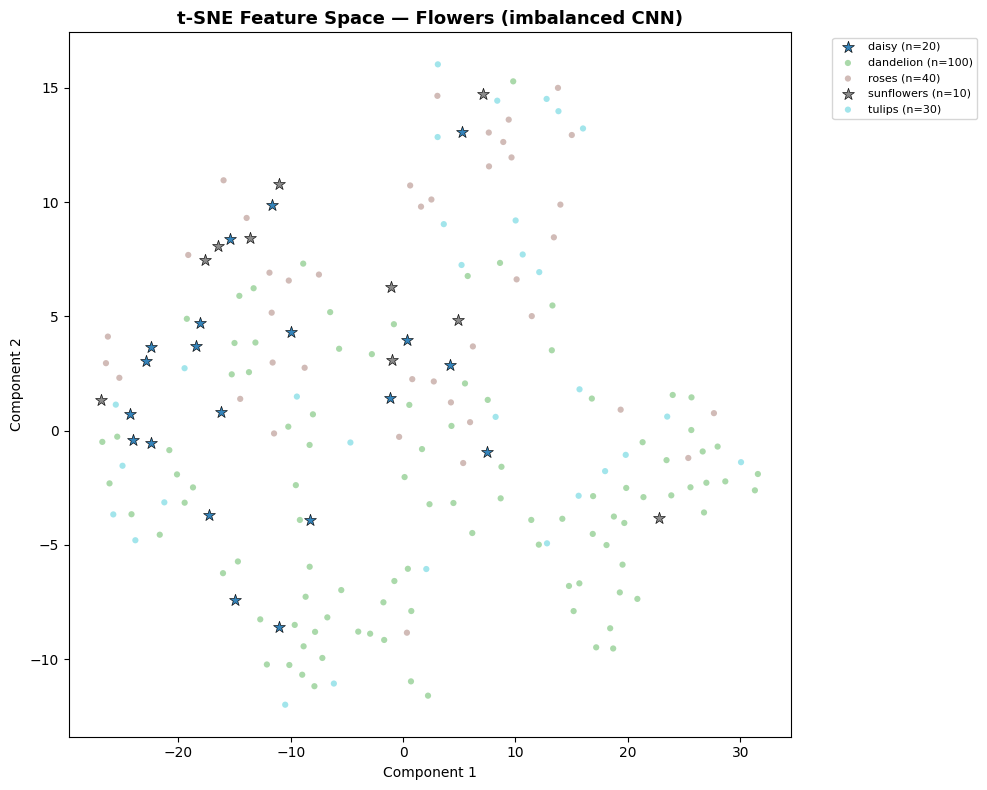

  Silhouette score: -0.1142  (range: -1 to 1, higher = better clustering)

3C. UMAP — Faster & better global structure than t-SNE
Running UMAP on CIFAR-10...


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


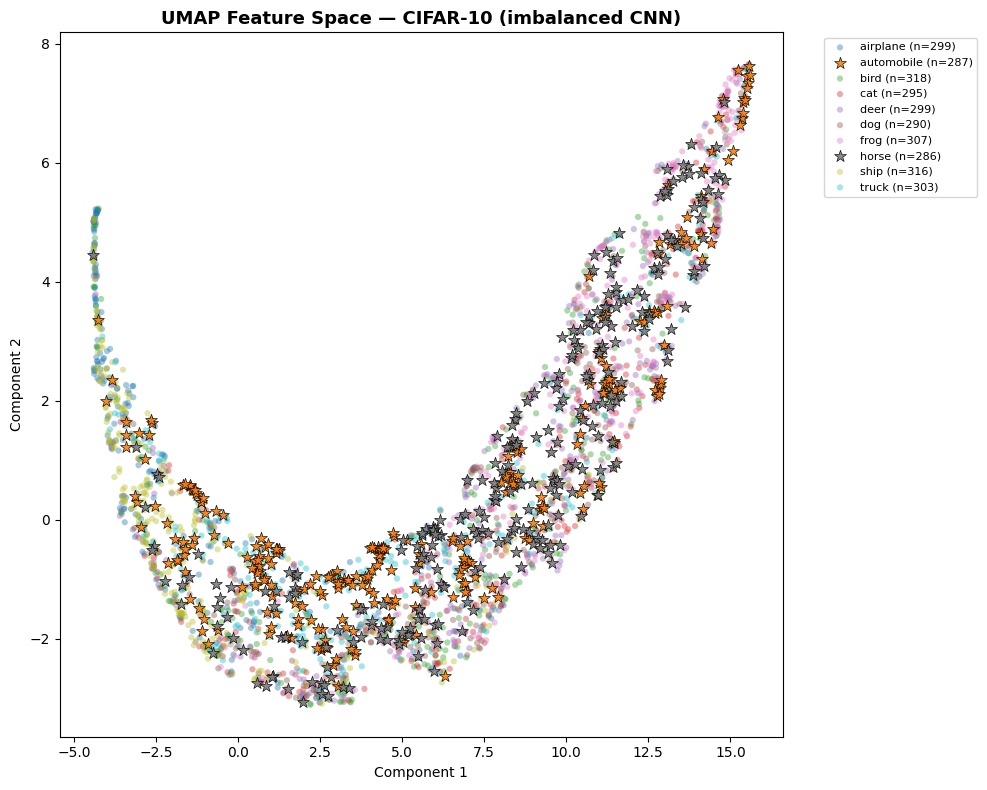

  Silhouette score: -0.1928  (range: -1 to 1, higher = better clustering)
Running UMAP on Flowers...


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


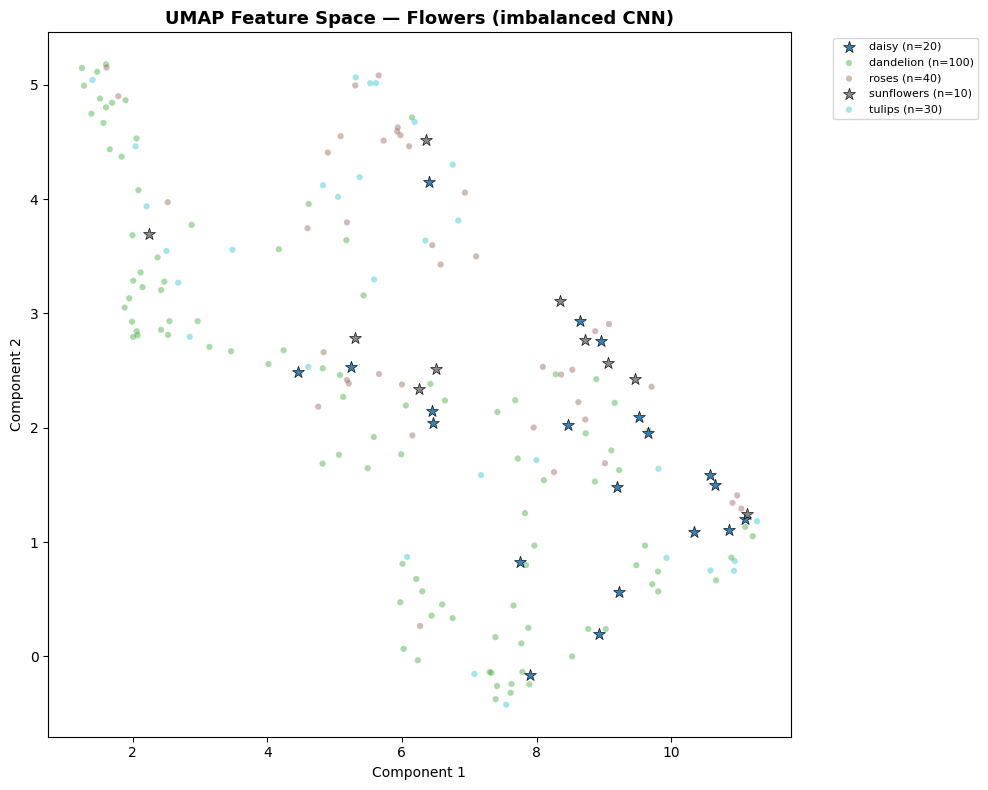

  Silhouette score: -0.1420  (range: -1 to 1, higher = better clustering)
Last Conv2D layer: conv2d_24
Generating Grad-CAM visualizations...


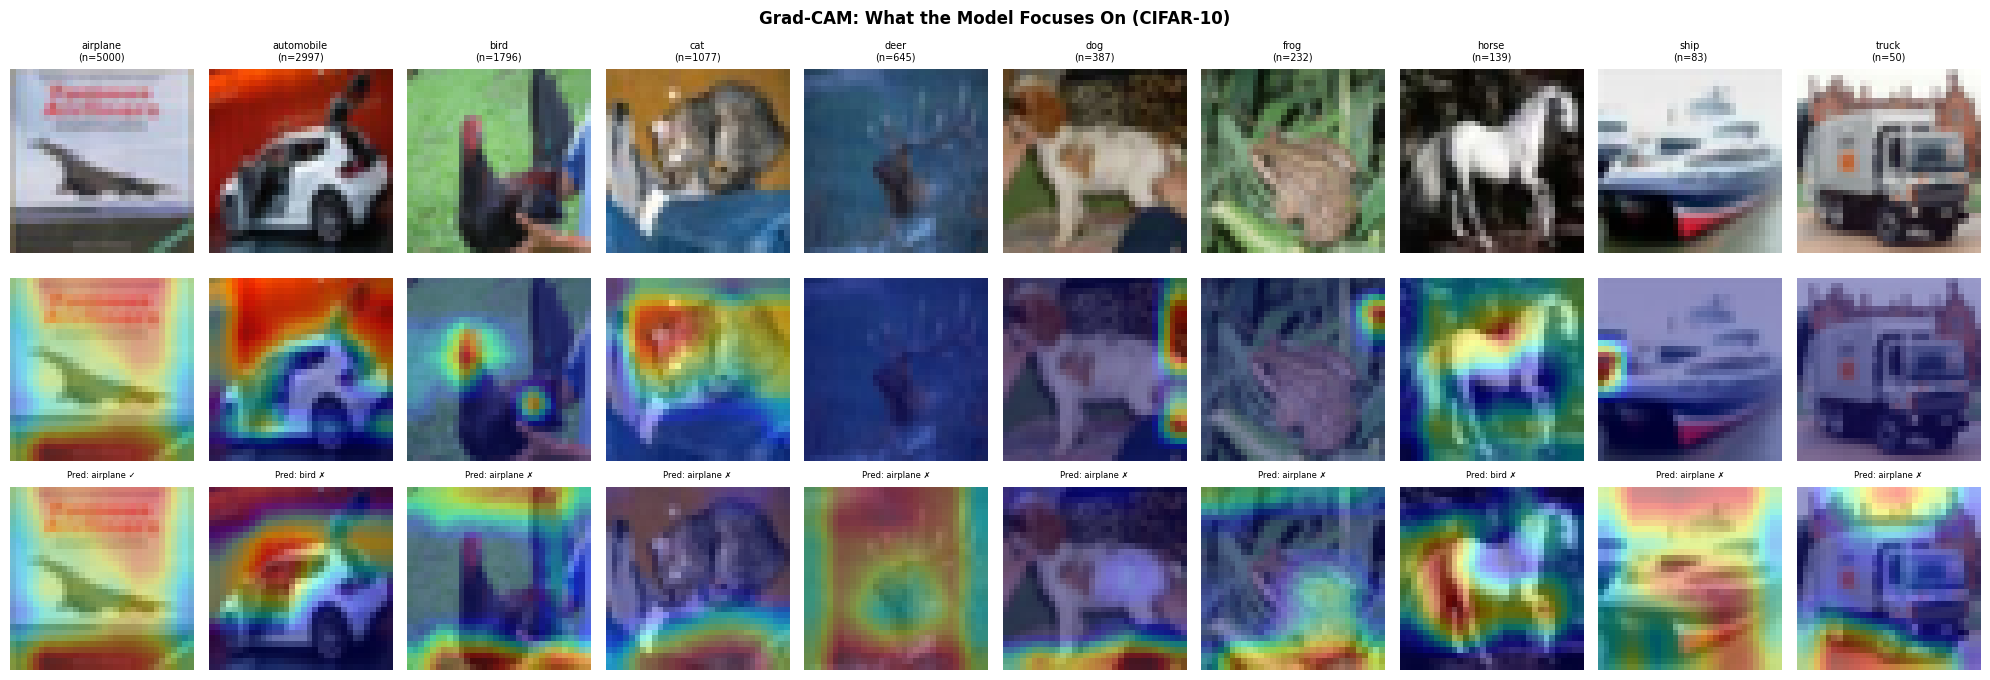


ANALYSIS: How Imbalance Affects Feature Space Quality

Per-class silhouette scores (t-SNE space) — higher = better cluster:
  airplane     (n= 275): -0.0812
  automobile   (n= 316): -0.1990
  bird         (n= 298): -0.2822
  cat          (n= 287): -0.2126
  deer         (n= 331): -0.1398
  dog          (n= 309): -0.2154
  frog         (n= 325): -0.0356
  horse        (n= 270): -0.1430
  ship         (n= 286): -0.0440
  truck        (n= 303): -0.1379

Correlation (class count vs silhouette): -0.0334
  → Positive correlation means majority classes form better clusters.
  → Minority classes show worse cluster quality (lower silhouette).


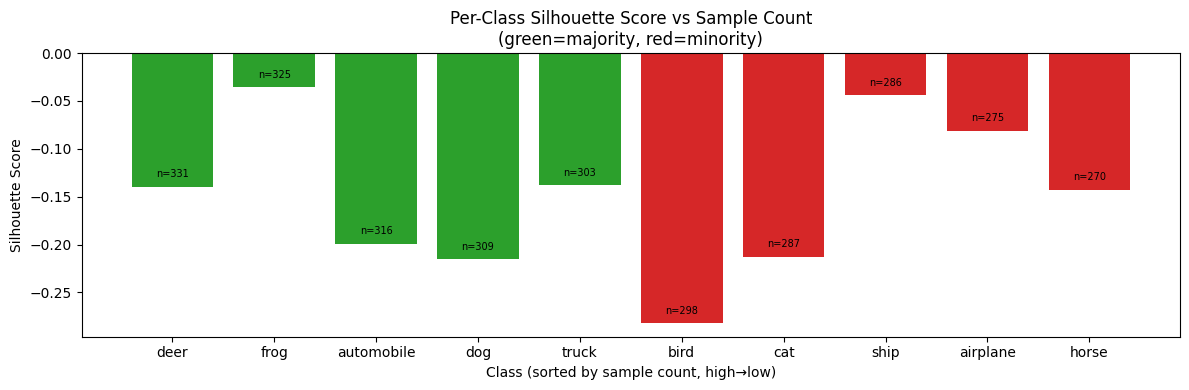


 Problem 5 complete!
   pca_*.png, tsne_*.png, umap_*.png — feature space plots
   gradcam_cifar10.png — Grad-CAM heatmaps per class
   silhouette_analysis.png — cluster quality vs imbalance


In [5]:
# PROBLEM 5 — FEATURE REPRESENTATION & VISUALIZATION
# t-SNE, PCA, UMAP, and Grad-CAM for trained CNN features
# What this file covers:
#   Extract deep features from penultimate layer of trained CNN
#   PCA — fast linear dimensionality reduction
#   t-SNE — non-linear manifold visualization
#   UMAP — faster than t-SNE, better global structure
#   Grad-CAM — heatmaps showing WHERE the model looks
#   Analysis: how imbalance affects feature clustering quality

#*****************************************************************************

import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split
import os

# ── Only run if files are missing ──────────────────────────────────────
if not os.path.exists('cifar10_imbalanced.npz'):
    print("Recreating CIFAR-10 imbalanced dataset...")

    (x_train_full, y_train_full), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
    x_train_full = x_train_full.astype('float32') / 255.0
    x_test       = x_test.astype('float32') / 255.0
    y_train_full = y_train_full.flatten()
    y_test       = y_test.flatten()

    np.random.seed(42)
    num_classes = 10
    max_samples = 5000
    imbalance_ratio = 100
    samples_per_class = [
        max(int(max_samples * (1/imbalance_ratio) ** (i/(num_classes-1))), 10)
        for i in range(num_classes)
    ]
    x_imb, y_imb = [], []
    for cls in range(num_classes):
        idx = np.where(y_train_full == cls)[0]
        n   = min(samples_per_class[cls], len(idx))
        chosen = np.random.choice(idx, n, replace=False)
        x_imb.append(x_train_full[chosen])
        y_imb.append(y_train_full[chosen])
    x_train_c10 = np.concatenate(x_imb)
    y_train_c10 = np.concatenate(y_imb)

    np.savez_compressed('cifar10_imbalanced.npz',
        x_train=x_train_c10, y_train=y_train_c10,
        x_test=x_test, y_test=y_test)
    print(f"CIFAR-10 done. Train shape: {x_train_c10.shape}")
else:
    print("cifar10_imbalanced.npz already exists")


if not os.path.exists('flowers_imbalanced.npz'):
    print("Recreating Flowers imbalanced dataset...")

    ds_full, info = tfds.load('tf_flowers', split='train', as_supervised=True, with_info=True)
    images, labels = [], []
    for img, lbl in ds_full:
        img = tf.image.resize(img, [64, 64])
        img = tf.cast(img, tf.float32) / 255.0
        images.append(img.numpy())
        labels.append(lbl.numpy())
    x_all = np.array(images)
    y_all = np.array(labels)

    FLOWER_SAMPLES = {0: 100, 1: 500, 2: 200, 3: 50, 4: 150}
    np.random.seed(42)
    x_imb, y_imb = [], []
    for cls, n in FLOWER_SAMPLES.items():
        idx = np.where(y_all == cls)[0]
        n   = min(n, len(idx))
        chosen = np.random.choice(idx, n, replace=False)
        x_imb.append(x_all[chosen])
        y_imb.append(y_all[chosen])
    x_fl = np.concatenate(x_imb)
    y_fl = np.concatenate(y_imb)

    x_train_fl, x_test_fl, y_train_fl, y_test_fl = train_test_split(
        x_fl, y_fl, test_size=0.2, random_state=42, stratify=y_fl)

    np.savez_compressed('flowers_imbalanced.npz',
        x_train=x_train_fl, y_train=y_train_fl,
        x_test=x_test_fl,   y_test=y_test_fl)
    print(f"Flowers done. Train shape: {x_train_fl.shape}")
else:
    print("flowers_imbalanced.npz already exists")

#*****************************************************************************

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, callbacks
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
import seaborn as sns

# Try importing umap (may need: !pip install umap-learn -q)
try:
    import umap
    UMAP_AVAILABLE = True
    print(" UMAP available")
except ImportError:
    UMAP_AVAILABLE = False
    print(" UMAP not found — install with: pip install umap-learn")

# Load data
c10 = np.load('cifar10_imbalanced.npz')
x_train, y_train = c10['x_train'], c10['y_train']
x_test,  y_test  = c10['x_test'],  c10['y_test']

fl  = np.load('flowers_imbalanced.npz')
x_train_fl, y_train_fl = fl['x_train'], fl['y_train']
x_test_fl,  y_test_fl  = fl['x_test'],  fl['y_test']

CIFAR10_CLASSES = ['airplane','automobile','bird','cat','deer',
                   'dog','frog','horse','ship','truck']
FLOWER_CLASSES  = ['daisy','dandelion','roses','sunflowers','tulips']

NUM_CLASSES  = 10
INPUT_SHAPE  = (32, 32, 3)

# STEP 1: TRAIN (or reload) THE CNN
# We need a trained model to extract features from.
# If you already ran P1, you can load the saved model.

def build_and_train_cnn(x_train, y_train, input_shape, num_classes, epochs=30):
    """Build and train the base CNN, return model."""
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(32, 3, padding='same'), layers.BatchNormalization(), layers.Activation('relu'),
        layers.Conv2D(32, 3, padding='same'), layers.BatchNormalization(), layers.Activation('relu'),
        layers.MaxPooling2D(), layers.Dropout(0.25),

        layers.Conv2D(64, 3, padding='same'), layers.BatchNormalization(), layers.Activation('relu'),
        layers.Conv2D(64, 3, padding='same'), layers.BatchNormalization(), layers.Activation('relu'),
        layers.MaxPooling2D(), layers.Dropout(0.30),

        layers.Conv2D(128, 3, padding='same'), layers.BatchNormalization(), layers.Activation('relu'),
        layers.GlobalAveragePooling2D(),

        # NAMED LAYER — we extract features from here
        layers.Dense(256, name='feature_layer',
                     kernel_regularizer=regularizers.l2(1e-4)),
        layers.BatchNormalization(), layers.Activation('relu'), layers.Dropout(0.4),

        layers.Dense(num_classes, activation='softmax', name='output')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    cbs = [callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True),
           callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)]

    model.fit(x_train, y_train, epochs=epochs, batch_size=64,
              validation_split=0.15, callbacks=cbs, verbose=1)
    return model


# Try loading pretrained, otherwise train fresh
try:
    cnn_c10 = tf.keras.models.load_model('best_custom_cnn_cifar10.keras')
    print(" Loaded pretrained CIFAR-10 model")
except:
    print("Training CNN on CIFAR-10 (P1 model not found)...")
    cnn_c10 = build_and_train_cnn(x_train, y_train, INPUT_SHAPE, NUM_CLASSES)

try:
    cnn_fl = tf.keras.models.load_model('best_custom_cnn_flowers.keras')
    print(" Loaded pretrained Flowers model")
except:
    print("Training CNN on Flowers...")
    cnn_fl = build_and_train_cnn(x_train_fl, y_train_fl, (64, 64, 3), 5)


# STEP 2: FEATURE EXTRACTION
# We create a "feature extractor" — a version of the model that outputs
# the 256-dim vector from the Dense layer, NOT the final softmax.
# These feature vectors are what we visualize.

def get_feature_extractor(model, layer_name='feature_layer'):
    """
    Works for both Sequential and Functional Keras models.
    Builds a new functional model that outputs the intermediate layer.
    """
    # Get the target layer
    target_layer = model.get_layer(layer_name)

    # Build a functional model manually
    # We need to call the model on a dummy input first to trace the graph
    dummy_input = tf.keras.Input(shape=model.input_shape[1:])

    # Pass through layer by layer up to the target layer
    x = dummy_input
    for layer in model.layers:
        x = layer(x)
        if layer.name == layer_name:
            break

    return tf.keras.Model(inputs=dummy_input, outputs=x, name='feature_extractor')

# Then use it normally
extractor_c10 = get_feature_extractor(cnn_c10)
features_test_c10  = extractor_c10.predict(x_test,  verbose=0)
features_train_c10 = extractor_c10.predict(x_train, verbose=0)

extractor_fl = get_feature_extractor(cnn_fl)
features_test_fl  = extractor_fl.predict(x_test_fl,  verbose=0)
features_train_fl = extractor_fl.predict(x_train_fl, verbose=0)


# STEP 3: DIMENSIONALITY REDUCTION VISUALIZATIONS

def plot_2d_features(coords_2d, labels, class_names, title, filename, highlight_minority=True):
    """
    Scatter plot of 2D feature coordinates, colored by class.
    Optionally draws larger markers for minority class samples.
    """
    n_classes     = len(class_names)
    counts        = np.bincount(labels)
    minority_idx  = np.argsort(counts)[:2]   # 2 rarest classes

    # Custom color palette
    palette = plt.cm.tab10(np.linspace(0, 1, n_classes))

    fig, ax = plt.subplots(figsize=(10, 8))

    for cls in range(n_classes):
        mask      = labels == cls
        marker    = '*' if cls in minority_idx else 'o'
        size      = 80   if cls in minority_idx else 20
        alpha     = 0.9  if cls in minority_idx else 0.4
        zorder    = 5    if cls in minority_idx else 2

        ax.scatter(
            coords_2d[mask, 0], coords_2d[mask, 1],
            c=[palette[cls]], label=f"{class_names[cls]} (n={counts[cls]})",
            s=size, alpha=alpha, marker=marker, zorder=zorder,
            edgecolors='k' if cls in minority_idx else 'none', linewidths=0.5
        )

    ax.set_title(title, fontsize=13, fontweight='bold')
    ax.set_xlabel("Component 1"); ax.set_ylabel("Component 2")
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    plt.tight_layout()
    plt.savefig(filename, dpi=150, bbox_inches='tight')
    plt.show()

    # Silhouette score = how well-separated clusters are (higher = better)
    if len(np.unique(labels)) > 1:
        sil = silhouette_score(coords_2d, labels, sample_size=min(5000, len(labels)))
        print(f"  Silhouette score: {sil:.4f}  (range: -1 to 1, higher = better clustering)")

    return


# --- 3A. PCA ---
print("\n" + "="*60)
print("3A. PCA — Principal Component Analysis")
print("="*60)
# PCA is fast linear method. Good for quick overview.
# Shows global structure but misses non-linear relationships.

print("Running PCA on CIFAR-10 features...")
pca = PCA(n_components=2, random_state=42)
pca_coords_c10 = pca.fit_transform(features_test_c10)
print(f"  Explained variance: {pca.explained_variance_ratio_.sum()*100:.1f}%")

plot_2d_features(
    pca_coords_c10, y_test, CIFAR10_CLASSES,
    title="PCA Feature Space — CIFAR-10 (imbalanced CNN)",
    filename="pca_cifar10.png"
)

print("Running PCA on Flowers features...")
pca_fl = PCA(n_components=2, random_state=42)
pca_coords_fl = pca_fl.fit_transform(features_test_fl)
print(f"  Explained variance: {pca_fl.explained_variance_ratio_.sum()*100:.1f}%")

plot_2d_features(
    pca_coords_fl, y_test_fl, FLOWER_CLASSES,
    title="PCA Feature Space — Flowers (imbalanced CNN)",
    filename="pca_flowers.png"
)


# --- 3B. t-SNE ---
print("\n" + "="*60)
print("3B. t-SNE — Non-linear Embedding")
print("="*60)
# t-SNE reveals cluster structure that PCA misses.
# Expensive — we use PCA first to reduce to 50D, then t-SNE to 2D.
# perplexity controls how many neighbors each point considers.

# Subsample for speed (t-SNE is O(n^2))
N_TSNE = min(3000, len(y_test))
idx_sub = np.random.choice(len(y_test), N_TSNE, replace=False)

# First reduce to 50D with PCA (speeds up t-SNE significantly)
pca50       = PCA(n_components=50, random_state=42)
feat_50d    = pca50.fit_transform(features_test_c10[idx_sub])

print(f"Running t-SNE on {N_TSNE} CIFAR-10 samples...")
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42, verbose=1)
tsne_coords = tsne.fit_transform(feat_50d)

plot_2d_features(
    tsne_coords, y_test[idx_sub], CIFAR10_CLASSES,
    title="t-SNE Feature Space — CIFAR-10 (imbalanced CNN)",
    filename="tsne_cifar10.png"
)

# Flowers t-SNE
N_TSNE_FL = min(2000, len(y_test_fl))
idx_fl    = np.random.choice(len(y_test_fl), N_TSNE_FL, replace=False)
pca50_fl  = PCA(n_components=min(50, features_test_fl.shape[1]), random_state=42)
feat_fl50 = pca50_fl.fit_transform(features_test_fl[idx_fl])

print(f"Running t-SNE on {N_TSNE_FL} Flowers samples...")
tsne_fl      = TSNE(n_components=2, perplexity=20, n_iter=1000, random_state=42, verbose=1)
tsne_fl_coords = tsne_fl.fit_transform(feat_fl50)

plot_2d_features(
    tsne_fl_coords, y_test_fl[idx_fl], FLOWER_CLASSES,
    title="t-SNE Feature Space — Flowers (imbalanced CNN)",
    filename="tsne_flowers.png"
)


# --- 3C. UMAP ---
if UMAP_AVAILABLE:
    print("\n" + "="*60)
    print("3C. UMAP — Faster & better global structure than t-SNE")
    print("="*60)

    print("Running UMAP on CIFAR-10...")
    reducer_c10  = umap.UMAP(n_components=2, random_state=42, verbose=False)
    umap_coords  = reducer_c10.fit_transform(features_test_c10[:N_TSNE])

    plot_2d_features(
        umap_coords, y_test[:N_TSNE], CIFAR10_CLASSES,
        title="UMAP Feature Space — CIFAR-10 (imbalanced CNN)",
        filename="umap_cifar10.png"
    )

    print("Running UMAP on Flowers...")
    reducer_fl     = umap.UMAP(n_components=2, random_state=42)
    umap_fl_coords = reducer_fl.fit_transform(features_test_fl)

    plot_2d_features(
        umap_fl_coords, y_test_fl, FLOWER_CLASSES,
        title="UMAP Feature Space — Flowers (imbalanced CNN)",
        filename="umap_flowers.png"
    )
else:
    print("\n Skipping UMAP — install with: !pip install umap-learn -q")

# STEP 4: GRAD-CAM — WHERE DOES THE MODEL LOOK?
# Grad-CAM (Gradient-weighted Class Activation Mapping) computes a heatmap
# showing which regions of the input image influenced the model's prediction.
# It does this by:
#   1. Forward-passing the image and recording activations at the last conv layer
#   2. Computing gradients of the predicted class score w.r.t. those activations
#   3. Weighting the feature maps by their gradient importance
#   4. Creating a heatmap from the weighted sum

def grad_cam(model, img, class_idx, last_conv_layer_name):
    """
    Fixed Grad-CAM that works with Sequential models in Keras 3.
    """
    # Build a functional grad model by tracing layer by layer
    dummy_input = tf.keras.Input(shape=model.input_shape[1:])
    x = dummy_input
    conv_output = None

    for layer in model.layers:
        x = layer(x)
        if layer.name == last_conv_layer_name:
            conv_output = x  # capture conv output here

    final_output = x  # softmax predictions

    grad_model = tf.keras.Model(inputs=dummy_input,
                                 outputs=[conv_output, final_output])

    img_batch = np.expand_dims(img, 0)

    with tf.GradientTape() as tape:
        conv_out, predictions = grad_model(img_batch)
        tape.watch(conv_out)
        class_score = predictions[:, class_idx]

    grads       = tape.gradient(class_score, conv_out)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    heatmap = conv_out[0] @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / (tf.math.reduce_max(heatmap) + 1e-8)

    return heatmap.numpy()


def overlay_gradcam(img, heatmap, alpha=0.4):
    """Overlay Grad-CAM heatmap on image."""
    h, w = img.shape[:2]
    # Resize heatmap to image size
    heatmap_resized = tf.image.resize(
        heatmap[..., np.newaxis], [h, w]
    ).numpy().squeeze()

    # Apply colormap
    heatmap_colored = plt.cm.jet(heatmap_resized)[:, :, :3]

    superimposed = (1 - alpha) * img + alpha * heatmap_colored
    return np.clip(superimposed, 0, 1)

# Force graph build
_ = cnn_c10.predict(x_test[:2], verbose=0)

# Find last conv layer
last_conv = None
for layer in cnn_c10.layers[::-1]:
    if isinstance(layer, tf.keras.layers.Conv2D):
        last_conv = layer.name
        break
print(f"Last Conv2D layer: {last_conv}")
# Generate Grad-CAM for sample images from each class
print("Generating Grad-CAM visualizations...")

fig, axes = plt.subplots(3, NUM_CLASSES, figsize=(20, 7))
fig.suptitle("Grad-CAM: What the Model Focuses On (CIFAR-10)", fontsize=12, fontweight='bold')

for cls in range(NUM_CLASSES):
    # Find a test sample of this class
    cls_idx = np.where(y_test == cls)[0]
    if len(cls_idx) == 0:
        continue
    img_idx = cls_idx[0]
    img     = x_test[img_idx]

    # Get prediction
    pred_probs = cnn_c10.predict(img[np.newaxis], verbose=0)[0]
    pred_cls   = np.argmax(pred_probs)

    # Compute Grad-CAM for the TRUE class and PREDICTED class
    cam_true = grad_cam(cnn_c10, img, cls, last_conv)
    cam_pred = grad_cam(cnn_c10, img, pred_cls, last_conv)

    # Overlay
    overlay_true = overlay_gradcam(img, cam_true)
    overlay_pred = overlay_gradcam(img, cam_pred)

    # Plot: original | grad-cam true class | grad-cam predicted class
    axes[0, cls].imshow(img); axes[0, cls].axis('off')
    axes[0, cls].set_title(f"{CIFAR10_CLASSES[cls]}\n(n={np.bincount(y_train)[cls]})", fontsize=7)

    axes[1, cls].imshow(overlay_true); axes[1, cls].axis('off')
    if cls == 0: axes[1, cls].set_ylabel("True class\nCAM", fontsize=8)

    axes[2, cls].imshow(overlay_pred); axes[2, cls].axis('off')
    if cls == 0: axes[2, cls].set_ylabel("Pred class\nCAM", fontsize=8)

    correct = '✓' if pred_cls == cls else '✗'
    axes[2, cls].set_title(f"Pred: {CIFAR10_CLASSES[pred_cls]} {correct}", fontsize=6)

plt.tight_layout()
plt.savefig("gradcam_cifar10.png", dpi=150, bbox_inches='tight')
plt.show()


# STEP 5: IMBALANCE IMPACT ON FEATURE SPACE — ANALYSIS
print("\n" + "="*60)
print("ANALYSIS: How Imbalance Affects Feature Space Quality")
print("="*60)

# Compute per-class cluster quality (intra-class compactness)
from sklearn.metrics import silhouette_samples

print("\nPer-class silhouette scores (t-SNE space) — higher = better cluster:")
sil_samples = silhouette_samples(tsne_coords, y_test[idx_sub])
class_counts = np.bincount(y_test[idx_sub])

class_sil = {}
for cls in range(NUM_CLASSES):
    mask = y_test[idx_sub] == cls
    if mask.sum() > 1:
        class_sil[cls] = sil_samples[mask].mean()
        print(f"  {CIFAR10_CLASSES[cls]:12s} (n={class_counts[cls]:4d}): {class_sil[cls]:+.4f}")

# Correlation between class count and silhouette
counts_list = [class_counts[cls] for cls in class_sil]
sil_list    = [class_sil[cls]    for cls in class_sil]
corr        = np.corrcoef(counts_list, sil_list)[0, 1]
print(f"\nCorrelation (class count vs silhouette): {corr:.4f}")
print("  → Positive correlation means majority classes form better clusters.")
print("  → Minority classes show worse cluster quality (lower silhouette).")

# Visualize: bar chart of silhouette by class
fig, ax = plt.subplots(figsize=(12, 4))
classes_sorted = sorted(class_sil.items(), key=lambda x: class_counts[x[0]], reverse=True)
cls_names = [CIFAR10_CLASSES[c[0]] for c in classes_sorted]
sil_vals  = [c[1] for c in classes_sorted]
n_samples = [class_counts[c[0]] for c in classes_sorted]
colors    = ['#2ca02c' if n >= np.mean(n_samples) else '#d62728' for n in n_samples]

bars = ax.bar(cls_names, sil_vals, color=colors)
ax.axhline(0, color='black', linewidth=0.5)
ax.set_title("Per-Class Silhouette Score vs Sample Count\n(green=majority, red=minority)")
ax.set_xlabel("Class (sorted by sample count, high→low)")
ax.set_ylabel("Silhouette Score")

# Add sample count labels
for bar, n in zip(bars, n_samples):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
            f'n={n}', ha='center', fontsize=7)

plt.tight_layout()
plt.savefig("silhouette_analysis.png", dpi=150)
plt.show()

print("\n Problem 5 complete!")
print("   pca_*.png, tsne_*.png, umap_*.png — feature space plots")
print("   gradcam_cifar10.png — Grad-CAM heatmaps per class")
print("   silhouette_analysis.png — cluster quality vs imbalance")

STEP 1: Training SOURCE model on CIFAR-10


Model: "SourceCIFAR10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1a (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1a (BatchNormalization)       │ (None, 32, 32, 32)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu1a (Activation)             │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1b (Conv2D)                 │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1b (BatchNormalization)       │ (None, 32, 32, 32)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu1b (Activation)             │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2a (Conv2D)                 │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2a (BatchNormalization)       │ (None, 16, 16, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu2a (Activation)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2b (Conv2D)                 │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2b (BatchNormalization)       │ (None, 16, 16, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu2b (Activation)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3a (Conv2D)                 │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn3a (BatchNormalization)       │ (None, 8, 8, 128)      │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu3a (Activation)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gap (GlobalAveragePooling2D)    │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_fc (BatchNormalization)      │ (None, 256)            │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_fc (Activation)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop_fc (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         2,57

 Total params: 177,322 (692.66 KB)

 Trainable params: 176,170 (688.16 KB)

 Non-trainable params: 1,152 (4.50 KB)

Epoch 1/40
165/165 ━━━━━━━━━━━━━━━━━━━━ 23s 55ms/step - accuracy: 0.6161 - loss: 1.1992 - val_accuracy: 0.0000e+00 - val_loss: 5.0325 - learning_rate: 0.0010
Epoch 2/40
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7564 - loss: 0.6626 - val_accuracy: 0.0000e+00 - val_loss: 8.2471 - learning_rate: 0.0010
Epoch 3/40
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7986 - loss: 0.5621 - val_accuracy: 0.0913 - val_loss: 9.2066 - learning_rate: 0.0010
Epoch 4/40
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8089 - loss: 0.5023 - val_accuracy: 0.0226 - val_loss: 9.4347 - learning_rate: 0.0010
Epoch 5/40
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8389 - loss: 0.4324 - val_accuracy: 0.0586 - val_loss: 10.7976 - learning_rate: 5.0000e-04
Epoch 6/40
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8553 - loss: 0.3995 - val_accuracy: 0.1236 - val_loss: 10.3044 - learning_rate: 5.0000e-04
Epoch 7/40
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.85

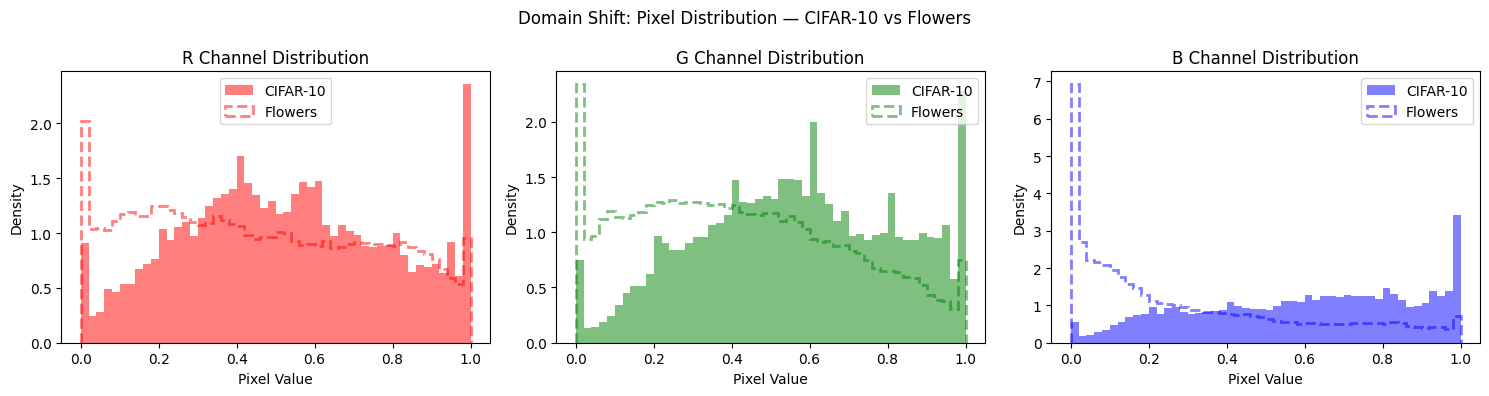


Resizing Flowers to 32×32 to match CIFAR-10 source model...

EXPERIMENT A: Feature Extraction (all frozen, new head only)
Source weights loaded
Mode: feature_extraction | Trainable: 1,285 / 176,037

Feature Extraction: Acc=0.5200, Macro F1=0.1851, Bal Acc=0.2297, Time=15s
              precision    recall  f1-score   support

       daisy       0.00      0.00      0.00        20
   dandelion       0.54      0.99      0.69       100
       roses       1.00      0.03      0.05        40
  sunflowers       0.00      0.00      0.00        10
      tulips       0.29      0.13      0.18        30

    accuracy                           0.52       200
   macro avg       0.36      0.23      0.19       200
weighted avg       0.51      0.52      0.38       200


EXPERIMENT B: Partial Fine-tuning (freeze early, train late layers)
Source weights loaded
Mode: partial_finetune | Trainable: 108,933 / 176,037



Partial Fine-tuning: Acc=0.5800, Macro F1=0.2789, Bal Acc=0.3020, Time=13s
              precision    recall  f1-score   support

       daisy       0.67      0.10      0.17        20
   dandelion       0.59      0.96      0.73       100
       roses       0.55      0.45      0.49        40
  sunflowers       0.00      0.00      0.00        10
      tulips       0.00      0.00      0.00        30

    accuracy                           0.58       200
   macro avg       0.36      0.30      0.28       200
weighted avg       0.47      0.58      0.48       200


EXPERIMENT C: Full Fine-tuning (all layers trainable)
Source weights loaded
Mode: full_finetune | Trainable: 174,885 / 176,037



Full Fine-tuning: Acc=0.5000, Macro F1=0.1333, Bal Acc=0.2000, Time=20s
              precision    recall  f1-score   support

       daisy       0.00      0.00      0.00        20
   dandelion       0.50      1.00      0.67       100
       roses       0.00      0.00      0.00        40
  sunflowers       0.00      0.00      0.00        10
      tulips       0.00      0.00      0.00        30

    accuracy                           0.50       200
   macro avg       0.10      0.20      0.13       200
weighted avg       0.25      0.50      0.33       200


EXPERIMENT D: Train from Scratch on Flowers (no transfer)
From Scratch: Acc=0.5000, Macro F1=0.1333

EXPERIMENT E: ImageNet → Flowers (ResNet50 feature extraction)
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

ImageNet → Flowers: Acc=0.8100, Macro F1=0.7688, Bal Acc=0.7480, Time=59s
              precision    recall  f1-score   support

       daisy       0.81      0.85      0.83        20
   dandelion       0.90      0.94     

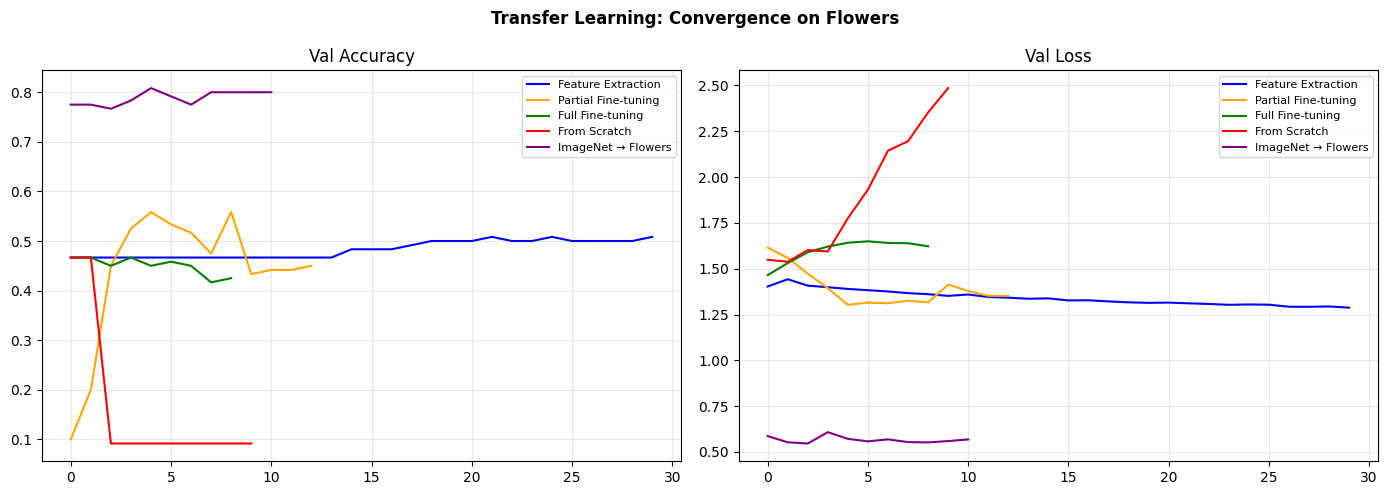

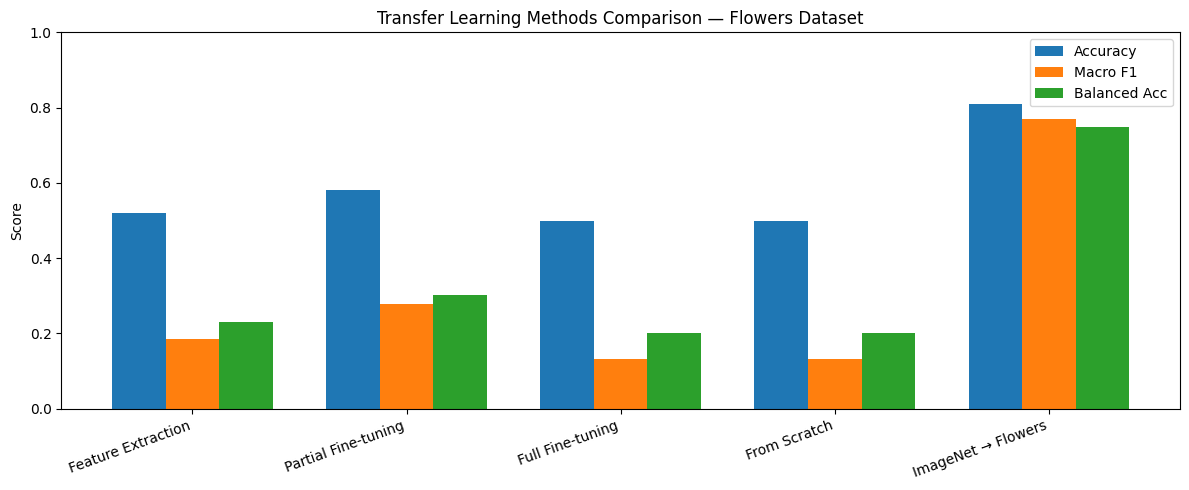


  Problem 6 complete!
   p6_transfer_results.csv
   p6_convergence.png
   p6_comparison_bars.png
   domain_shift_pixel_dist.png


In [7]:
# PROBLEM 6 — GENERALIZATION & TRANSFER LEARNING TEST
# Train on CIFAR-10 → Test transferability to Flowers
# Experiments:
#   Experiment A: Feature Extraction
#       → Freeze all of CIFAR-10 trained CNN, only train new classifier head
#   Experiment B: Full Fine-tuning
#       → Unfreeze all layers, train entire network on Flowers with small LR
#   Experiment C: Partial Fine-tuning
#       → Freeze early layers, fine-tune only last conv block + head
#   Experiment D: Train from Scratch on Flowers (baseline comparison)
#   Experiment E: ImageNet Pretrained (ResNet50) → Flowers
# Analysis:
#   Domain shift measurement
#   Feature extraction vs fine-tuning comparison
#   Convergence speed comparison
#   Performance degradation analysis

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, callbacks
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, f1_score, balanced_accuracy_score
import pandas as pd
import time

# Load datasets
c10 = np.load('cifar10_imbalanced.npz')
x_train_c10, y_train_c10 = c10['x_train'], c10['y_train']
x_test_c10,  y_test_c10  = c10['x_test'],  c10['y_test']

fl = np.load('flowers_imbalanced.npz')
x_train_fl, y_train_fl = fl['x_train'], fl['y_train']
x_test_fl,  y_test_fl  = fl['x_test'],  fl['y_test']

CIFAR10_CLASSES = ['airplane','automobile','bird','cat','deer',
                   'dog','frog','horse','ship','truck']
FLOWER_CLASSES  = ['daisy','dandelion','roses','sunflowers','tulips']

CALLBACKS_BASE = [
    callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)
]

# STEP 1: TRAIN SOURCE MODEL ON CIFAR-10
# This is our "source domain" model. We train it fully on CIFAR-10,
# then transfer its learned features to the "target domain" (Flowers).

def build_full_cnn(input_shape, num_classes, name="CNN"):
    """CNN with named layers for surgical layer freezing."""
    model = models.Sequential([
        layers.Input(shape=input_shape),

        # BLOCK 1 — low-level features (edges, colors)
        layers.Conv2D(32, 3, padding='same', name='conv1a'),
        layers.BatchNormalization(name='bn1a'), layers.Activation('relu', name='relu1a'),
        layers.Conv2D(32, 3, padding='same', name='conv1b'),
        layers.BatchNormalization(name='bn1b'), layers.Activation('relu', name='relu1b'),
        layers.MaxPooling2D(name='pool1'), layers.Dropout(0.25, name='drop1'),

        # BLOCK 2 — mid-level features (shapes, textures)
        layers.Conv2D(64, 3, padding='same', name='conv2a'),
        layers.BatchNormalization(name='bn2a'), layers.Activation('relu', name='relu2a'),
        layers.Conv2D(64, 3, padding='same', name='conv2b'),
        layers.BatchNormalization(name='bn2b'), layers.Activation('relu', name='relu2b'),
        layers.MaxPooling2D(name='pool2'), layers.Dropout(0.30, name='drop2'),

        # BLOCK 3 — high-level features (class-specific patterns)
        layers.Conv2D(128, 3, padding='same', name='conv3a'),
        layers.BatchNormalization(name='bn3a'), layers.Activation('relu', name='relu3a'),
        layers.GlobalAveragePooling2D(name='gap'),

        # HEAD
        layers.Dense(256, name='fc1', kernel_regularizer=regularizers.l2(1e-4)),
        layers.BatchNormalization(name='bn_fc'), layers.Activation('relu', name='relu_fc'),
        layers.Dropout(0.4, name='drop_fc'),
        layers.Dense(num_classes, activation='softmax', name='output')
    ], name=name)
    return model


print("="*60)
print("STEP 1: Training SOURCE model on CIFAR-10")
print("="*60)

source_model = build_full_cnn((32, 32, 3), 10, name="SourceCIFAR10")
source_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
source_model.summary()

hist_source = source_model.fit(
    x_train_c10, y_train_c10,
    epochs=40, batch_size=64,
    validation_split=0.15,
    callbacks=CALLBACKS_BASE,
    verbose=1
)

# Save source model weights
source_model.save_weights('source_cifar10_weights.weights.h5')

# Evaluate on CIFAR-10 (source domain)
loss_src, acc_src = source_model.evaluate(x_test_c10, y_test_c10, verbose=0)
y_pred_src        = np.argmax(source_model.predict(x_test_c10, verbose=0), axis=1)
print(f"\nSource model on CIFAR-10: Acc={acc_src:.4f}, Macro F1={f1_score(y_test_c10, y_pred_src, average='macro'):.4f}")


# STEP 2: DOMAIN SHIFT ANALYSIS
# How different are CIFAR-10 and Flowers?
# We quantify this by looking at:
#   1. Image statistics (mean, std)
#   2. Feature distribution overlap (via PCA)

print("\n" + "="*60)
print("STEP 2: Domain Shift Analysis")
print("="*60)

# Image statistics
print("\nImage Statistics:")
print(f"  CIFAR-10  — mean: {x_train_c10.mean():.4f}, std: {x_train_c10.std():.4f}, size: 32×32")
print(f"  Flowers   — mean: {x_train_fl.mean():.4f}, std: {x_train_fl.std():.4f}, size: 64×64")

# We resize flowers to 32x32 for fair comparison
x_fl_resized = tf.image.resize(x_train_fl, [32, 32]).numpy()
print(f"  Flowers (resized) — mean: {x_fl_resized.mean():.4f}, std: {x_fl_resized.std():.4f}")

# Pixel distribution comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for ch, color, name in zip([0, 1, 2], ['red', 'green', 'blue'], ['R', 'G', 'B']):
    axes[ch].hist(x_train_c10[:200, :, :, ch].flatten(), bins=50, alpha=0.5,
                  color=color, label='CIFAR-10', density=True)
    axes[ch].hist(x_fl_resized[:200, :, :, ch].flatten(), bins=50, alpha=0.5,
                  color=color, label='Flowers', density=True, linestyle='--',
                  histtype='step', linewidth=2)
    axes[ch].set_title(f"{name} Channel Distribution")
    axes[ch].legend()
    axes[ch].set_xlabel("Pixel Value"); axes[ch].set_ylabel("Density")

plt.suptitle("Domain Shift: Pixel Distribution — CIFAR-10 vs Flowers", fontsize=12)
plt.tight_layout()
plt.savefig("domain_shift_pixel_dist.png", dpi=150)
plt.show()


# TRANSFER LEARNING HELPER

def create_transfer_model(source_weights_path, target_num_classes,
                           freeze_mode='feature_extraction', name="TransferModel"):

    # ── Build with a proper functional API (not Sequential) ──────────────
    # This avoids the .input / .output issue on untraced Sequential models

    inp = tf.keras.Input(shape=(32, 32, 3))

    # Block 1
    x = layers.Conv2D(32, 3, padding='same', name='conv1a')(inp)
    x = layers.BatchNormalization(name='bn1a')(x)
    x = layers.Activation('relu', name='relu1a')(x)
    x = layers.Conv2D(32, 3, padding='same', name='conv1b')(x)
    x = layers.BatchNormalization(name='bn1b')(x)
    x = layers.Activation('relu', name='relu1b')(x)
    x = layers.MaxPooling2D(name='pool1')(x)
    x = layers.Dropout(0.25, name='drop1')(x)

    # Block 2
    x = layers.Conv2D(64, 3, padding='same', name='conv2a')(x)
    x = layers.BatchNormalization(name='bn2a')(x)
    x = layers.Activation('relu', name='relu2a')(x)
    x = layers.Conv2D(64, 3, padding='same', name='conv2b')(x)
    x = layers.BatchNormalization(name='bn2b')(x)
    x = layers.Activation('relu', name='relu2b')(x)
    x = layers.MaxPooling2D(name='pool2')(x)
    x = layers.Dropout(0.30, name='drop2')(x)

    # Block 3
    x = layers.Conv2D(128, 3, padding='same', name='conv3a')(x)
    x = layers.BatchNormalization(name='bn3a')(x)
    x = layers.Activation('relu', name='relu3a')(x)
    x = layers.GlobalAveragePooling2D(name='gap')(x)

    # Head (source head — will be replaced)
    x = layers.Dense(256, name='fc1', kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization(name='bn_fc')(x)
    x = layers.Activation('relu', name='relu_fc')(x)
    x = layers.Dropout(0.4, name='drop_fc')(x)
    src_out = layers.Dense(10, activation='softmax', name='output')(x)   # source = 10 classes

    # Build source model and load weights
    source_model = tf.keras.Model(inputs=inp, outputs=src_out, name='source')
    source_model.load_weights(source_weights_path)
    print("Source weights loaded")

    # ── Replace output head for target domain ────────────────────────────
    # Everything up to 'drop_fc' is reused; only the final Dense changes
    feature_out = source_model.get_layer('drop_fc').output
    new_out     = layers.Dense(target_num_classes, activation='softmax',
                               name='new_output')(feature_out)

    transfer_model = tf.keras.Model(inputs=source_model.input,
                                     outputs=new_out, name=name)

    # ── Apply freezing strategy ──────────────────────────────────────────
    freeze_these = {
        'feature_extraction': [l.name for l in transfer_model.layers
                                if l.name != 'new_output'],
        'partial_finetune':   ['conv1a','bn1a','relu1a','conv1b','bn1b','relu1b',
                               'pool1','drop1','conv2a','bn2a','relu2a',
                               'conv2b','bn2b','relu2b','pool2','drop2'],
        'full_finetune':      []   # freeze nothing
    }

    frozen = freeze_these[freeze_mode]
    for layer in transfer_model.layers:
        layer.trainable = layer.name not in frozen

    trainable = sum(np.prod(v.shape) for v in transfer_model.trainable_variables)
    total     = transfer_model.count_params()
    print(f"Mode: {freeze_mode} | Trainable: {trainable:,} / {total:,}")

    return transfer_model

def run_transfer_experiment(name, model, x_train, y_train, x_test, y_test,
                             class_names, lr=1e-3, epochs=30):
    """Train a transfer model and evaluate it."""
    model.compile(
        optimizer=tf.keras.optimizers.Adam(lr),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    start = time.time()
    history = model.fit(
        x_train, y_train,
        epochs=epochs, batch_size=32,
        validation_split=0.15,
        callbacks=CALLBACKS_BASE,
        verbose=0
    )
    train_time = time.time() - start

    y_probs = model.predict(x_test, verbose=0)
    y_pred  = np.argmax(y_probs, axis=1)

    _, acc  = model.evaluate(x_test, y_test, verbose=0)
    macro_f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
    bal_acc  = balanced_accuracy_score(y_test, y_pred)

    print(f"\n{name}: Acc={acc:.4f}, Macro F1={macro_f1:.4f}, Bal Acc={bal_acc:.4f}, Time={train_time:.0f}s")
    print(classification_report(y_test, y_pred, target_names=class_names, zero_division=0))

    return {
        'name': name, 'history': history,
        'acc': acc, 'macro_f1': macro_f1, 'bal_acc': bal_acc,
        'train_time': train_time, 'epochs': len(history.history['val_accuracy'])
    }


# Resize flowers to 32x32 to match source model input
print("\nResizing Flowers to 32×32 to match CIFAR-10 source model...")
x_train_fl32 = tf.image.resize(x_train_fl, [32, 32]).numpy()
x_test_fl32  = tf.image.resize(x_test_fl,  [32, 32]).numpy()

transfer_results = []


# EXPERIMENT A: FEATURE EXTRACTION (Frozen source)
print("\n" + "="*60)
print("EXPERIMENT A: Feature Extraction (all frozen, new head only)")
print("="*60)

model_fe = create_transfer_model(
    'source_cifar10_weights.weights.h5', 5,
    freeze_mode='feature_extraction',
    name="FeatureExtraction"
)
result_fe = run_transfer_experiment(
    "Feature Extraction", model_fe,
    x_train_fl32, y_train_fl, x_test_fl32, y_test_fl,
    FLOWER_CLASSES, lr=1e-3, epochs=30
)
transfer_results.append(result_fe)


# EXPERIMENT B: PARTIAL FINE-TUNING
print("\n" + "="*60)
print("EXPERIMENT B: Partial Fine-tuning (freeze early, train late layers)")
print("="*60)

model_pft = create_transfer_model(
    'source_cifar10_weights.weights.h5', 5,
    freeze_mode='partial_finetune',
    name="PartialFinetune"
)
result_pft = run_transfer_experiment(
    "Partial Fine-tuning", model_pft,
    x_train_fl32, y_train_fl, x_test_fl32, y_test_fl,
    FLOWER_CLASSES, lr=5e-4, epochs=30   # smaller LR for fine-tuning
)
transfer_results.append(result_pft)

# EXPERIMENT C: FULL FINE-TUNING
print("\n" + "="*60)
print("EXPERIMENT C: Full Fine-tuning (all layers trainable)")
print("="*60)

model_fft = create_transfer_model(
    'source_cifar10_weights.weights.h5', 5,
    freeze_mode='full_finetune',
    name="FullFinetune"
)
result_fft = run_transfer_experiment(
    "Full Fine-tuning", model_fft,
    x_train_fl32, y_train_fl, x_test_fl32, y_test_fl,
    FLOWER_CLASSES, lr=1e-4, epochs=30   # very small LR — we don't want to destroy source features
)
transfer_results.append(result_fft)


# EXPERIMENT D: TRAIN FROM SCRATCH (baseline)
print("\n" + "="*60)
print("EXPERIMENT D: Train from Scratch on Flowers (no transfer)")
print("="*60)

model_scratch = build_full_cnn((32, 32, 3), 5, name="FromScratch")
model_scratch.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
start     = time.time()
hist_scr  = model_scratch.fit(
    x_train_fl32, y_train_fl, epochs=40, batch_size=32,
    validation_split=0.15, callbacks=CALLBACKS_BASE, verbose=0
)
train_time = time.time() - start

y_pred_scr = np.argmax(model_scratch.predict(x_test_fl32, verbose=0), axis=1)
_, acc_scr = model_scratch.evaluate(x_test_fl32, y_test_fl, verbose=0)

result_scr = {
    'name': 'From Scratch', 'history': hist_scr,
    'acc': acc_scr,
    'macro_f1': f1_score(y_test_fl, y_pred_scr, average='macro', zero_division=0),
    'bal_acc': balanced_accuracy_score(y_test_fl, y_pred_scr),
    'train_time': train_time,
    'epochs': len(hist_scr.history['val_accuracy'])
}
transfer_results.append(result_scr)
print(f"From Scratch: Acc={acc_scr:.4f}, Macro F1={result_scr['macro_f1']:.4f}")


# EXPERIMENT E: IMAGENET PRETRAINED (ResNet50) → Flowers
print("\n" + "="*60)
print("EXPERIMENT E: ImageNet → Flowers (ResNet50 feature extraction)")
print("="*60)

def build_imagenet_transfer(num_classes):
    inputs = tf.keras.Input(shape=(32, 32, 3))
    x      = layers.Resizing(224, 224)(inputs)
    x      = tf.keras.applications.resnet50.preprocess_input(x * 255.0)
    base   = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_tensor=x)
    base.trainable = False
    x = layers.GlobalAveragePooling2D()(base.output)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(num_classes, activation='softmax')(x)
    return tf.keras.Model(inputs=inputs, outputs=x, name="ImageNet_ResNet50")

model_imagenet = build_imagenet_transfer(5)
result_imagenet = run_transfer_experiment(
    "ImageNet → Flowers", model_imagenet,
    x_train_fl32, y_train_fl, x_test_fl32, y_test_fl,
    FLOWER_CLASSES, lr=1e-3, epochs=25
)
transfer_results.append(result_imagenet)


# FINAL COMPARISON
print("\n" + "="*70)
print("TRANSFER LEARNING — FINAL COMPARISON")
print("="*70)

df = pd.DataFrame([{
    'Method': r['name'],
    'Accuracy': round(r['acc'], 4),
    'Macro F1': round(r['macro_f1'], 4),
    'Balanced Acc': round(r['bal_acc'], 4),
    'Train Time (s)': round(r['train_time'], 0),
    'Epochs Run': r['epochs']
} for r in transfer_results])

print(df.sort_values('Macro F1', ascending=False).to_string(index=False))
df.to_csv("p6_transfer_results.csv", index=False)

# Convergence comparison plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle("Transfer Learning: Convergence on Flowers", fontsize=12, fontweight='bold')

colors = ['blue', 'orange', 'green', 'red', 'purple']
for r, color in zip(transfer_results, colors):
    h = r['history'].history
    axes[0].plot(h['val_accuracy'], label=r['name'], color=color)
    axes[1].plot(h['val_loss'],     label=r['name'], color=color)

axes[0].set_title('Val Accuracy'); axes[0].legend(fontsize=8); axes[0].grid(True, alpha=0.3)
axes[1].set_title('Val Loss');     axes[1].legend(fontsize=8); axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("p6_convergence.png", dpi=150)
plt.show()

# Grouped bar chart
fig, ax = plt.subplots(figsize=(12, 5))
methods = df['Method'].tolist()
x       = np.arange(len(methods))
width   = 0.25

ax.bar(x - width, df['Accuracy'],     width, label='Accuracy')
ax.bar(x,         df['Macro F1'],     width, label='Macro F1')
ax.bar(x + width, df['Balanced Acc'], width, label='Balanced Acc')

ax.set_xticks(x); ax.set_xticklabels(methods, rotation=20, ha='right')
ax.set_title("Transfer Learning Methods Comparison — Flowers Dataset")
ax.set_ylabel("Score"); ax.legend()
ax.set_ylim(0, 1)
plt.tight_layout()
plt.savefig("p6_comparison_bars.png", dpi=150)
plt.show()

print("\n  Problem 6 complete!")
print("   p6_transfer_results.csv")
print("   p6_convergence.png")
print("   p6_comparison_bars.png")
print("   domain_shift_pixel_dist.png")

Training CIFAR-10 model (P1 model not found)...
Epoch 1/40
165/165 ━━━━━━━━━━━━━━━━━━━━ 18s 50ms/step - accuracy: 0.5524 - loss: 0.5753 - val_accuracy: 0.0000e+00 - val_loss: 6.2643 - learning_rate: 0.0010
Epoch 2/40
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7041 - loss: 0.3658 - val_accuracy: 0.0000e+00 - val_loss: 9.4385 - learning_rate: 0.0010
Epoch 3/40
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7572 - loss: 0.3087 - val_accuracy: 0.1478 - val_loss: 10.1227 - learning_rate: 0.0010
Epoch 4/40
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7863 - loss: 0.2788 - val_accuracy: 0.0699 - val_loss: 10.8249 - learning_rate: 0.0010
Epoch 5/40
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8065 - loss: 0.2603 - val_accuracy: 0.0537 - val_loss: 11.0200 - learning_rate: 5.0000e-04
Epoch 6/40
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8246 - loss: 0.2392 - val_accuracy: 0.1596 - val_loss: 12.5354 - learning_rate: 5.0000e-04
Epoch 7/40
165/1

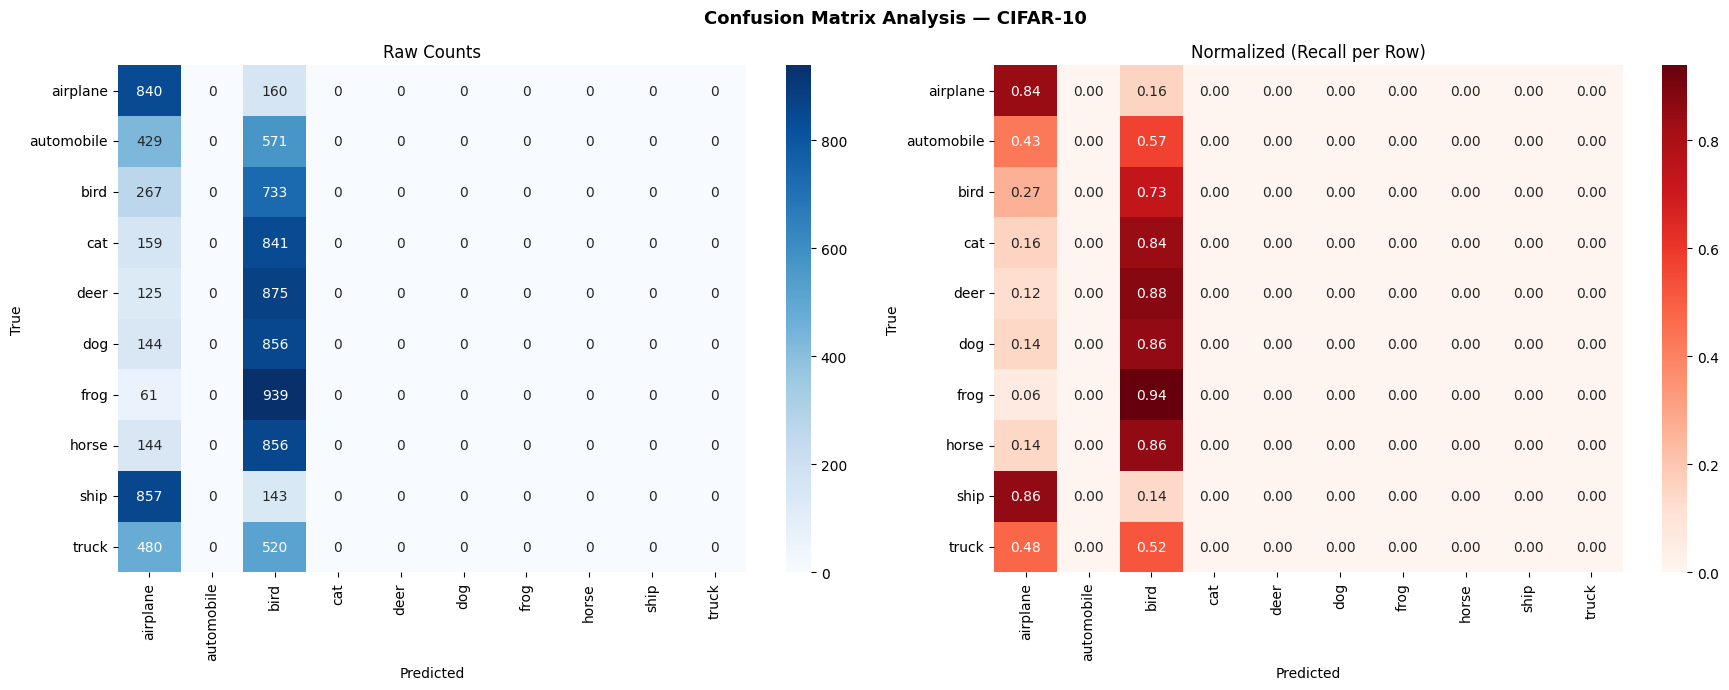


Top 15 Confusion Pairs:
True Class Pred Class  Count  Rate
      frog       bird    939 0.939
      deer       bird    875 0.875
      ship   airplane    857 0.857
       dog       bird    856 0.856
     horse       bird    856 0.856
       cat       bird    841 0.841
automobile       bird    571 0.571
     truck       bird    520 0.520
     truck   airplane    480 0.480
automobile   airplane    429 0.429
      bird   airplane    267 0.267
  airplane       bird    160 0.160
       cat   airplane    159 0.159
       dog   airplane    144 0.144
     horse   airplane    144 0.144

ANALYSIS 3: Misclassified Samples Visualization


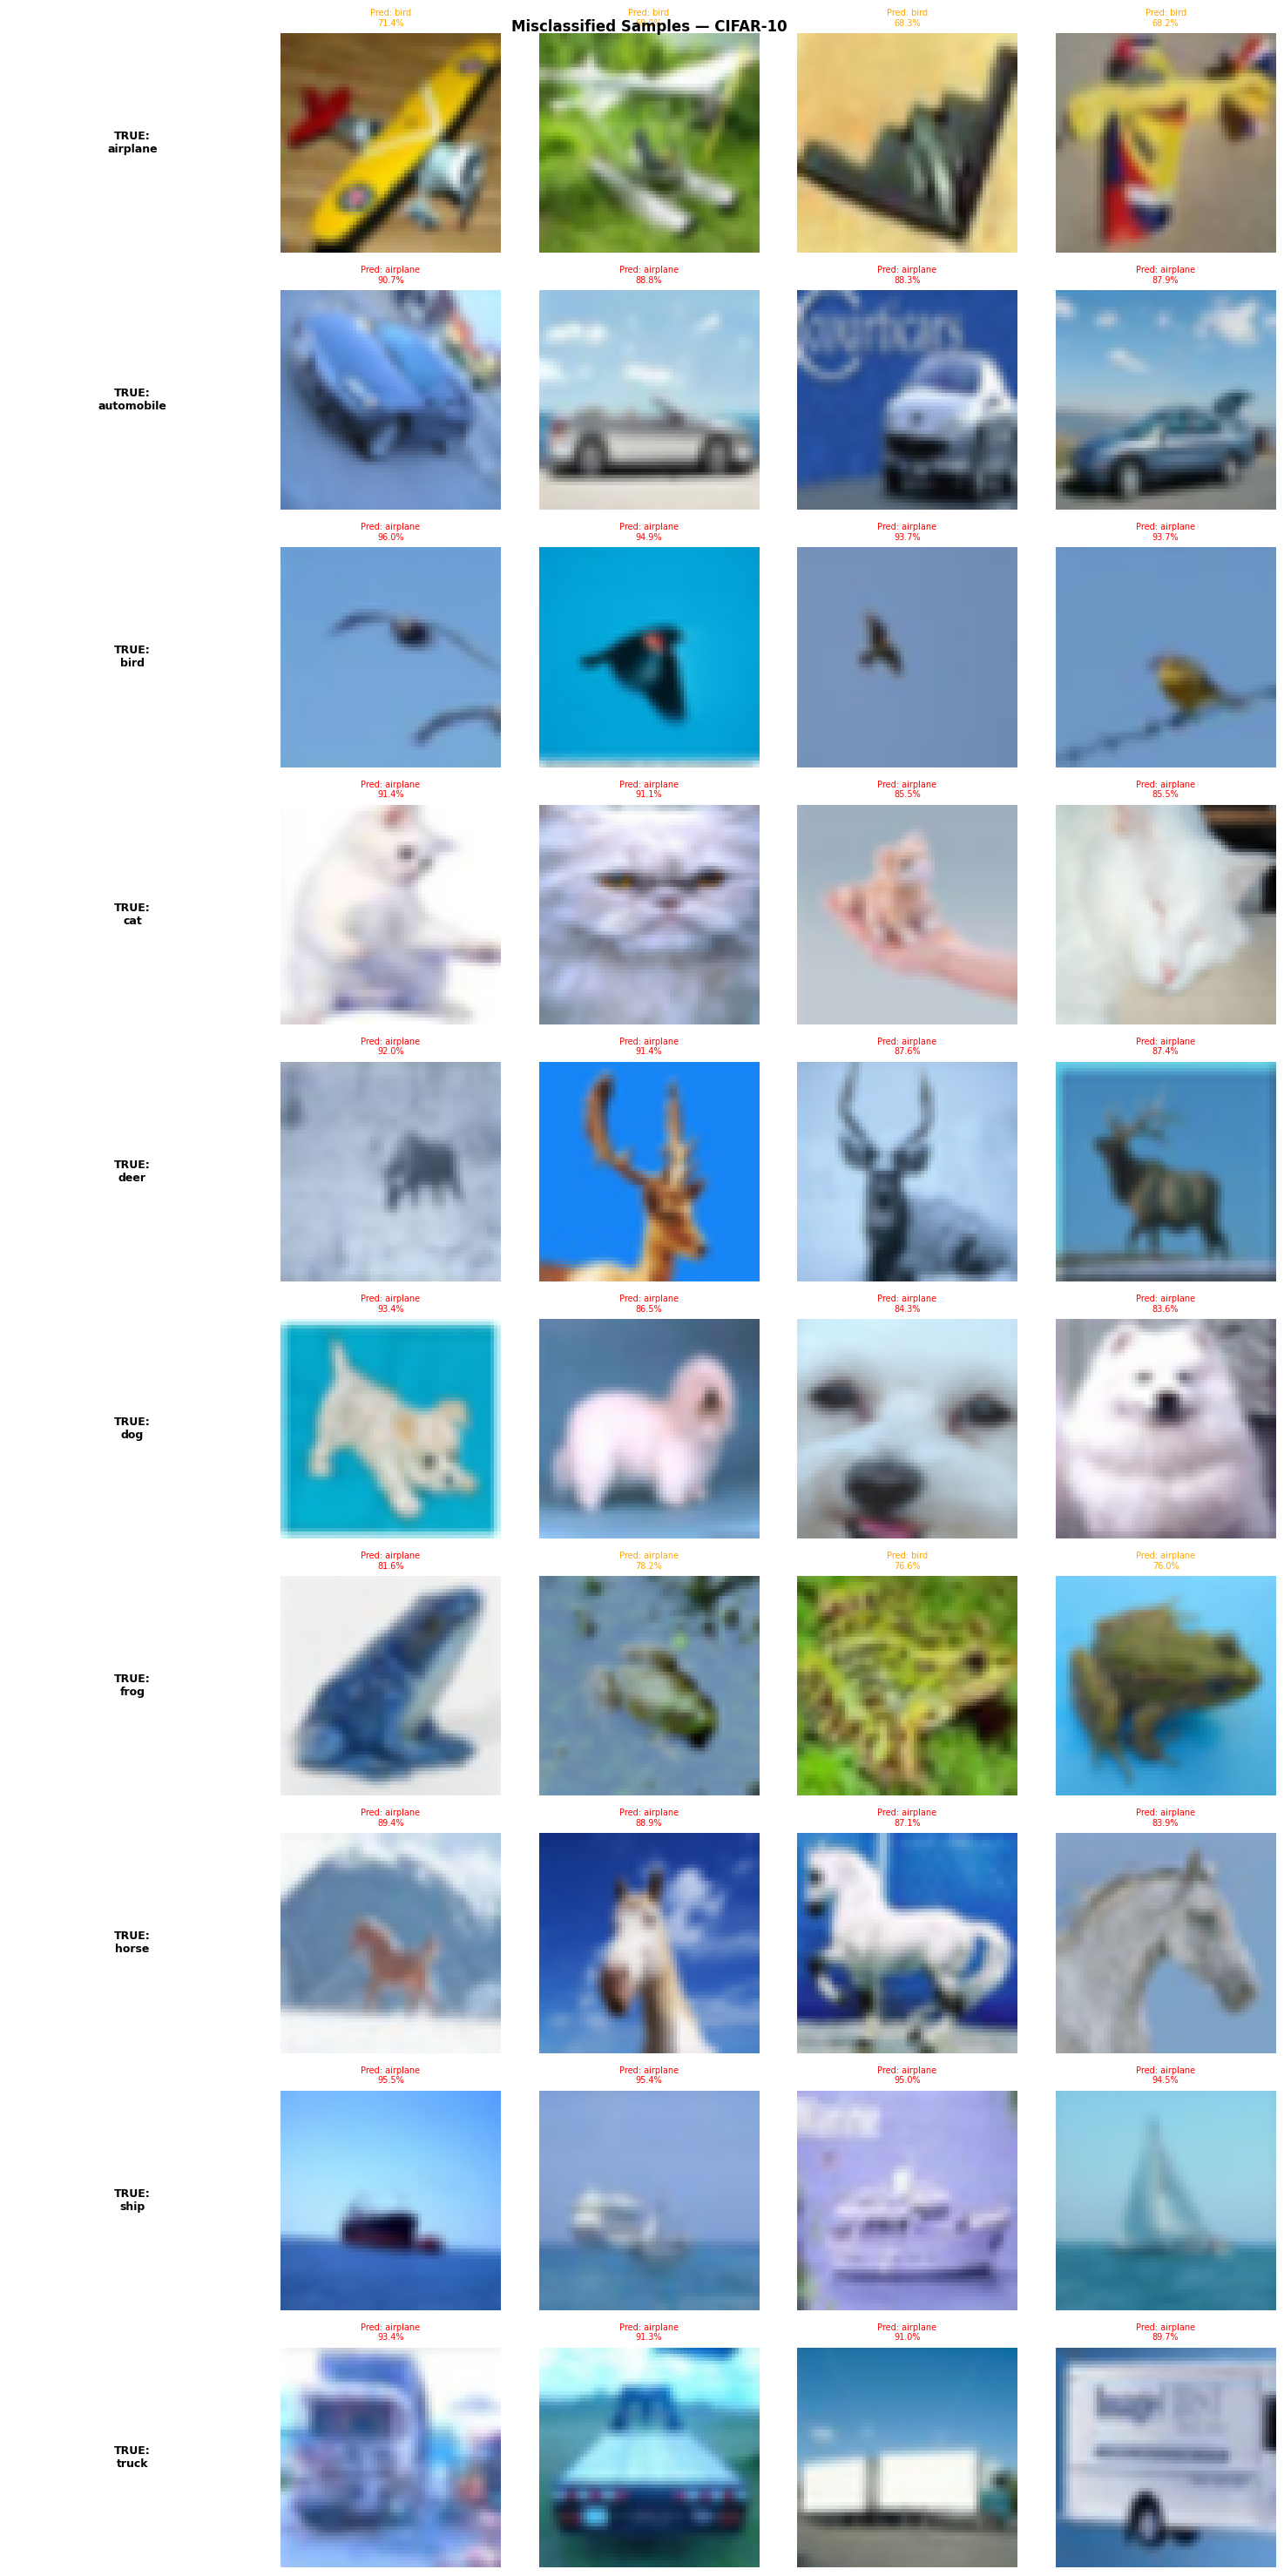

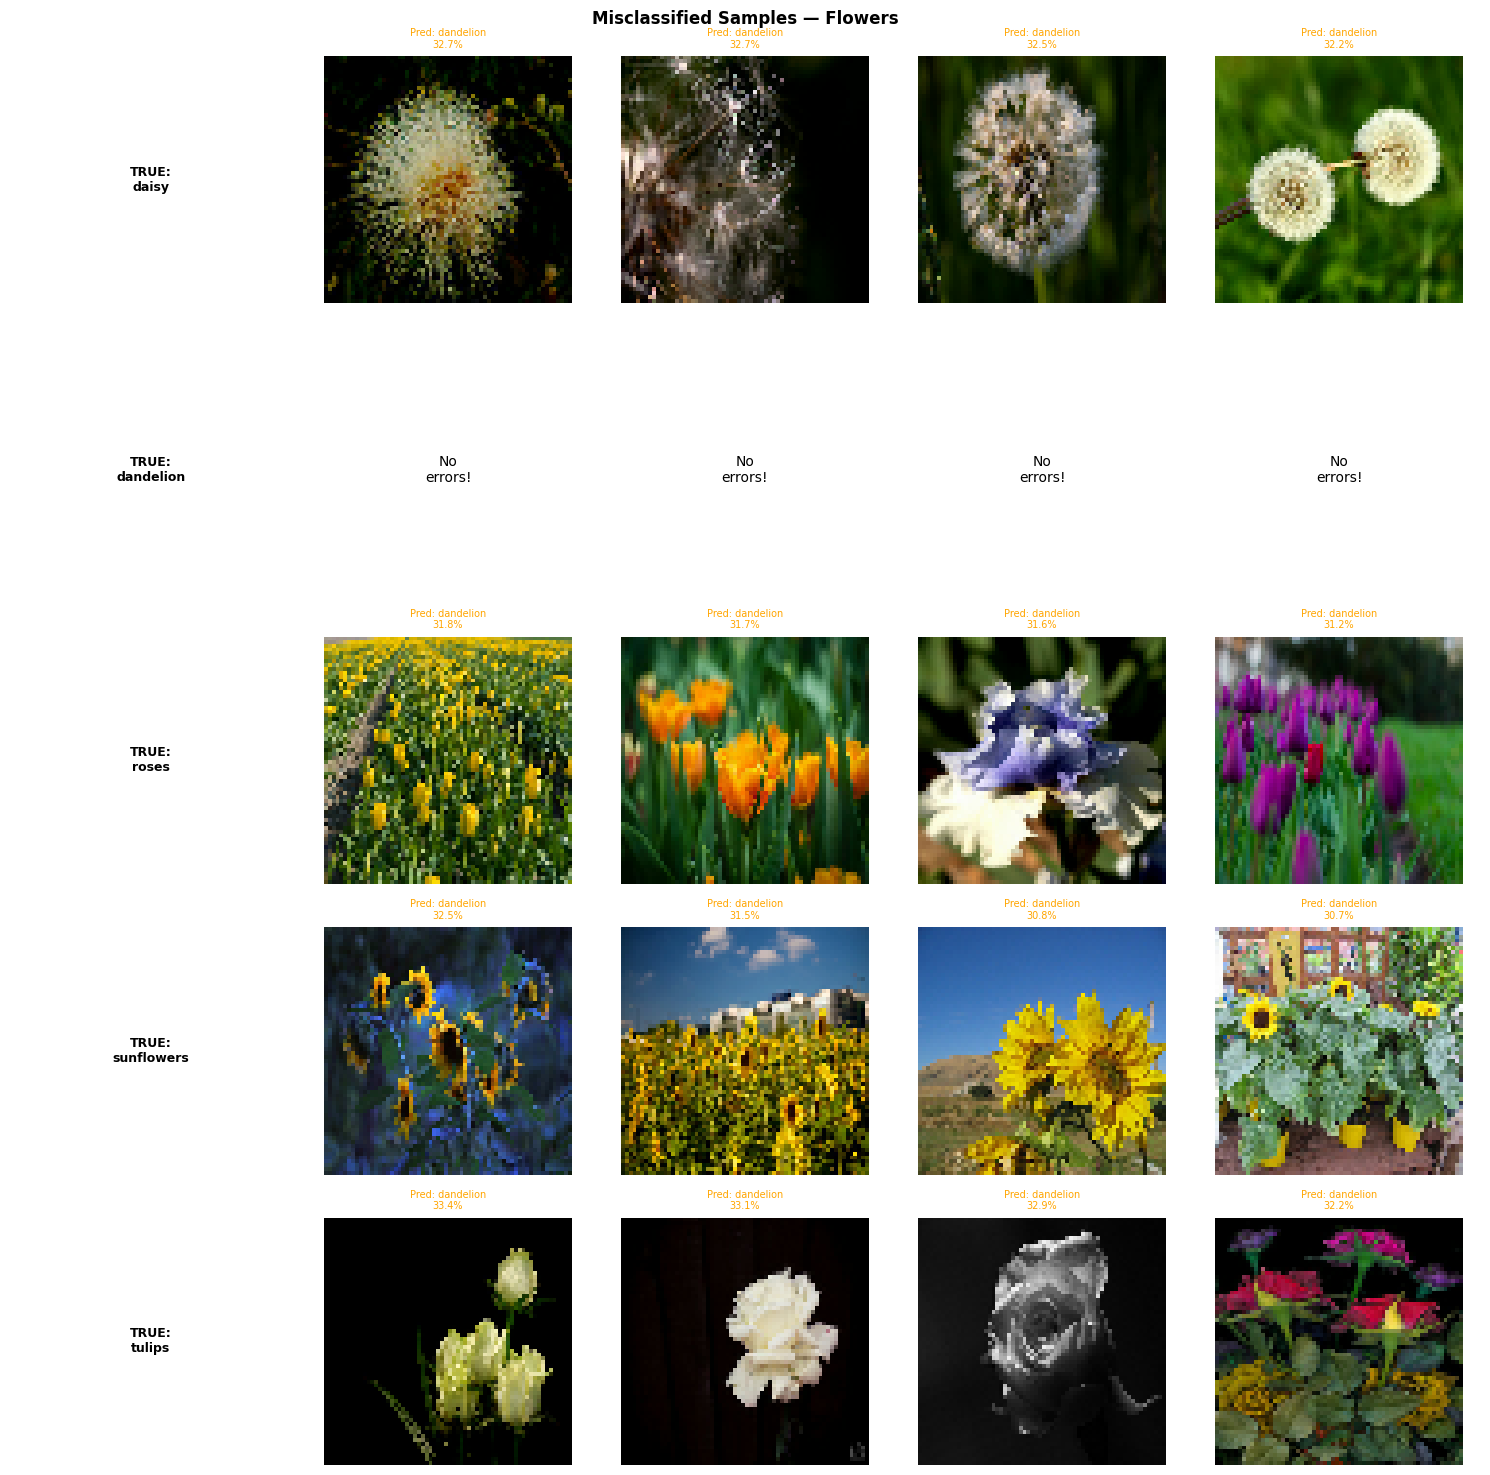


ANALYSIS 4: Imbalance-Error Correlation


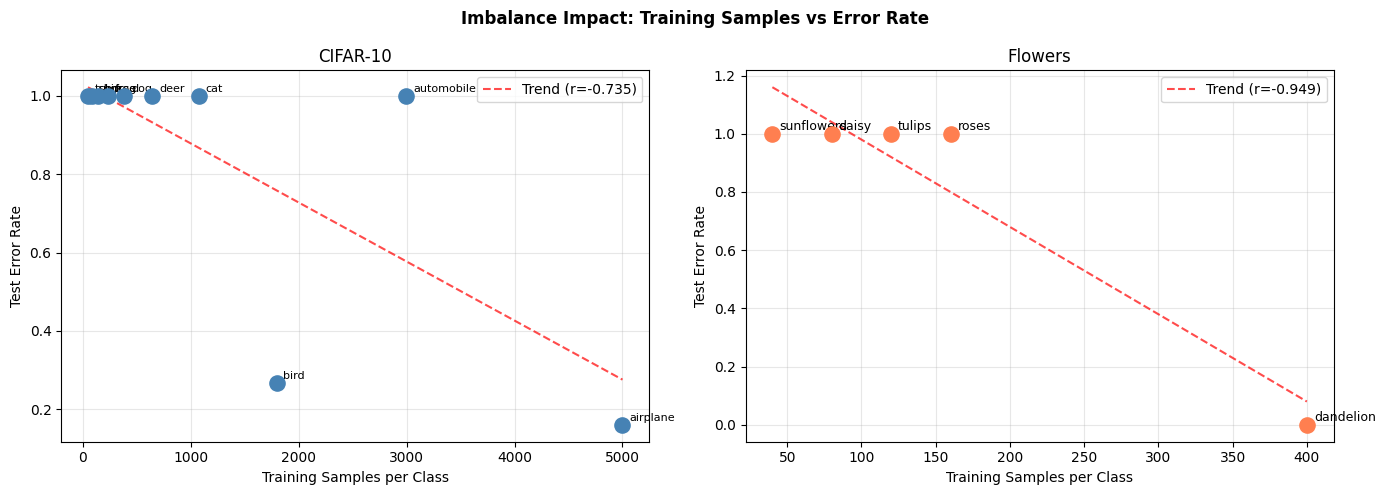


ANALYSIS 5: Model Confidence Analysis


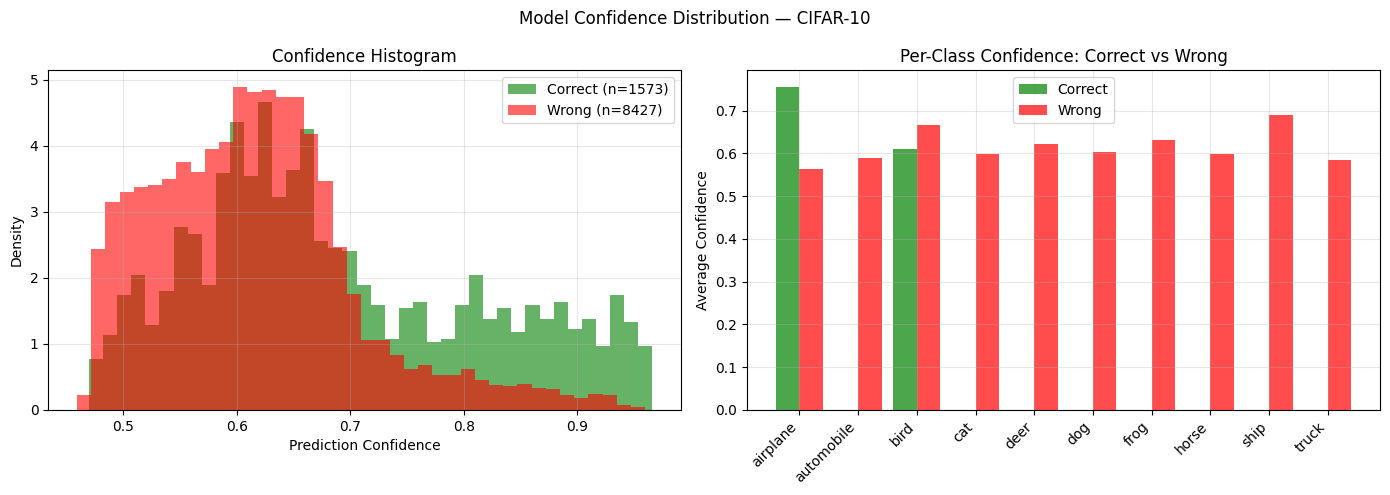


High-confidence mistakes (confidence > 90%): 75 samples
  → These are the most dangerous errors — model is very wrong but very sure.
  → Usually caused by: visual similarity between classes + insufficient minority data.


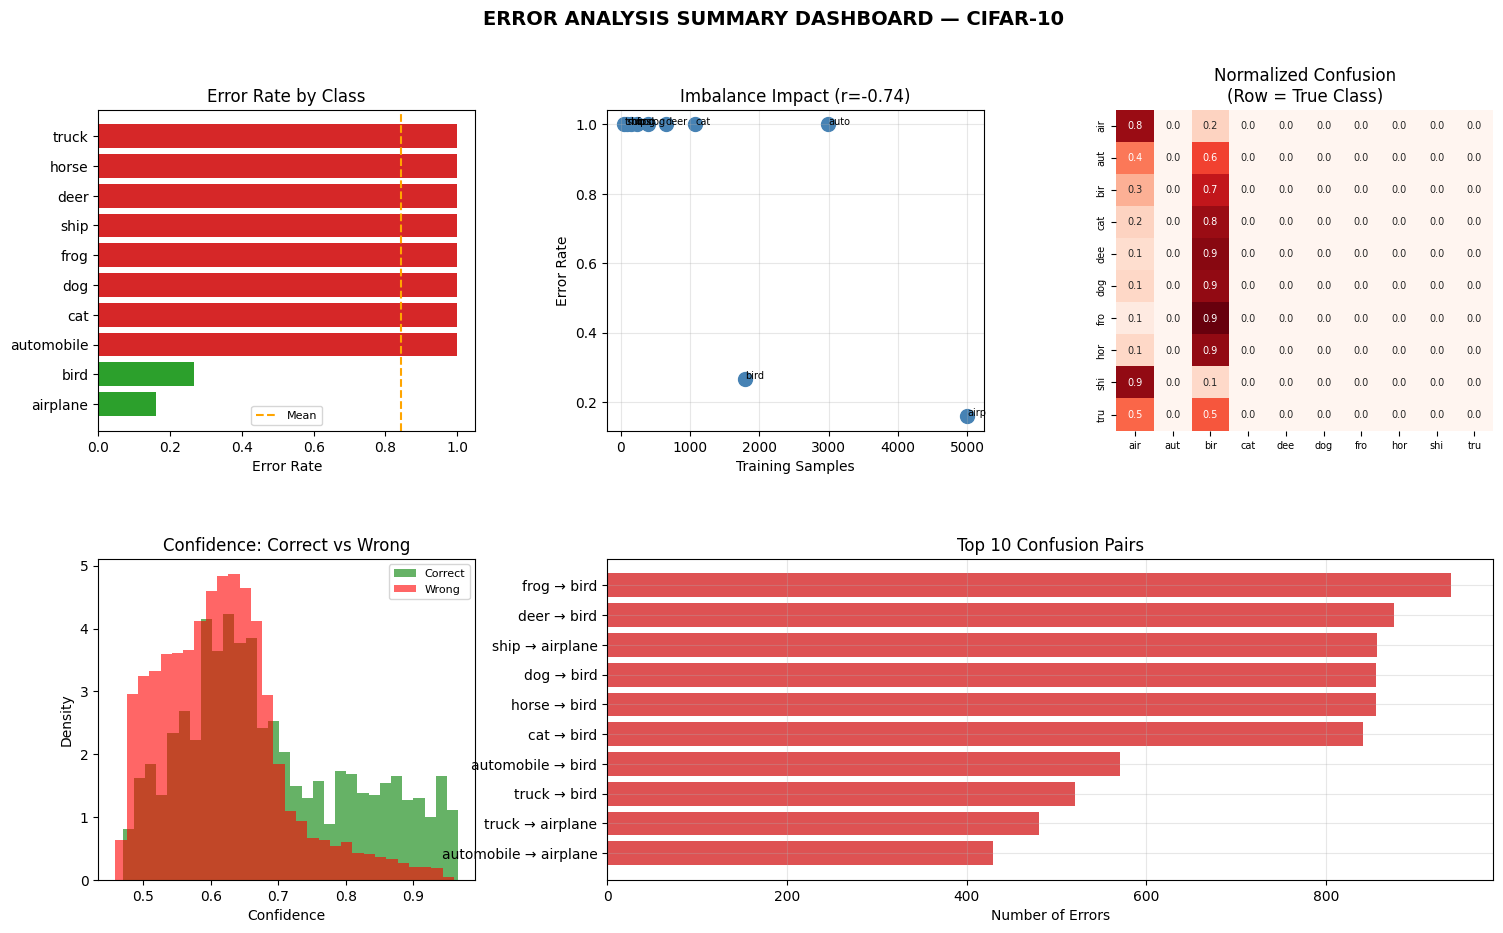


 Problem 7 complete!
   p7_confusion_cifar10.png
   p7_misclassified_cifar10.png / p7_misclassified_flowers.png
   p7_imbalance_error_correlation.png
   p7_confidence_analysis.png
   p7_error_dashboard.png
   p7_improvement_proposals.txt


In [8]:
# =============================================================================
# PROBLEM 7 — ERROR ANALYSIS & IMPROVEMENT PROPOSALS
# Deep dive into model failures and what causes them
# =============================================================================
# What this file covers:
#   Identify which classes fail most frequently
#   Confusion pattern analysis (which classes get confused with which)
#   Correlate errors with class imbalance ratios
#   Visualize misclassified samples (worst errors)
#   Confidence distribution of correct vs incorrect predictions
#   Per-class error rate vs sample count correlation
#   Improvement proposals with justification
# =============================================================================

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, callbacks
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.metrics import (classification_report, confusion_matrix,
                              f1_score, balanced_accuracy_score)
import seaborn as sns
import pandas as pd

# Load data
c10 = np.load('cifar10_imbalanced.npz')
x_train, y_train = c10['x_train'], c10['y_train']
x_test,  y_test  = c10['x_test'],  c10['y_test']

fl  = np.load('flowers_imbalanced.npz')
x_train_fl, y_train_fl = fl['x_train'], fl['y_train']
x_test_fl,  y_test_fl  = fl['x_test'],  fl['y_test']

CIFAR10_CLASSES = ['airplane','automobile','bird','cat','deer',
                   'dog','frog','horse','ship','truck']
FLOWER_CLASSES  = ['daisy','dandelion','roses','sunflowers','tulips']


# STEP 1: TRAIN FINAL MODEL (or load from P1)
# We train one final model WITH class weighting (best single strategy from P2)
# This is our "production" model for error analysis.

def build_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(32, 3, padding='same'), layers.BatchNormalization(), layers.Activation('relu'),
        layers.Conv2D(32, 3, padding='same'), layers.BatchNormalization(), layers.Activation('relu'),
        layers.MaxPooling2D(), layers.Dropout(0.25),
        layers.Conv2D(64, 3, padding='same'), layers.BatchNormalization(), layers.Activation('relu'),
        layers.Conv2D(64, 3, padding='same'), layers.BatchNormalization(), layers.Activation('relu'),
        layers.MaxPooling2D(), layers.Dropout(0.30),
        layers.Conv2D(128, 3, padding='same'), layers.BatchNormalization(), layers.Activation('relu'),
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, kernel_regularizer=regularizers.l2(1e-4)),
        layers.BatchNormalization(), layers.Activation('relu'), layers.Dropout(0.4),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model


CBACKS = [callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
          callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)]

# Try loading from P1; if not found, train fresh
try:
    model_c10 = tf.keras.models.load_model('best_custom_cnn_cifar10.keras')
    print(" Loaded pretrained CIFAR-10 model")
except:
    print("Training CIFAR-10 model (P1 model not found)...")
    from sklearn.utils.class_weight import compute_class_weight
    cw = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    cw_dict = dict(zip(np.unique(y_train), cw))
    model_c10 = build_model((32, 32, 3), 10)
    model_c10.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                      loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model_c10.fit(x_train, y_train, epochs=40, batch_size=64,
                  validation_split=0.15, callbacks=CBACKS, class_weight=cw_dict, verbose=1)

try:
    model_fl = tf.keras.models.load_model('best_custom_cnn_flowers.keras')
    print(" Loaded pretrained Flowers model")
except:
    print("Training Flowers model...")
    model_fl = build_model((64, 64, 3), 5)
    model_fl.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                     loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model_fl.fit(x_train_fl, y_train_fl, epochs=40, batch_size=32,
                 validation_split=0.15, callbacks=CBACKS, verbose=1)


# Get predictions for both datasets
y_probs_c10 = model_c10.predict(x_test, verbose=0)
y_pred_c10  = np.argmax(y_probs_c10, axis=1)
y_conf_c10  = np.max(y_probs_c10, axis=1)    # confidence of predicted class

y_probs_fl  = model_fl.predict(x_test_fl, verbose=0)
y_pred_fl   = np.argmax(y_probs_fl, axis=1)
y_conf_fl   = np.max(y_probs_fl, axis=1)

print(f"\nCIFAR-10 Test Accuracy: {(y_pred_c10 == y_test).mean():.4f}")
print(f"Flowers  Test Accuracy: {(y_pred_fl  == y_test_fl).mean():.4f}")


# ANALYSIS 1: PER-CLASS ERROR RATES
print("\n" + "="*60)
print("ANALYSIS 1: Per-Class Error Rates — CIFAR-10")
print("="*60)

train_counts   = np.bincount(y_train)
correct_mask   = (y_pred_c10 == y_test)
error_mask     = ~correct_mask

per_class_error = []
for cls in range(10):
    cls_mask      = y_test == cls
    n_total       = cls_mask.sum()
    n_wrong       = (error_mask & cls_mask).sum()
    error_rate    = n_wrong / n_total if n_total > 0 else 0
    per_class_error.append({
        'class': CIFAR10_CLASSES[cls],
        'train_samples': train_counts[cls],
        'test_total': int(n_total),
        'errors': int(n_wrong),
        'error_rate': error_rate
    })
    print(f"  {CIFAR10_CLASSES[cls]:12s} | train={train_counts[cls]:4d} | errors={n_wrong:4d}/{n_total:4d} | error_rate={error_rate:.3f}")

df_err = pd.DataFrame(per_class_error).sort_values('error_rate', ascending=False)

# Correlation: does fewer training samples → higher error rate?
corr = np.corrcoef(df_err['train_samples'], df_err['error_rate'])[0, 1]
print(f"\nCorrelation (train_samples ↔ error_rate): {corr:.4f}")
print("  → Strong negative correlation confirms: fewer samples → more errors (imbalance hurts!)")

# ANALYSIS 2: CONFUSION PATTERN ANALYSIS
print("\n" + "="*60)
print("ANALYSIS 2: Confusion Pattern Analysis")
print("="*60)

# Normalized confusion matrix (row-normalized = recall per class)
cm = confusion_matrix(y_test, y_pred_c10)
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

fig, axes = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle("Confusion Matrix Analysis — CIFAR-10", fontsize=13, fontweight='bold')

# Raw counts
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CIFAR10_CLASSES, yticklabels=CIFAR10_CLASSES, ax=axes[0])
axes[0].set_title("Raw Counts")
axes[0].set_ylabel("True"); axes[0].set_xlabel("Predicted")

# Normalized (recall view)
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Reds',
            xticklabels=CIFAR10_CLASSES, yticklabels=CIFAR10_CLASSES, ax=axes[1])
axes[1].set_title("Normalized (Recall per Row)")
axes[1].set_ylabel("True"); axes[1].set_xlabel("Predicted")

plt.tight_layout()
plt.savefig("p7_confusion_cifar10.png", dpi=150, bbox_inches='tight')
plt.show()

# Find top confusion pairs
off_diag = []
for i in range(10):
    for j in range(10):
        if i != j and cm[i, j] > 0:
            off_diag.append({
                'True Class':   CIFAR10_CLASSES[i],
                'Pred Class':   CIFAR10_CLASSES[j],
                'Count':        cm[i, j],
                'Rate':         round(cm_norm[i, j], 3)
            })

df_confusions = pd.DataFrame(off_diag).sort_values('Count', ascending=False).head(15)
print("\nTop 15 Confusion Pairs:")
print(df_confusions.to_string(index=False))


# ANALYSIS 3: VISUALIZE MISCLASSIFIED SAMPLES
print("\n" + "="*60)
print("ANALYSIS 3: Misclassified Samples Visualization")
print("="*60)

def show_misclassified(x_test, y_test, y_pred, y_conf, class_names, title, filename,
                        n_per_class=3):
    """
    Show the most confidently misclassified samples for each class.
    'Most confidently wrong' = model was SURE it was right but wasn't.
    These are the hardest errors to fix.
    """
    n_classes = len(class_names)
    fig, axes = plt.subplots(n_classes, n_per_class + 1, figsize=(3 * (n_per_class + 1), 3 * n_classes))
    fig.suptitle(f"Misclassified Samples — {title}", fontsize=12, fontweight='bold')

    for cls in range(n_classes):
        # Header column: class label
        axes[cls, 0].text(0.5, 0.5, f"TRUE:\n{class_names[cls]}",
                          ha='center', va='center', fontsize=9, fontweight='bold',
                          transform=axes[cls, 0].transAxes)
        axes[cls, 0].axis('off')

        # Get misclassified samples of this class, sorted by confidence (hardest first)
        cls_wrong_mask = (y_test == cls) & (y_pred != cls)
        wrong_idx      = np.where(cls_wrong_mask)[0]

        if len(wrong_idx) == 0:
            for col in range(1, n_per_class + 1):
                axes[cls, col].text(0.5, 0.5, "No\nerrors!", ha='center', va='center')
                axes[cls, col].axis('off')
            continue

        # Sort by model confidence (highest confidence = most misleading errors)
        confidence_wrong = y_conf[wrong_idx]
        sorted_idx       = wrong_idx[np.argsort(-confidence_wrong)][:n_per_class]

        for col, img_idx in enumerate(sorted_idx):
            ax = axes[cls, col + 1]
            img = x_test[img_idx]

            # Scale image for display
            if img.shape[0] == 32:
                img_display = tf.image.resize(img[np.newaxis], [64, 64]).numpy()[0]
            else:
                img_display = img

            ax.imshow(np.clip(img_display, 0, 1))
            ax.axis('off')
            pred_cls = y_pred[img_idx]
            conf     = y_conf[img_idx]
            ax.set_title(f"Pred: {class_names[pred_cls]}\n{conf*100:.1f}%",
                         fontsize=7, color='red' if conf > 0.8 else 'orange')

        # Fill empty slots
        for col in range(len(sorted_idx), n_per_class):
            axes[cls, col + 1].axis('off')

    plt.tight_layout()
    plt.savefig(filename, dpi=150, bbox_inches='tight')
    plt.show()


show_misclassified(
    x_test, y_test, y_pred_c10, y_conf_c10, CIFAR10_CLASSES,
    "CIFAR-10", "p7_misclassified_cifar10.png", n_per_class=4
)

show_misclassified(
    x_test_fl, y_test_fl, y_pred_fl, y_conf_fl, FLOWER_CLASSES,
    "Flowers", "p7_misclassified_flowers.png", n_per_class=4
)

# ANALYSIS 4: ERROR RATE vs TRAINING SAMPLES (scatter)
print("\n" + "="*60)
print("ANALYSIS 4: Imbalance-Error Correlation")
print("="*60)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle("Imbalance Impact: Training Samples vs Error Rate", fontsize=12, fontweight='bold')

# CIFAR-10
axes[0].scatter(df_err['train_samples'], df_err['error_rate'], s=120, zorder=5, c='steelblue')
for _, row in df_err.iterrows():
    axes[0].annotate(row['class'], (row['train_samples'], row['error_rate']),
                     textcoords='offset points', xytext=(5, 3), fontsize=8)

# Trend line
z = np.polyfit(df_err['train_samples'], df_err['error_rate'], 1)
p = np.poly1d(z)
xs = np.linspace(df_err['train_samples'].min(), df_err['train_samples'].max(), 100)
axes[0].plot(xs, p(xs), 'r--', alpha=0.7, label=f'Trend (r={corr:.3f})')
axes[0].set_xlabel("Training Samples per Class")
axes[0].set_ylabel("Test Error Rate")
axes[0].set_title("CIFAR-10")
axes[0].legend(); axes[0].grid(True, alpha=0.3)

# Flowers
fl_train_counts = np.bincount(y_train_fl)
fl_per_class_err = []
for cls in range(5):
    mask = y_test_fl == cls
    if mask.sum() == 0:
        continue
    err = ((y_pred_fl[mask] != cls)).mean()
    fl_per_class_err.append({'class': FLOWER_CLASSES[cls],
                              'train_samples': fl_train_counts[cls],
                              'error_rate': err})

df_fl_err = pd.DataFrame(fl_per_class_err)
axes[1].scatter(df_fl_err['train_samples'], df_fl_err['error_rate'], s=120, zorder=5, c='coral')
for _, row in df_fl_err.iterrows():
    axes[1].annotate(row['class'], (row['train_samples'], row['error_rate']),
                     textcoords='offset points', xytext=(5, 3), fontsize=9)

fl_corr = np.corrcoef(df_fl_err['train_samples'], df_fl_err['error_rate'])[0, 1]
z2 = np.polyfit(df_fl_err['train_samples'], df_fl_err['error_rate'], 1)
xs2 = np.linspace(df_fl_err['train_samples'].min(), df_fl_err['train_samples'].max(), 100)
axes[1].plot(xs2, np.poly1d(z2)(xs2), 'r--', alpha=0.7, label=f'Trend (r={fl_corr:.3f})')
axes[1].set_xlabel("Training Samples per Class")
axes[1].set_ylabel("Test Error Rate")
axes[1].set_title("Flowers")
axes[1].legend(); axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("p7_imbalance_error_correlation.png", dpi=150)
plt.show()

# ANALYSIS 5: CONFIDENCE DISTRIBUTION — Correct vs Incorrect
print("\n" + "="*60)
print("ANALYSIS 5: Model Confidence Analysis")
print("="*60)

correct_mask = (y_pred_c10 == y_test)
conf_correct = y_conf_c10[correct_mask]
conf_wrong   = y_conf_c10[~correct_mask]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle("Model Confidence Distribution — CIFAR-10", fontsize=12)

# Histogram
axes[0].hist(conf_correct, bins=40, alpha=0.6, color='green', label=f'Correct (n={len(conf_correct)})', density=True)
axes[0].hist(conf_wrong,   bins=40, alpha=0.6, color='red',   label=f'Wrong (n={len(conf_wrong)})',   density=True)
axes[0].set_xlabel("Prediction Confidence")
axes[0].set_ylabel("Density")
axes[0].set_title("Confidence Histogram")
axes[0].legend(); axes[0].grid(True, alpha=0.3)

# Per-class average confidence
cls_conf_correct, cls_conf_wrong = [], []
for cls in range(10):
    cls_mask = y_test == cls
    correct_cls = cls_mask & correct_mask
    wrong_cls   = cls_mask & ~correct_mask
    cls_conf_correct.append(y_conf_c10[correct_cls].mean() if correct_cls.sum() > 0 else 0)
    cls_conf_wrong.append(y_conf_c10[wrong_cls].mean()   if wrong_cls.sum()   > 0 else 0)

x = np.arange(10)
axes[1].bar(x - 0.2, cls_conf_correct, 0.4, label='Correct', color='green', alpha=0.7)
axes[1].bar(x + 0.2, cls_conf_wrong,   0.4, label='Wrong',   color='red',   alpha=0.7)
axes[1].set_xticks(x); axes[1].set_xticklabels(CIFAR10_CLASSES, rotation=45, ha='right')
axes[1].set_ylabel("Average Confidence")
axes[1].set_title("Per-Class Confidence: Correct vs Wrong")
axes[1].legend(); axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("p7_confidence_analysis.png", dpi=150)
plt.show()

high_conf_wrong = (y_conf_c10 > 0.9) & ~correct_mask
print(f"\nHigh-confidence mistakes (confidence > 90%): {high_conf_wrong.sum()} samples")
print("  → These are the most dangerous errors — model is very wrong but very sure.")
print("  → Usually caused by: visual similarity between classes + insufficient minority data.")

# SUMMARY DASHBOARD

fig = plt.figure(figsize=(18, 10))
fig.suptitle("ERROR ANALYSIS SUMMARY DASHBOARD — CIFAR-10", fontsize=14, fontweight='bold')
gs  = gridspec.GridSpec(2, 3, figure=fig, hspace=0.4, wspace=0.35)

# 1. Error rate by class
ax1 = fig.add_subplot(gs[0, 0])
df_sorted = df_err.sort_values('error_rate', ascending=True)
colors1   = ['#2ca02c' if r < 0.4 else '#d62728' for r in df_sorted['error_rate']]
ax1.barh(df_sorted['class'], df_sorted['error_rate'], color=colors1)
ax1.axvline(df_err['error_rate'].mean(), color='orange', linestyle='--', label='Mean')
ax1.set_title("Error Rate by Class"); ax1.set_xlabel("Error Rate"); ax1.legend(fontsize=8)

# 2. Sample count vs error rate
ax2 = fig.add_subplot(gs[0, 1])
ax2.scatter(df_err['train_samples'], df_err['error_rate'], s=100, c='steelblue')
for _, row in df_err.iterrows():
    ax2.annotate(row['class'][:4], (row['train_samples'], row['error_rate']), fontsize=7)
ax2.set_xlabel("Training Samples"); ax2.set_ylabel("Error Rate")
ax2.set_title(f"Imbalance Impact (r={corr:.2f})")
ax2.grid(True, alpha=0.3)

# 3. Normalized confusion heatmap (smaller)
ax3 = fig.add_subplot(gs[0, 2])
sns.heatmap(cm_norm, annot=True, fmt='.1f', cmap='Reds',
            xticklabels=[c[:3] for c in CIFAR10_CLASSES],
            yticklabels=[c[:3] for c in CIFAR10_CLASSES],
            ax=ax3, cbar=False, annot_kws={'size': 7})
ax3.set_title("Normalized Confusion\n(Row = True Class)")
ax3.tick_params(axis='both', labelsize=7)

# 4. Confidence histogram
ax4 = fig.add_subplot(gs[1, 0])
ax4.hist(conf_correct, bins=30, alpha=0.6, color='green', label='Correct', density=True)
ax4.hist(conf_wrong,   bins=30, alpha=0.6, color='red',   label='Wrong',   density=True)
ax4.set_xlabel("Confidence"); ax4.set_ylabel("Density")
ax4.set_title("Confidence: Correct vs Wrong"); ax4.legend(fontsize=8)

# 5. Top confusion pairs bar
ax5 = fig.add_subplot(gs[1, 1:])
top10 = df_confusions.head(10)
labels = [f"{r['True Class']} → {r['Pred Class']}" for _, r in top10.iterrows()]
ax5.barh(labels[::-1], top10['Count'].values[::-1], color='#d62728', alpha=0.8)
ax5.set_xlabel("Number of Errors")
ax5.set_title("Top 10 Confusion Pairs")
ax5.grid(True, alpha=0.3)

plt.savefig("p7_error_dashboard.png", dpi=150, bbox_inches='tight')
plt.show()

print("\n Problem 7 complete!")
print("   p7_confusion_cifar10.png")
print("   p7_misclassified_cifar10.png / p7_misclassified_flowers.png")
print("   p7_imbalance_error_correlation.png")
print("   p7_confidence_analysis.png")
print("   p7_error_dashboard.png")
print("   p7_improvement_proposals.txt")